# Predicting the standard map: parallel approach

Recall that, in notebook *StandardMap.ipynb*, we aimed to learn the dynamics of the standard map. In other words, we trained an echo states network in order to make it capable of predicting the standard map dynamics. As already detailed there, the standard map is composed of two parameters: the *angular position* ($\theta$) and the *angular momentum* ($p$). In the aproach followed in the already mentioned notebook, the network was trained in order to jointly predict both parameters. However, in this notebook, we will *parallelize* the training. That is, we will train both parameters separatedly. We want to see if, by doing so, the predicting capability is increased.

The training procedure as well as the parameters will be the same as the ones used in notebook *StandardMap.ipynb*. In fact, many experiments have been performed in order to improve such result, but non of them appeared to do so. See Section 3 of the already mentioned notebook in order to see how to systemmatically tune the parameters. 

This notebook is supplementary to the notebook *StandardMap.ipynb*, thus see such notebook for more details regarding the task and the standard map itself.

The notebook is structured as follows:

+ [$\text{1. Dynamics defined by the angular position ($\theta$)}$](#theta)
    + [$\text{1.1 K=0}$](#tK0)
    + [$\text{1.2 K=0.1}$](#tK01)
    + [$\text{1.3 K=0.25}$](#tK025)
    + [$\text{1.4 K=0.5, 0.75, 0.9}$](#tKmult)
    + [$\text{1.5 Chaotic behavior}$](#tKchaos)
+ [$\text{2. Dynamics defined by the angular momentum (p)}$](#p)
    + [$\text{2.1 K=0}$](#pK0)
    + [$\text{2.2 K=0.1}$](#pK01)
    + [$\text{2.3 K=0.25}$](#pK025)
    + [$\text{2.4 K=0.5, 0.75, 0.9}$](#pKmult)
    + [$\text{2.5 Chaotic behavior}$](#pKchaos)
    
Therefore, in [Section 1](#theta) and [Section 2](#p), the network will be trained in order to learn and predict the dynamics given by the angular position and angular momentum respectively.

#  1. Dynamics defined by the angular position ($\theta$) <a name="theta" ></a>

In [ ]:
#restart the kernel
import os
os._exit(00)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import pdb

In [2]:
def esc(code):
    return f'\033[{code}m'

In [3]:
class Network():
    def __init__(self, T = None, n_min = None, K = None, N = None, L = None, W_in = None, W = None, W_back = None,
                 non_null_matrices = None, u = None, u_test = None, kick = None, InitialCondition_ODE = None,
                delta = 1, C = 1, a = 1):
        
        #NEED TO BE DEFINED BY THE USER:
        self.T = T #number of training time steps (integer)
        self.n_min = n_min #time steps dismissed (integer)
        
        self.K = K #dimension of the input (integer) (may be None)
        self.N = N #dimension of the reservoir, i.e, number of nodes (integer)
        self.L = L #dimension of the output (integer)
        
        self.W_in = W_in #input connections (matrix of size self.N x self.K)
        self.W = W #adjacency matrix (matrix of size self.N x self.N)
        self.W_back = W_back #feedback connections (matrix of size self.N x self.L) (may be None)
        
        self.non_null_matrices = non_null_matrices #list giving the matrices used when training: "W_in" and/or "W_back"
        
        self.u = u ##input (matrix of size self.K x 1) (may be None)              
        
        self.kick = kick #strength of the kick (float)
        self.InitialCondition_ODE = InitialCondition_ODE #initial condition of the ODE given as the list [theta,p]

        self.delta = delta #training parameter (float)
        self.C = C #training parameter (float)
        self.a = a #training parameter (float)
        
               
        #DO NOT NEED TO BE DEFINED BY THE USER:
        self.initial_state = None #initial state of the reservoir (state forgetting property)        
        self.trajectories = None #dynamics of the reservoir (matrix of size self.T x self.N) 
        self.regressor = None #regressor
        self.y_teach = None #desired output of the network (matrix of size self.L x self.T)
        self.y_teach_test = None #y_teach for doing the test (matrix of size self.L x (t_dismiss+t_autonom))
        
        
        
        
    def orbit(self, ic, k, t, squash=False):
        """
        Args:
            -ic, list giving the initial conditions [theta,p]
            -k, value of the kick
            -t, number of time steps
            -squash, whether we want to squash the orbits into [-0.5,0.5]
        
        Returns:
            -Matrix of size 1xt given the orbit followed by the given initial point during t time steps. 
            The single row corresponds to theta. The first column gives the initial 
            condition. Such orbit is squashed into [-0.5,0.5] if squash=True
        """
        
        trajectory_theta = [ic[0]]
        trajectory_p = [ic[1]]
            
        for time_step in np.arange(t-1):
            p_next = np.mod(trajectory_p[-1] + k*np.sin(trajectory_theta[-1]), 2*np.pi)
            theta_next = np.mod(trajectory_theta[-1] + p_next, 2*np.pi)
            trajectory_theta.append(theta_next)
            trajectory_p.append(p_next)
        trajectory_theta = np.asarray(trajectory_theta)
        trajectory_p = np.asarray(trajectory_p)
               
        if squash == True:
            trajectory_theta = trajectory_theta/(2*np.pi)-0.5
            trajectory_p = trajectory_p/(2*np.pi)-0.5
                                    
        return trajectory_theta.reshape(1,-1)
    
    
    def dismiss_transient(self, M):
        """
        Given a matrix M, it removes the first n_min rows. Therefore:
        -If M = self.trajectories, it removes the transient of n_min.
        -If M = self.y_teach.T, it removes the transient of n_min.
        So, it removes the initial condition plus the following n_min-1 time steps
        NOTICE: y_teach has to be transposed when inputted
        """
        
        return M[self.n_min:,:]   
    
    
    def augmented_x(self, M):
        """
        Given a matrix M, it powers to the square the last half of its columns Therefore:
        -If M = self.trajectories, it squares the trajectories of the last half of the nodes.
        -If M = x, where x is the state of the nodes at a certain time step, it squares the current stat of the last 
        half of the nodes.
        NOTICE: x has to be inputted as a matrix of size 1 x self.N
        """   
    
        aux1 = M[:,:int(self.N/2)]
        aux2 = M[:,int(self.N/2):]
    
        return np.hstack((aux1, aux2**2))
    
    
    
    def compute_nodes_trajectories(self, test=False, noise=None, stDev=None, t_dismiss=None, t_autonom=None, NRMSE=False, horizon=None, num_runs=None): 
        """
        If test=False:
            -It computes self.trajectories, which is a matrix of size TxN, where each column is the trajectory of 
            a node. Notice that the first row corresponds to the initial state
            -It admits noise, in which case the "stDev" has to be specified
        
        If test=True and NRMSE=False:
            -Computes the predictions for the desired t_autonom regarding a teacher enforcing of t_dismiss time steps
        
        If test=True and NRMSE=True:
            -It computes the predictions at the desired time steps. That is, the network runs from the initial
            conditions for 1000 time steps by means of teacher enforcing. Then, it autonomoulsy runs the number of
            steps specified in the variable horizon. This is repeated num_runs time.
            Therefore, it return the predictions at time steps [i*(1000+horizon)-1 for i in np.arange(1,num_runs+1)]
        """
        
        #initial state of the reservoir
        if test == False:
            self.trajectories = self.initial_state
            x_prev = self.initial_state  
        if test == True:
            if NRMSE == False:
                x_prev = self.trajectories[t_dismiss-1,:]
            elif NRMSE == True:
                x_prev = self.initial_state
           
                
        if test == False:             
            if noise == True:
                #nu = np.random.uniform(low=-stDev, high=stDev, size=(self.N, self.T)) #uniform
                nu = np.random.normal(loc = 0, scale = stDev, size=(self.N, self.T)) #Gaussian noise                
                
            elif noise == False:
                nu = np.zeros([self.N, self.T]) 
                
                
        if "W_in" not in self.non_null_matrices:
            self.W_in = np.zeros([self.N, 1])
            if test == False:
                self.u = np.zeros([1, 1]) 
        
        
            
        if "W_back" not in self.non_null_matrices:
            self.W_back = np.zeros([self.N, 1])
            if test == False:
                y = np.zeros([1, self.T]) 
            elif test == True:
                if NRMSE == False:
                    y = np.zeros([1, self.T+t_autonom])
                elif NRMSE == True:
                    y = np.zeros([1, self.T+t_autonom])
            
        if "W_back" in self.non_null_matrices:
            if test == False:
                y = np.copy(self.y_teach)
            elif test == True:
                if NRMSE == False:
                    y = np.copy(self.y_teach_test[:,t_dismiss-1].reshape(-1,1))
                    
                

        delta = self.delta
        C = self.C
        a = self.a                

        
        if test == False:
            for n in np.arange(self.T-1):
                x = (1-delta*C*a)*x_prev + delta*C*np.tanh(np.dot(self.W_in,self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,y[:,n])+nu[:,n]) #noise added to the whole update 
                self.trajectories = np.vstack((self.trajectories,x))
                x_prev = x           
            return self
        
        elif test == True:
            if NRMSE == False:
                for n in np.arange(t_autonom):
                    x = (1-delta*C*a)*x_prev + delta*C*np.tanh(np.dot(self.W_in, self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,y[:,n]))
                    x_prev = x   
                    y_next = np.tanh(self.regressor.predict(self.augmented_x(x.reshape(1,-1)).reshape(1,-1))) 
                    y_next = y_next.reshape(-1,1)
                    y = np.hstack([y,y_next]) 
                    
                    
                return y  
            
            elif NRMSE == True:
                y = np.zeros([self.L,1]) #this is just for initializing the hstack. It will be removed at the end
                for run in np.arange(num_runs):
                    
                    #teacher enforcing
                    for n in np.arange(1000):
                        x = (1-delta*C*a)*x_prev + delta*C*np.tanh(np.dot(self.W_in, self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,self.y_teach_test[:,(run*(1000+horizon))+n]))
                        x_prev = x
                        
                    #autonomously run
                    for n in np.arange(horizon):                        
                        y_next = np.tanh(self.regressor.predict(self.augmented_x(x.reshape(1,-1)).reshape(1,-1)))                                                                      
                        y_next = np.asarray(y_next).reshape(-1)
                        x = (1-delta*C*a)*x_prev + delta*C*np.tanh(np.dot(self.W_in, self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,y_next))
                        x_prev = x
                    
                    y = np.hstack([y,y_next.reshape(-1,1)])
                    
                return y[:,1:]
            
    
    
    def plot_nodes_trajectories(self, sel_nodes=False, num_nodes=10):
        """
        Args:
            -sel_nodes, list specifying the nodes of the reservoir to be plotted. If sel_nodes=False, it randomly
            selects num_nodes nodes of the reservoir.
        
        Returns:
            -Plots the trajectories of the given nodes.
        """
        
        if sel_nodes == False:
            nodes_to_plot = random.sample(range(self.N),num_nodes) #select num_nodes random nodes
        else:
            nodes_to_plot = sel_nodes
        
        t = np.arange(self.T) #time steps
        for node in nodes_to_plot:
            plt.plot(t, self.trajectories[:,node])  
            plt.title("Trajectories of the node {}".format(node))
            plt.show()
            
            
    def train_network(self, plot=False, noise=False, stDev=0.01, regression_type = 'LinearRegression', regression_param=None):
        """
        Args:
            -plot, whether we want to plot the trajectories of 10 randomly selected nodes of the reservoir
            -noise, whether we want to add noise when training
            -stDev, if noise=True and stDev=a is the standard deviation of the noise
            -regression_type: it admits LinearRegression, Ridge or Lasso (string).
            -regression_param: parameter when performing Ridge or Lasso
        
        Returns:
            -Performs the training and returns the object self. It computes self.trajectories, self.regressor and
            prints the training MSE component-wise.
        """
        
        #Define the initial state (which is not relevant due to state forgetting property)
        #Define the ground truth
        self.initial_state = np.zeros(self.N)
        self.y_teach = self.orbit(self.InitialCondition_ODE, self.kick, self.T, squash=True)        
        
        #Compute trajectories
        self.compute_nodes_trajectories(noise=noise, stDev=stDev)

        #plot some trajectories
        if plot == True:
            self.plot_nodes_trajectories()
            
        if regression_type == 'LinearRegression':
            regressor = LinearRegression()
        elif regression_type == 'Ridge':
            regressor = Ridge(alpha = regression_param)
        elif regression_type == 'Lasso':
            regressor = Lasso(alpha = regression_param)
        
        x = self.dismiss_transient(self.trajectories)        
        regressor.fit(self.augmented_x(x), np.arctanh(self.dismiss_transient(self.y_teach.T))) 
        
        #Compute MSE    
        MSE_vector = 1/(self.T-self.n_min)*sum((np.arctanh(self.dismiss_transient(self.y_teach.T)) - regressor.predict(self.augmented_x(x)))**2) #augmented
                
        if self.L == 1: #in case the output is one dimensional
            print("The training MSE is {}".format(MSE_vector[0]))        
        else: #in case the output has dimension 2 or more
            for i in np.arange(self.L):
                print("The training MSE for the {}-th dimension is {}".format(i+1, MSE_vector[i]))        
                                              
        self.regressor = regressor   
        
        return self    
    
    
    
    def test_network(self, t_dismiss, t_autonom, NRMSE=True):
        """
        Args:
            -t_dismiss, which is the time we let the reservoir evolve by teacher enforcing.
            -t_autonom, which is the time we let the network freely run  
            -NRMSE, which says whether we want to compute the 84 NRMSE error
        
        Returns:
            -The MSE and NRMSE (whenever NRMSE=True) during the t_autonom component-wise
            -Plots the predicted trajectory during the t_autonom against the ground truth.
        """  
        
        #Define y_teach_test
        self.y_teach_test = self.orbit(self.InitialCondition_ODE, self.kick, t_dismiss+t_autonom, squash=True)
            
                      
        #predict
        y = self.compute_nodes_trajectories(test=True, t_dismiss=t_dismiss, t_autonom=t_autonom)
        y = y[:,1:] #remove the first one
            
        
        #plot prediction vs ground truth        
        plt.figure(figsize=(20,7))
        plt.plot(self.y_teach_test[0,t_dismiss:t_dismiss+t_autonom], '.', label="ground truth")
        plt.plot(y[0,:], '.', label="Network's prediction")                
        plt.title('Phase space for K={}'.format(self.kick))
        plt.xlabel('time')
        plt.ylabel('theta (position)') 
        plt.legend()        
        plt.show() 
        

        #MSE 
        MSE = 1/t_autonom*sum((self.y_teach_test[:,t_dismiss:t_dismiss+t_autonom]-y).T**2) 
        
        if self.L == 1: #in case the output is one dimensional
            print("The test MSE is {}".format(MSE[0]))        
        else: #in case the output has dimension 2 or more
            for i in np.arange(self.L):
                print("The test MSE for the {}-th dimension is {}".format(i+1, MSE[i]))        
           

        #NRMSE
        if NRMSE == True:
            NRMSE = self.compute_NRMSE()
            
            if self.L == 1: #in case the output is one dimensional
                print("The 84 NRMSE is {}".format(NRMSE[0]))        
            else: #in case the output has dimension 2 or more
                for i in np.arange(self.L):
                    print("The 84 NRMSE for the {}-th dimension is {}".format(i+1, NRMSE[i]))
                    
            
                
    def compute_NRMSE(self, horizon=84, num_runs=50):
        """
        Computes the 84 NRMSE component-wise for the given horizon (specified in the parameter horizon) and for
        the given number of runs (specified in the parameter num_runs).
        """
        
        #Redefine the self.y_teach_test. It will be of size 2x(1048x50) 
        self.y_teach_test = self.orbit(self.InitialCondition_ODE, self.kick, (1000+horizon)*num_runs, squash=True)
        var = []
        for i in np.arange(self.L):
            #variance of i-th component
            var.append(np.average(self.y_teach_test[i,:]**2)-np.average(self.y_teach_test[i,:])**2) 
            
        
        #desired predictions at the required time steps
        y = self.compute_nodes_trajectories(test=True, NRMSE=True, horizon=horizon, num_runs=num_runs)
        
        #Compute the NRMSE
        list_cols = [i*(1000+horizon)-1 for i in np.arange(1,num_runs+1)]
        y_ground_truth = self.y_teach_test[:, list_cols] 
        y_ground_truth = 2*np.pi*(y_ground_truth + 0.5) #recover original values
        y = 2*np.pi*(y + 0.5) #recover original values
        
        NRMSE = []
        for i in np.arange(self.L):
            NRMSE.append((sum((y_ground_truth[i,:]-y[i,:])**2)/var[i])**0.5)           
                  
        
        return NRMSE 

    
           

    def train_test(self, ic_list, k, t_dismiss, t_autonom, NRMSE=True, noise=False, stDev=0.01, regression_type='LinearRegression', regression_param=None):
        """
        Performs the training and testing for different initial conditions
        
        Arguments:
            -ic_list, list specifying the initial condition (in the form of [theta, p])
            -k, value of the kick
            -noise, whether we want to introduce noise during training
            -stDev, standard deviation of the noise in case noise=True
            -regression_type, admits LinearRegression, Ridge or Lasso
            -regression_param, parametr for the Ridge or Lasso
            -t_dismiss, t_dismiss for testing
            -t_autonom, t_autonom for testing
            -NRMSE, whether we want to print the NRMSE
        """
        self.kick = k
                
        for ic in ic_list:
        
            #set ic
            self.InitialCondition_ODE = ic
                
            print(esc(0))
            print(esc('31;1;4') + 'Initial condition ic={}'.format(ic))
            print(esc(0))
                
            #training
            self.train_network(plot=False, noise=noise, stDev=stDev, regression_type=regression_type, regression_param=regression_param)
                    
            #testing
            self.test_network(t_dismiss=t_dismiss, t_autonom=t_autonom, NRMSE=NRMSE) 
            

    def train_test_k(self, ic, k_list, t_dismiss, t_autonom, NRMSE=True, noise=False, stDev=0.01, regression_type='LinearRegression', regression_param=None):
        """
        Performs the training and testing for different a single initial condition but different values of k
        
        Arguments:
            -ic, initial condition (in the form of [theta, p])
            -k_list, value of the kick
            -noise, whether we want to introduce noise during training
            -stDev, standard deviation of the noise in case noise=True
            -regression_type, admits LinearRegression, Ridge or Lasso
            -regression_param, parametr for the Ridge or Lasso
            -t_dismiss, t_dismiss for testing
            -t_autonom, t_autonom for testing
            -NRMSE, whether we want to print the NRMSE
        """
        self.InitialCondition_ODE = ic        
                
        for k in k_list:
        
            #set ic
            self.kick = k
                
            print(esc(0))
            print(esc('31;1;4') + 'Kick value K={}'.format(k))
            print(esc(0))
                
            #training
            self.train_network(plot=False, noise=noise, stDev=stDev, regression_type=regression_type, regression_param=regression_param)
                    
            #testing
            self.test_network(t_dismiss=t_dismiss, t_autonom=t_autonom, NRMSE=NRMSE) 
        

In [4]:
Network = Network()

# 1.1 K=0 <a name="tK0" ></a>

### Illustrative case

In [5]:
Network.InitialCondition_ODE = [0, 0.75]
Network.kick = 0

In [6]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 1
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

In [7]:
Network.non_null_matrices = ["W_back", "W_in"]

In [8]:
#TRAIN
Network.train_network(noise=True, stDev=0.001, regression_type='Ridge', regression_param=10) 

The training MSE is 0.001238226345093732


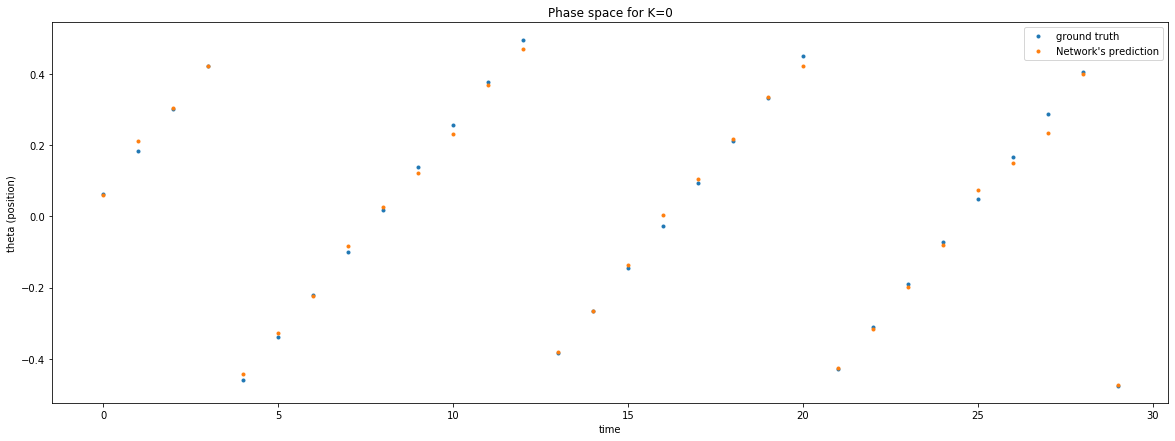

The test MSE is 0.00030162651500073736
The 84 NRMSE is 5.688325446144014


In [9]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 30, NRMSE=True)

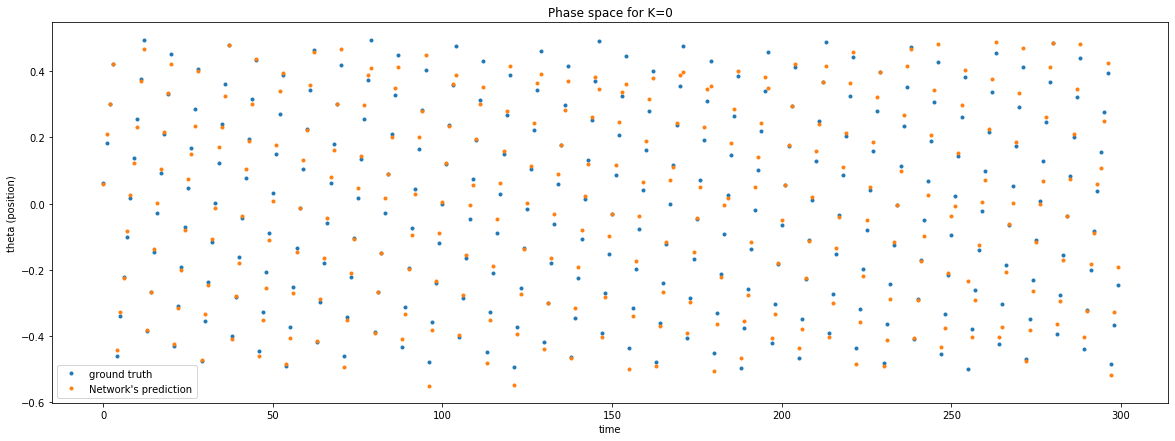

The test MSE is 0.0012109690966031854


In [10]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 300, NRMSE=False)

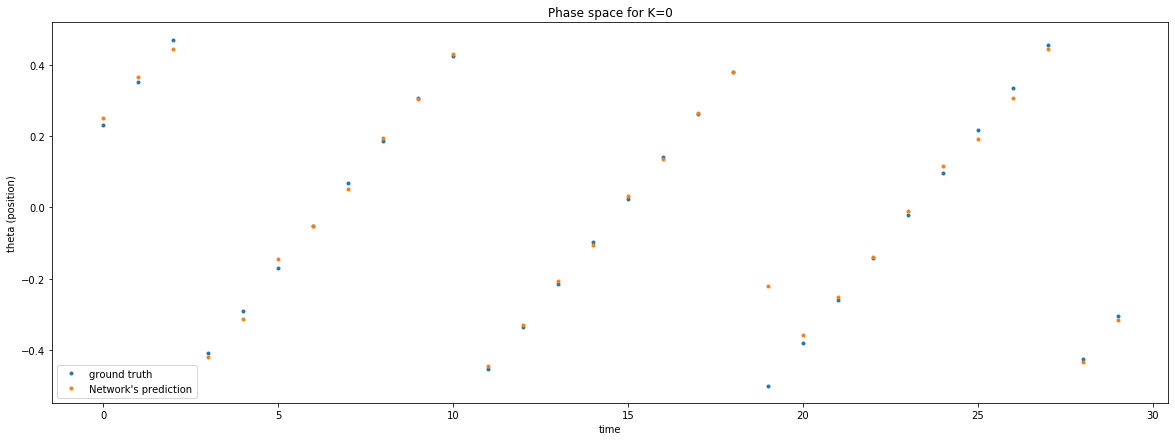

The test MSE is 0.0028063938096596856


In [11]:
#REPLICATE
Network.test_network(t_dismiss=2000, t_autonom = 30, NRMSE=False)

### Different initial conditions


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


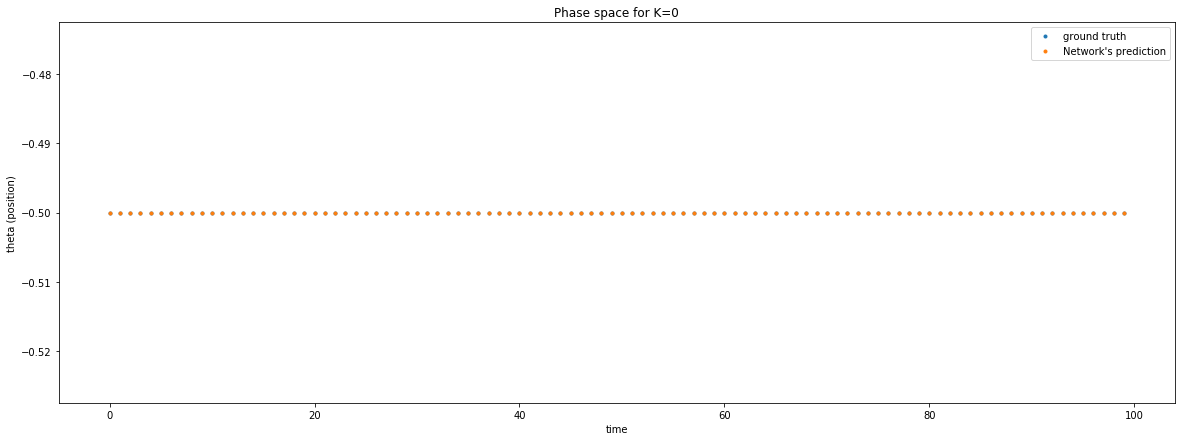

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:369: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 9.838320763502051e-06


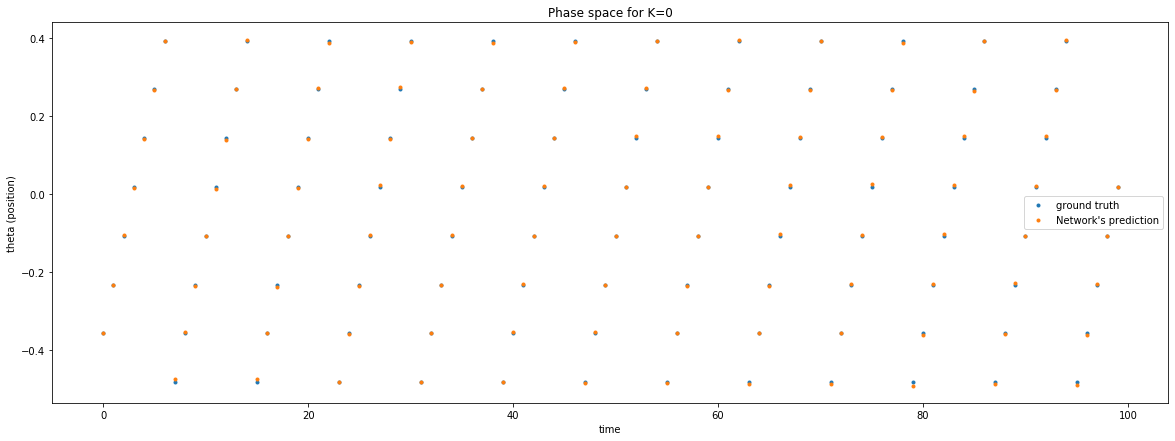

The test MSE is 1.178434342828392e-05
The 84 NRMSE is 0.6525803753051238

Initial condition ic=[0, 0.9]

The training MSE is 0.0010970959157368407


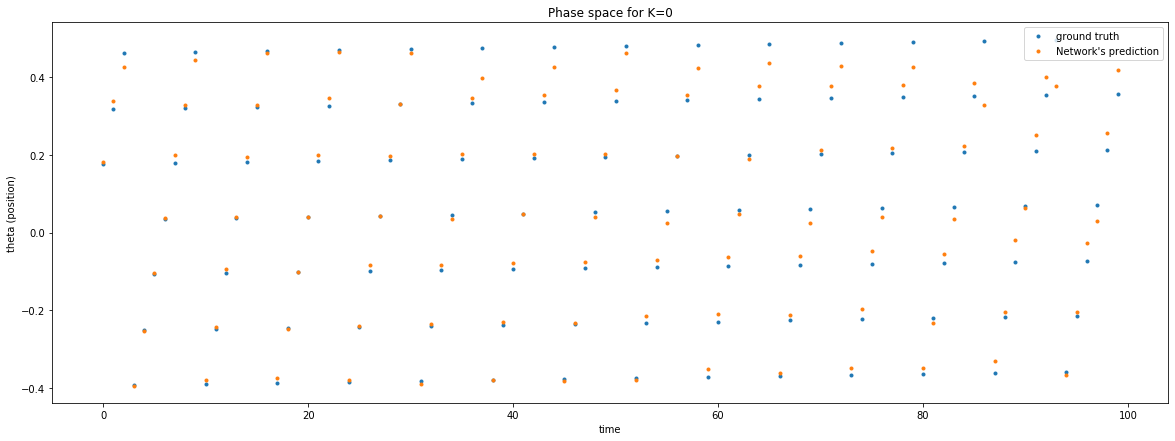

The test MSE is 0.0010350666581664893
The 84 NRMSE is 10.147336070533463

Initial condition ic=[0.9, 0]

The training MSE is 0.0


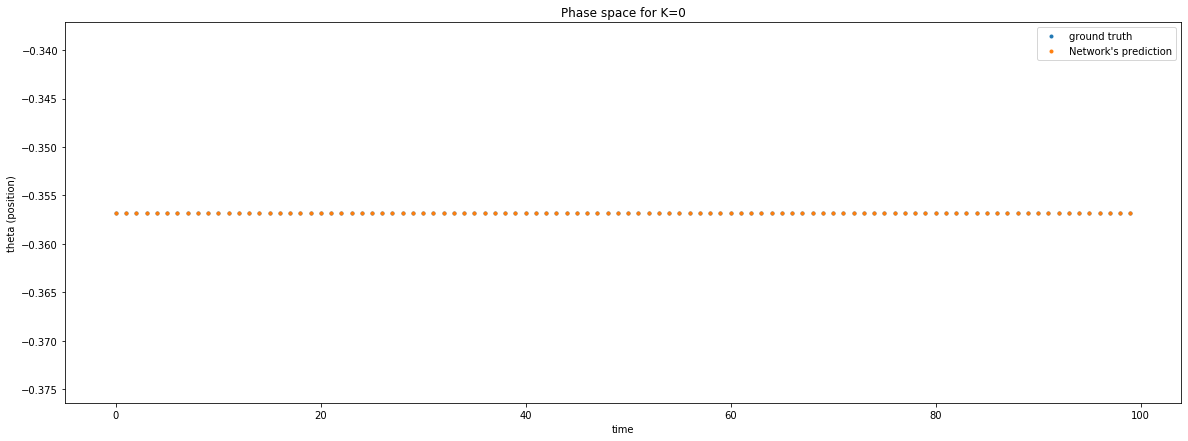

The test MSE is 0.0
The 84 NRMSE is 0.0

Initial condition ic=[0.5, 3]

The training MSE is 0.0011845671489263596


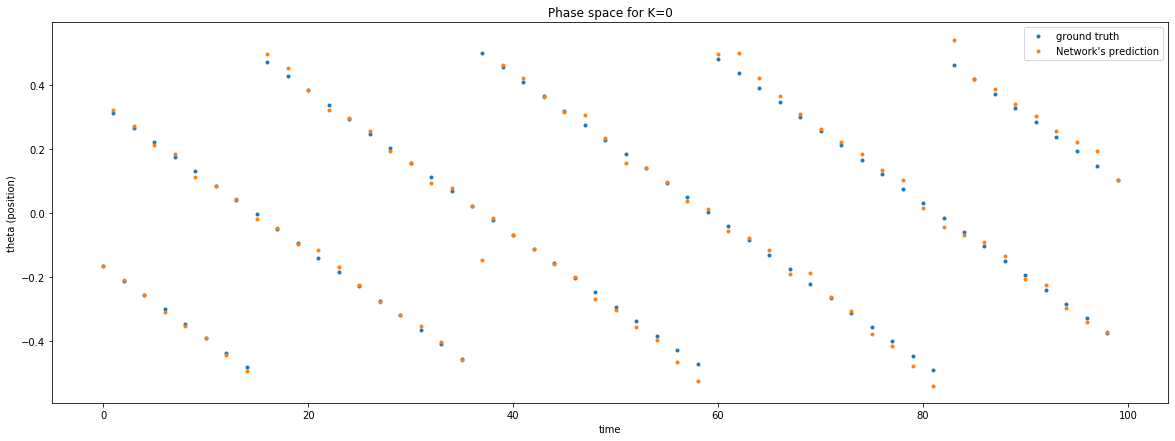

The test MSE is 0.00455642996201362
The 84 NRMSE is 2.904093832006099

Initial condition ic=[1, 3.5]

The training MSE is 0.0007972244770484802


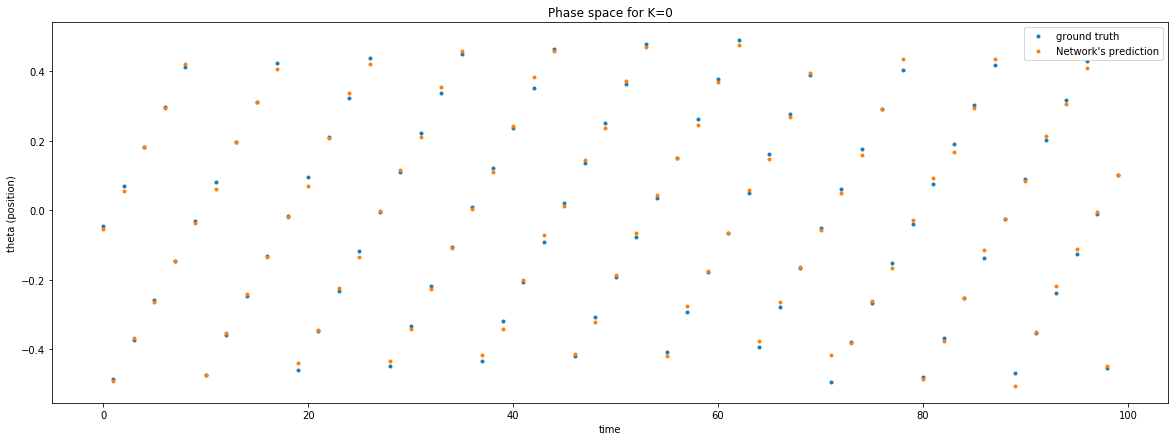

The test MSE is 0.0002235884499992093
The 84 NRMSE is 1.4838156159118323

Initial condition ic=[1, 1.2]

The training MSE is 0.0008378742479938138


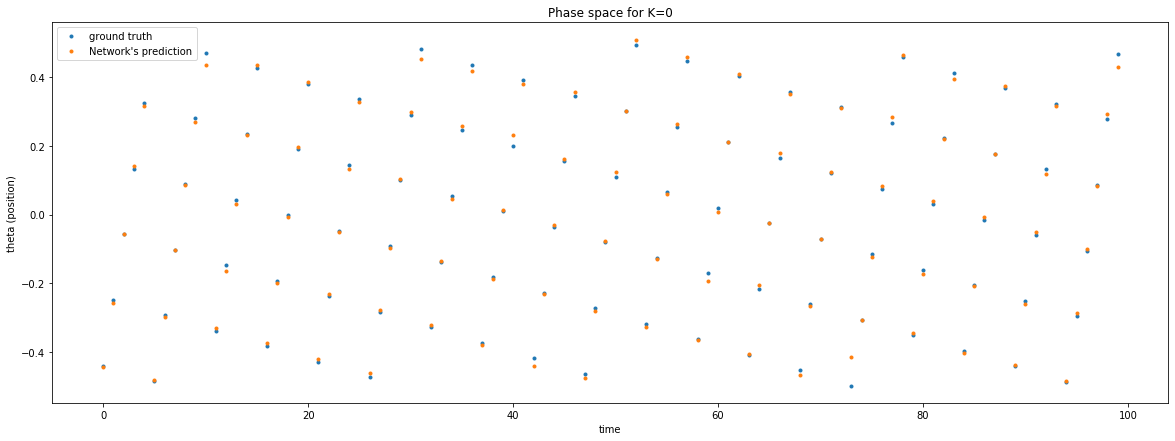

The test MSE is 0.00019215742226168808
The 84 NRMSE is 4.197561500975698


In [12]:
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

# 1.2 K=0.1 <a name="tK01" ></a>

### Illustrative case

In [13]:
Network.InitialCondition_ODE = [0, 0.75]
Network.kick = 0.1

In [14]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 1
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

In [15]:
Network.non_null_matrices = ["W_back", "W_in"]

In [16]:
#TRAIN
Network.train_network(noise=True, stDev=0.001, regression_type='Ridge', regression_param=10) 

The training MSE is 0.0026042109895090503


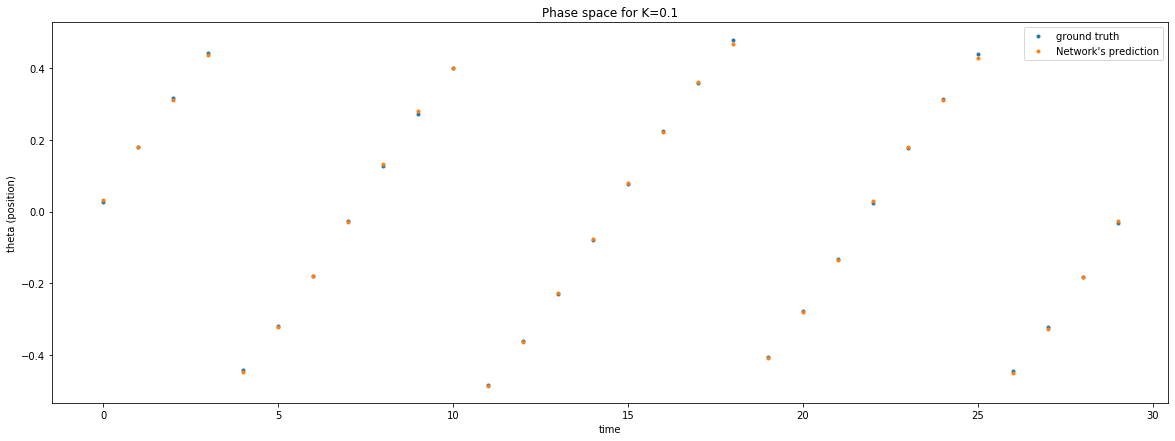

The test MSE is 2.4865754031907134e-05
The 84 NRMSE is 17.297065077912634


In [17]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 30, NRMSE=True)

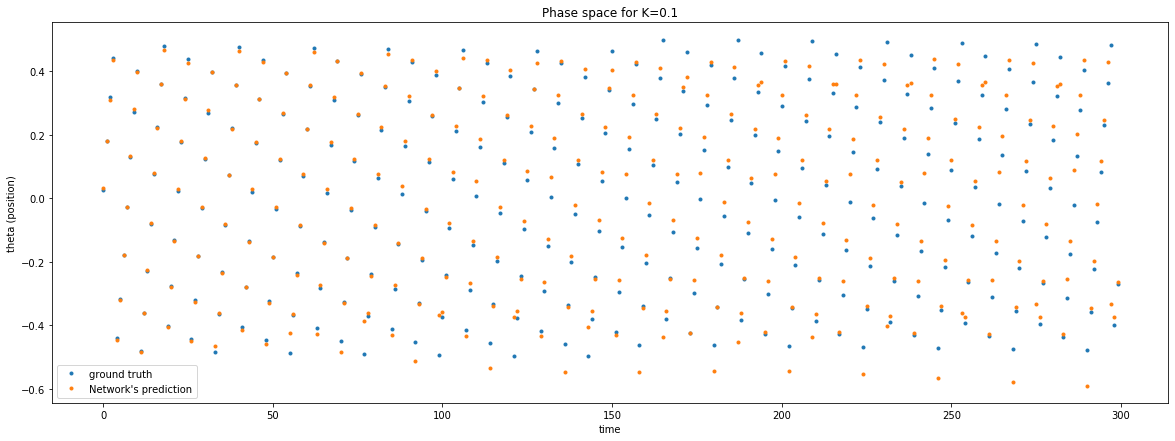

The test MSE is 0.019607938901415992


In [18]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 300, NRMSE=False)

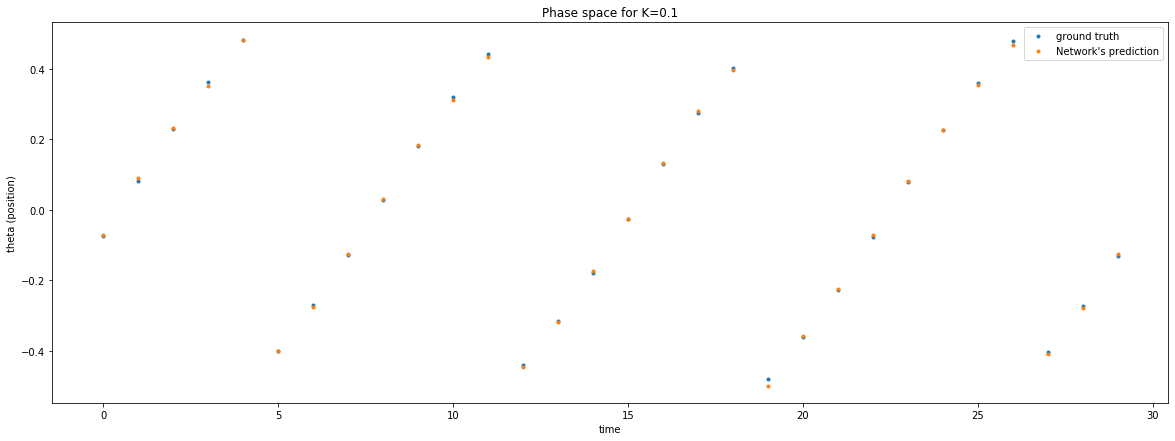

The test MSE is 3.808533263289712e-05


In [19]:
#REPLICATE
Network.test_network(t_dismiss=2000, t_autonom = 30, NRMSE=False)

### Different initial conditions


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


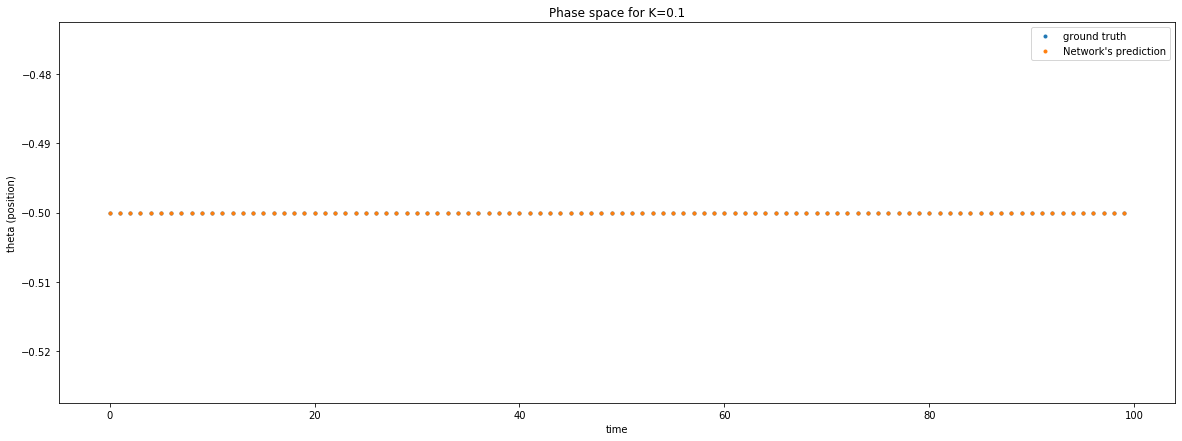

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:369: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 0.0018152140719042288


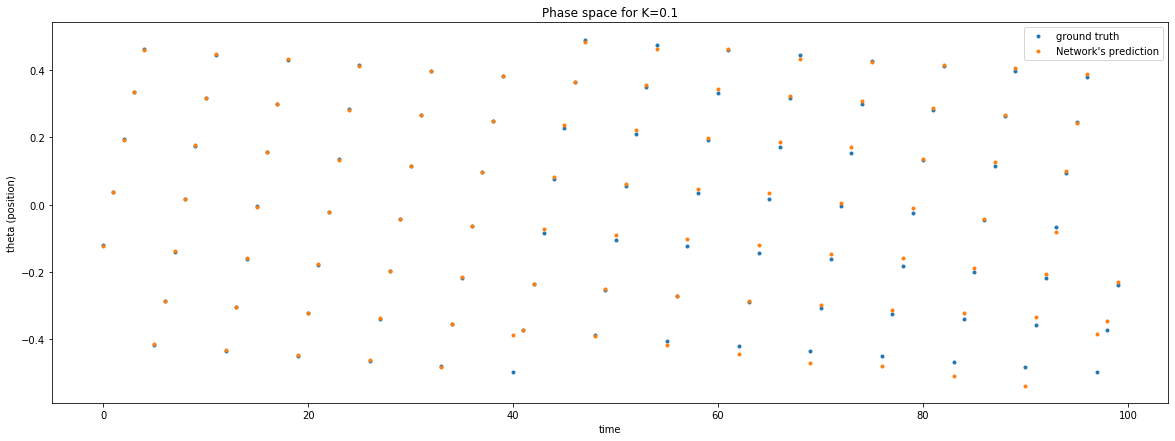

The test MSE is 0.0004002978518774135
The 84 NRMSE is 3.4030619062786847

Initial condition ic=[0, 0.9]

The training MSE is 0.0031879729149975056


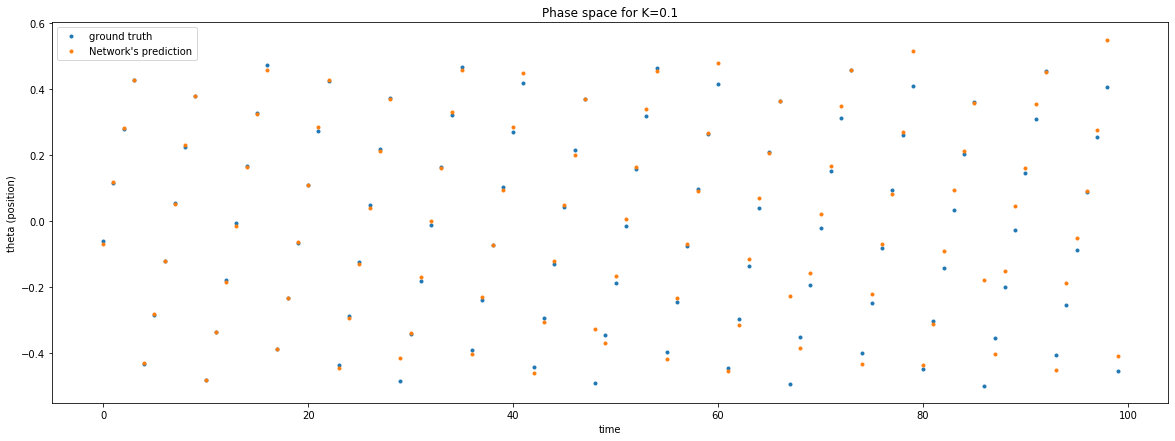

The test MSE is 0.002855422850866278
The 84 NRMSE is 23.839864890910945

Initial condition ic=[0.9, 0]

The training MSE is 9.535871590423054e-08


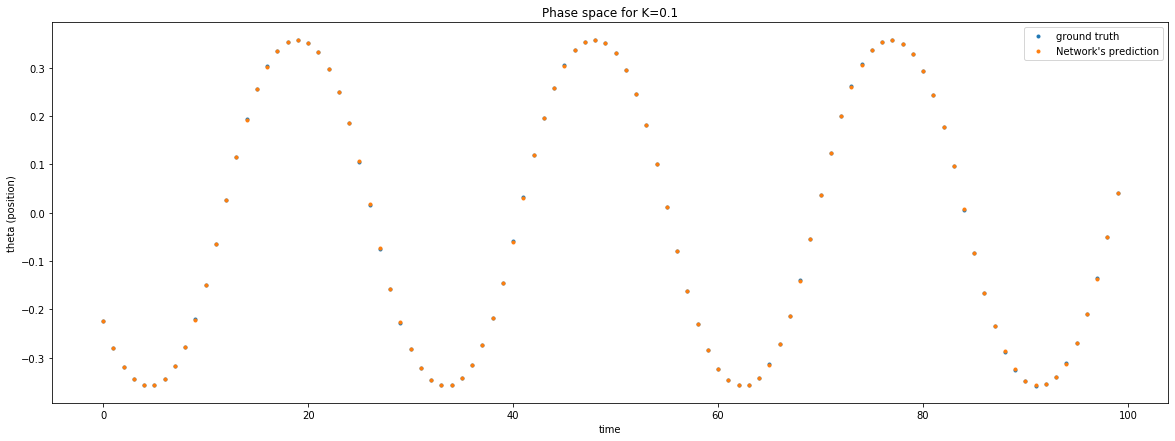

The test MSE is 2.1983934970906175e-07
The 84 NRMSE is 0.016916444312278605

Initial condition ic=[0.5, 3]

The training MSE is 0.0012852848411106306


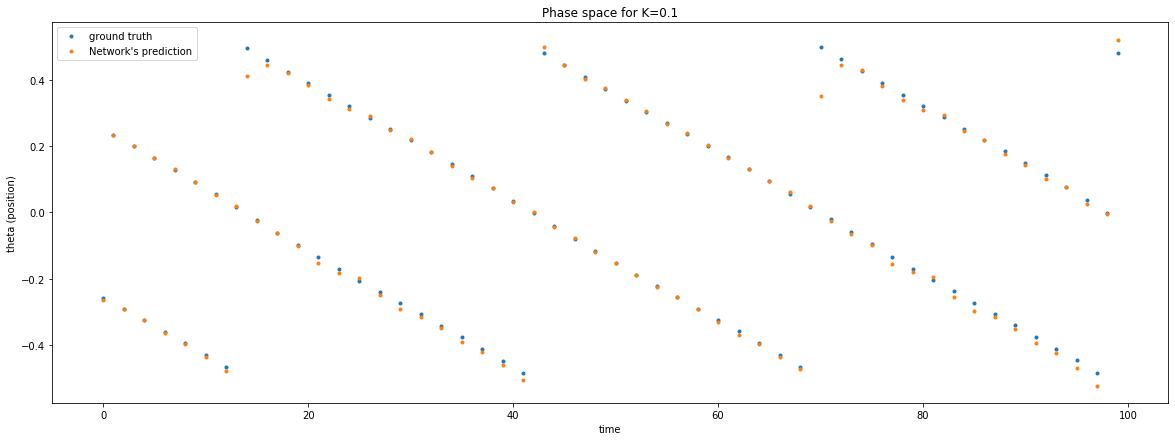

The test MSE is 0.00040125769796070954
The 84 NRMSE is 18.77300696065769

Initial condition ic=[1, 3.5]

The training MSE is 0.0012735067909121673


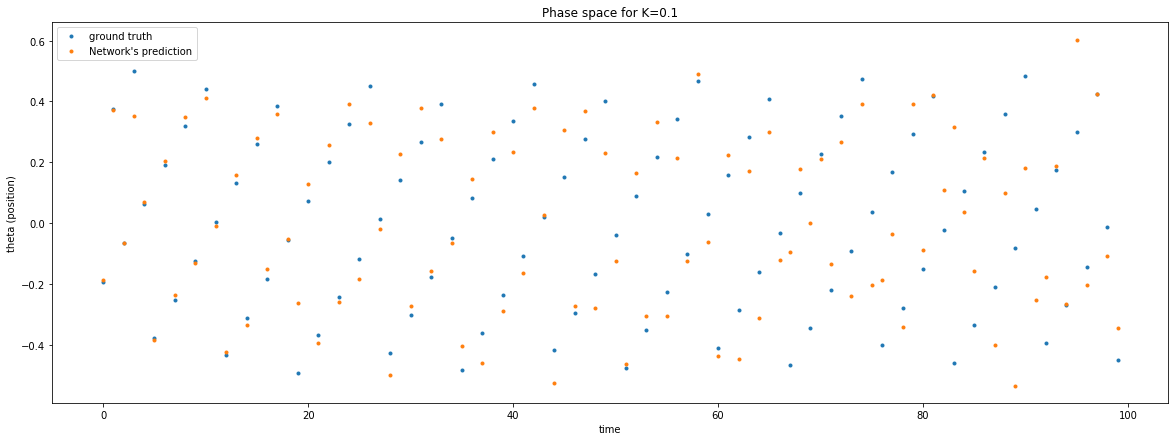

The test MSE is 0.022163394535374966
The 84 NRMSE is 22.012357632099647

Initial condition ic=[1, 1.2]

The training MSE is 0.0027623410530165336


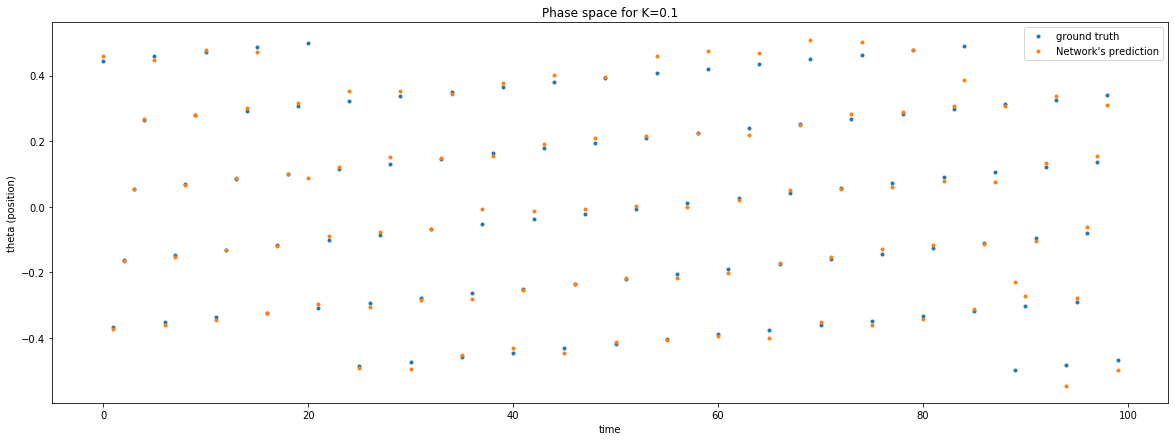

The test MSE is 0.0028601541009831526
The 84 NRMSE is 11.460689538071643


In [20]:
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.1, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

# 1.3 K=0.25 <a name="tK025" ></a>

### Illustrative example

In [68]:
Network.InitialCondition_ODE = [0, 0.75]
Network.kick = 0.25

In [69]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 1
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

In [70]:
Network.non_null_matrices = ["W_back", "W_in"]

In [71]:
#TRAIN
Network.train_network(noise=True, stDev=0.001, regression_type='Ridge', regression_param=10) 

The training MSE is 0.000986007934299511


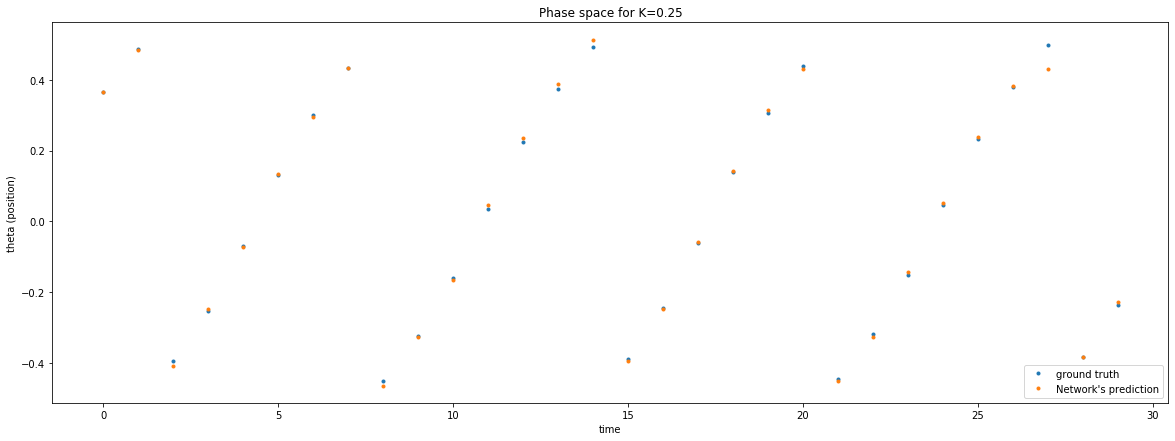

The test MSE is 0.00021206966122558623
The 84 NRMSE is 1.5746456724809397


In [72]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 30, NRMSE=True)

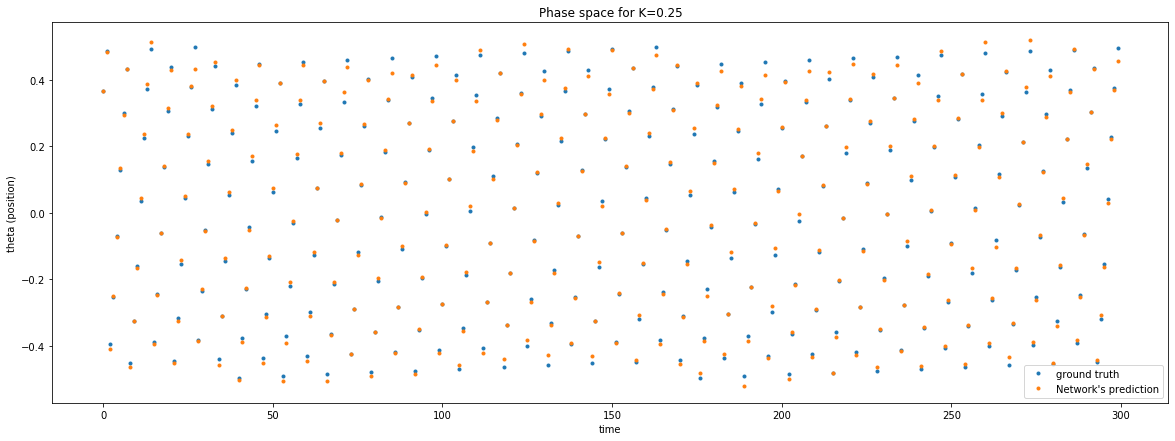

The test MSE is 0.00015309083522029653


In [73]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 300, NRMSE=False)

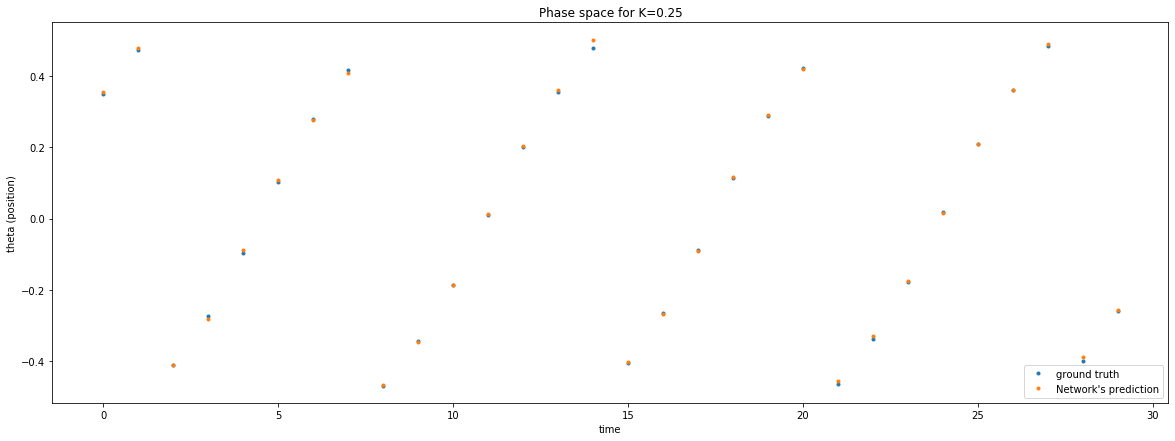

The test MSE is 4.1613993205899146e-05


In [74]:
#REPLICATE
Network.test_network(t_dismiss=2000, t_autonom = 30, NRMSE=False)

### Different initial conditions


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


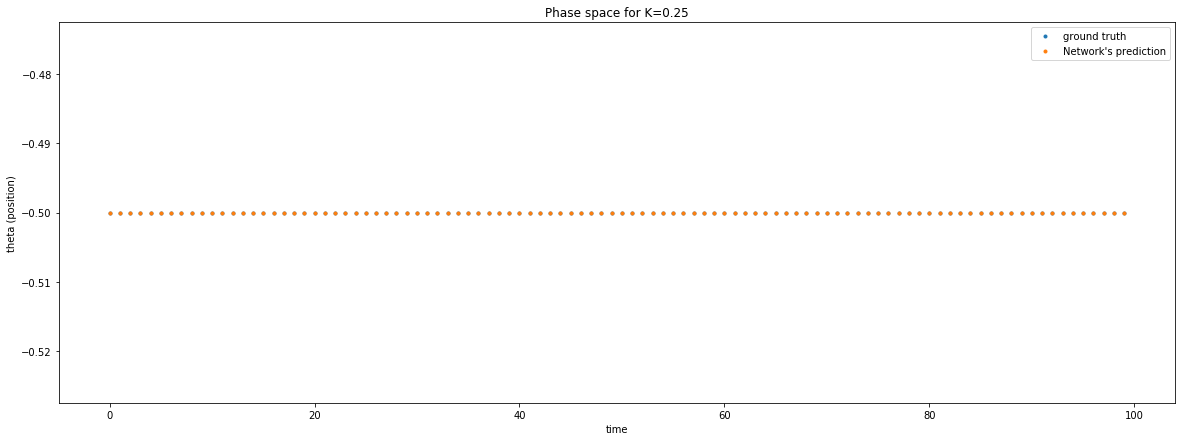

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:369: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 0.0008426224354127618


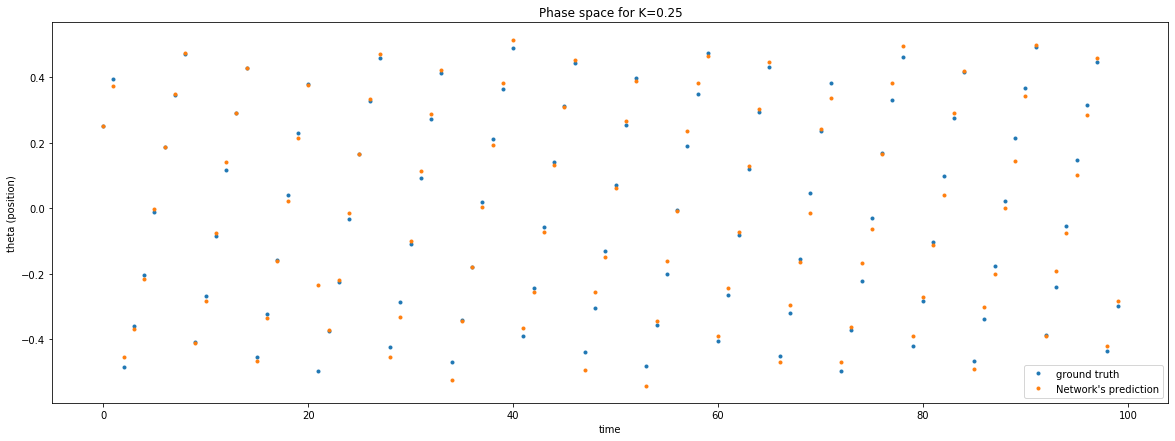

The test MSE is 0.0013599433808380002
The 84 NRMSE is 2.5318048211001587

Initial condition ic=[0, 0.9]

The training MSE is 0.0006571969848530752


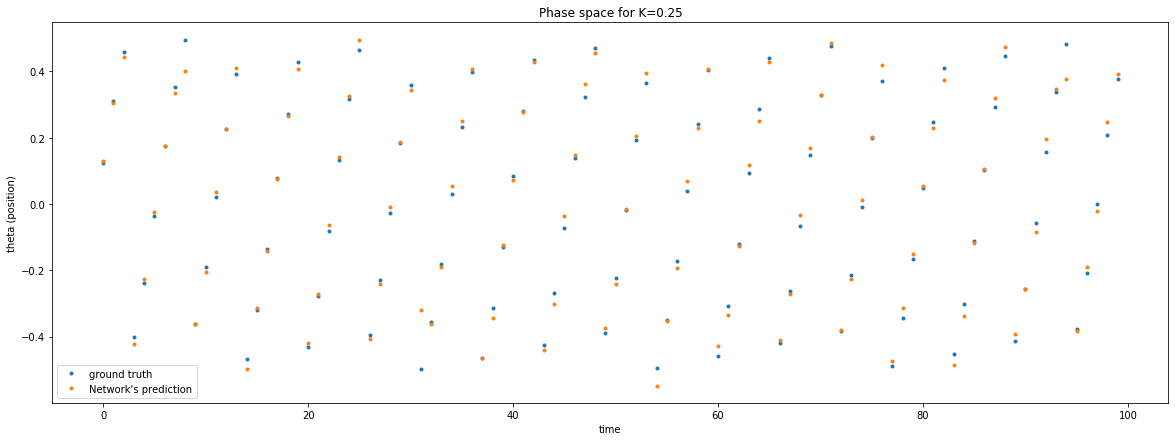

The test MSE is 0.0009213056961564843
The 84 NRMSE is 3.039300833415242

Initial condition ic=[0.9, 0]

The training MSE is 3.2020154297094884e-07


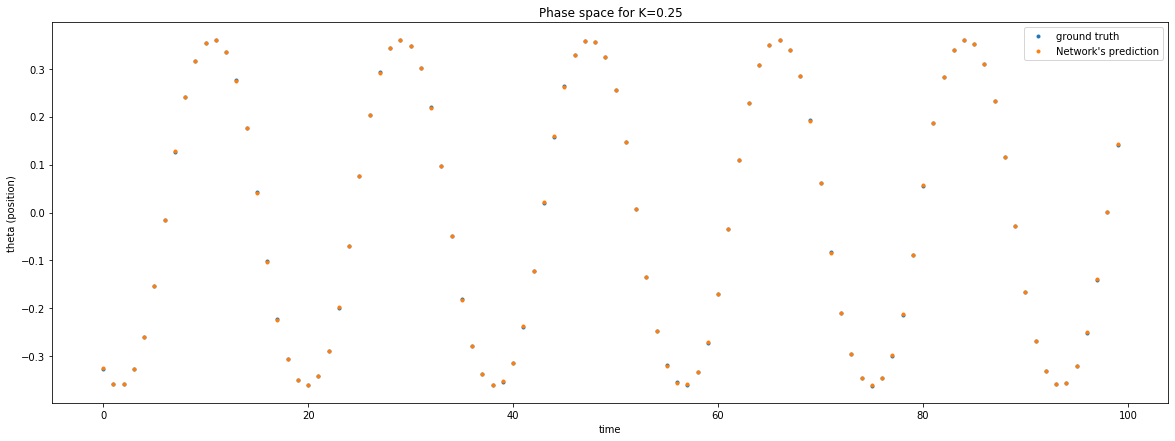

The test MSE is 3.1841100432290436e-07
The 84 NRMSE is 0.07927098577524298

Initial condition ic=[0.5, 3]

The training MSE is 0.0012017530041340727


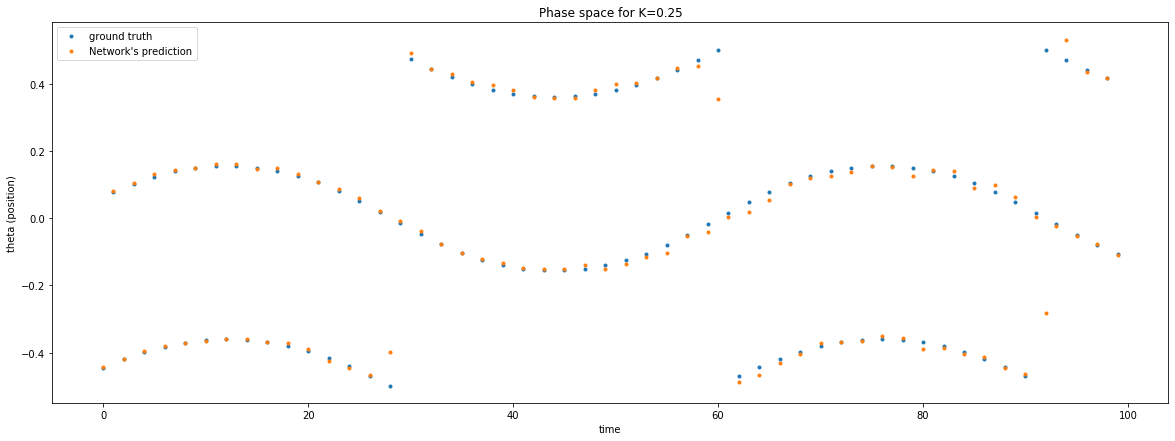

The test MSE is 0.006539583461450027
The 84 NRMSE is 1.731915170631832

Initial condition ic=[1, 3.5]

The training MSE is 0.0004855437740975734


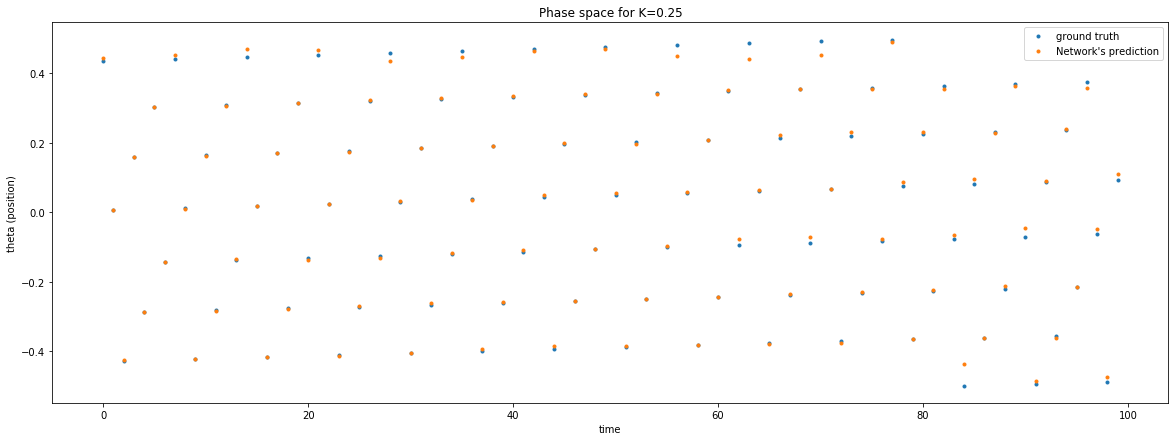

The test MSE is 0.00014291788198692333
The 84 NRMSE is 2.4742580658335016

Initial condition ic=[1, 1.2]

The training MSE is 0.0007852789352080697


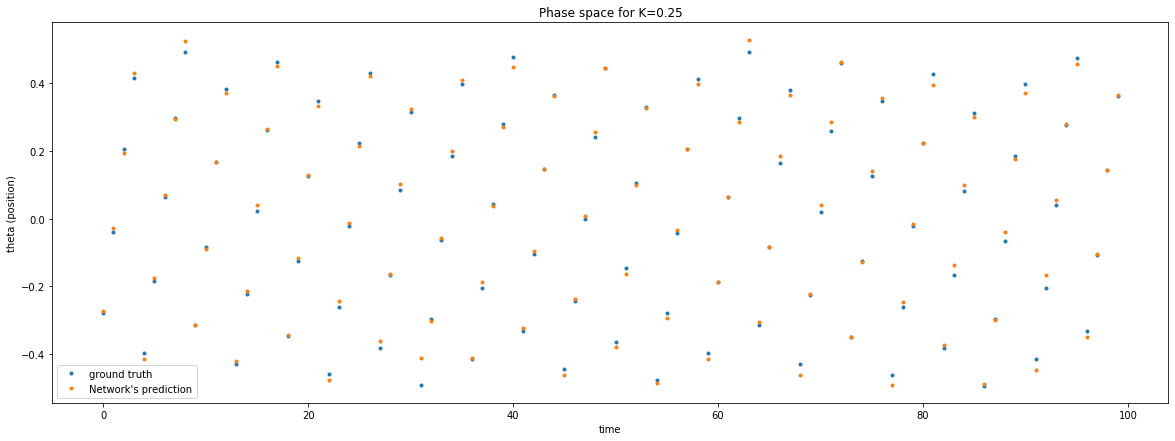

The test MSE is 0.00028230161420672963
The 84 NRMSE is 6.823686275653094


In [75]:
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.25, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

# 1.4 K=0.5, 0.75, 0.9 <a name="tKmult" ></a>

In [76]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 1
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


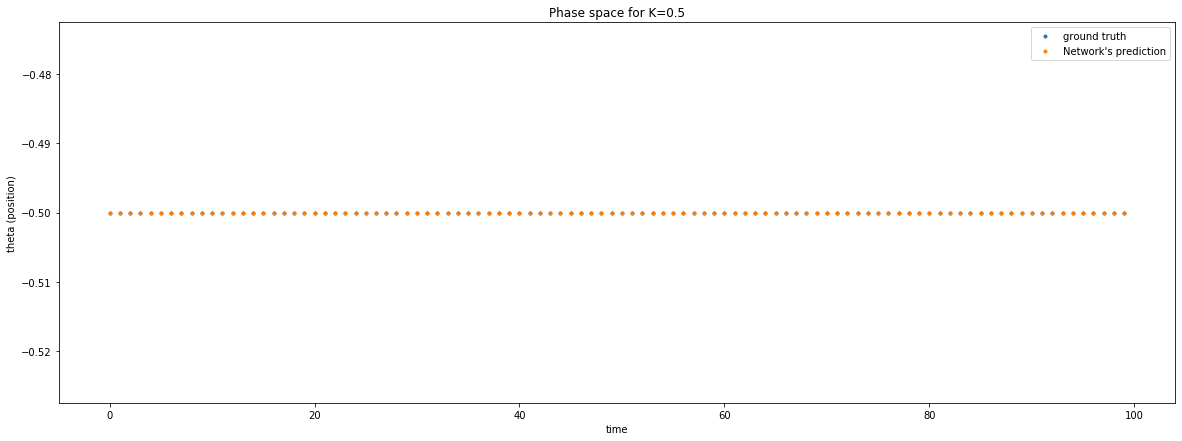

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:369: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 2.123814425424764e-06


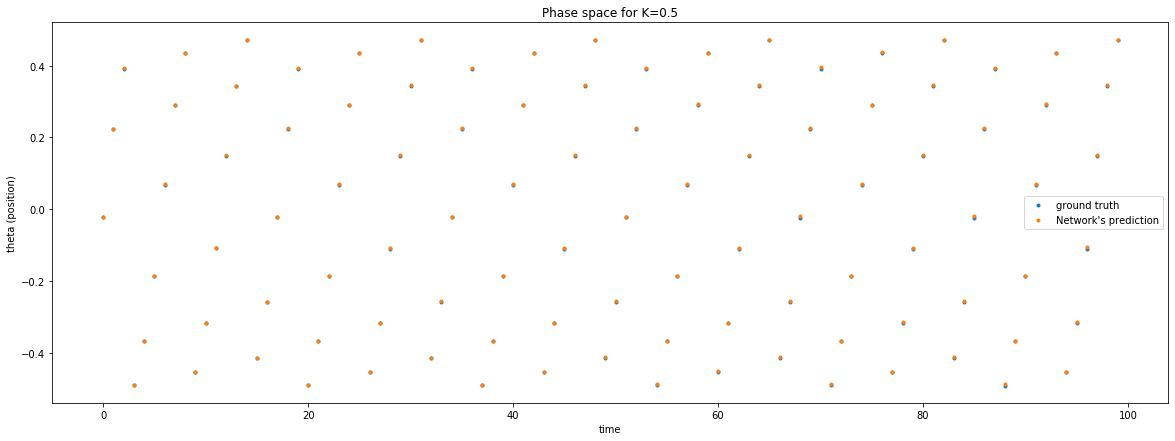

The test MSE is 4.5620904330662e-06
The 84 NRMSE is 0.3463244210498036

Initial condition ic=[0, 0.9]

The training MSE is 0.002060230770680814


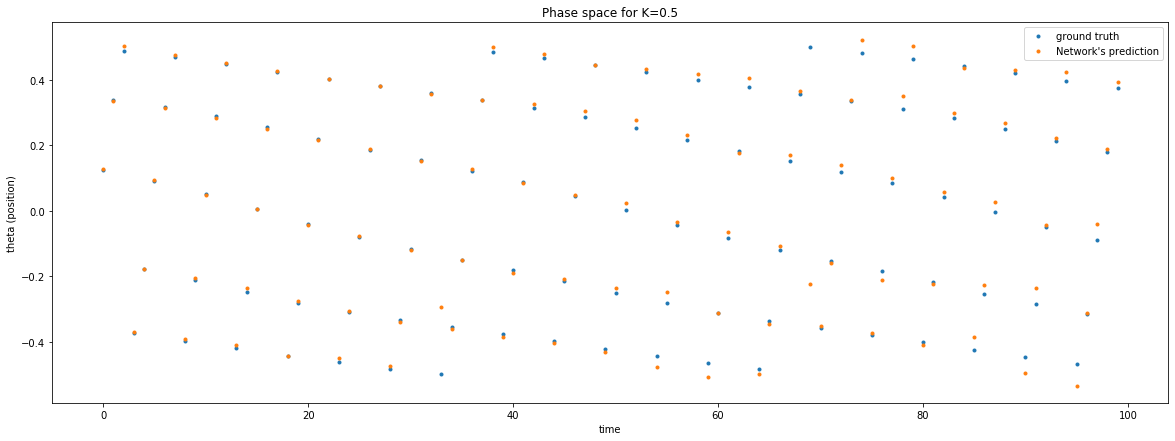

The test MSE is 0.005985180243074199
The 84 NRMSE is 2.6741972265442424

Initial condition ic=[0.9, 0]

The training MSE is 2.3620693507940129e-07


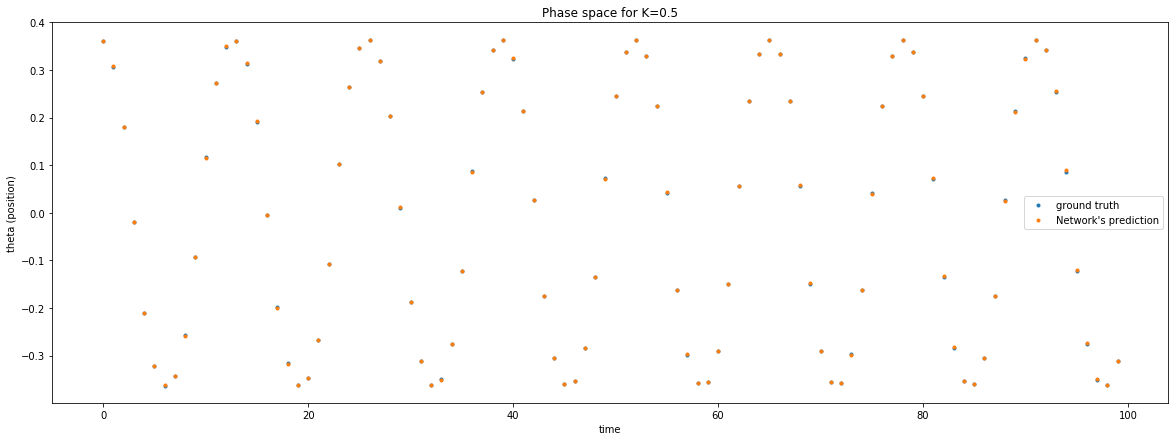

The test MSE is 8.156794186216347e-07
The 84 NRMSE is 0.10551439699970948

Initial condition ic=[0.5, 3]

The training MSE is 0.002139919384258988


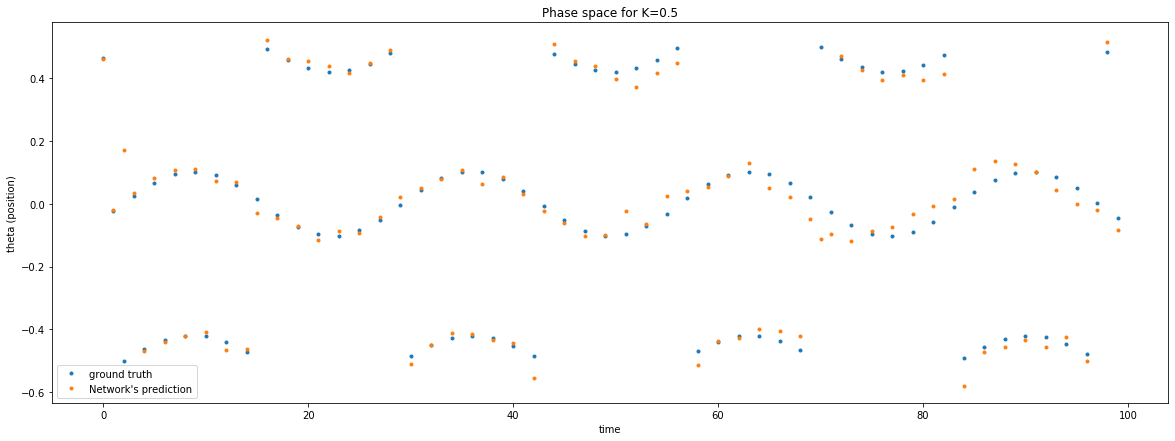

The test MSE is 0.009226971358315074
The 84 NRMSE is 3.840035114072077

Initial condition ic=[1, 3.5]

The training MSE is 0.001109823183192965


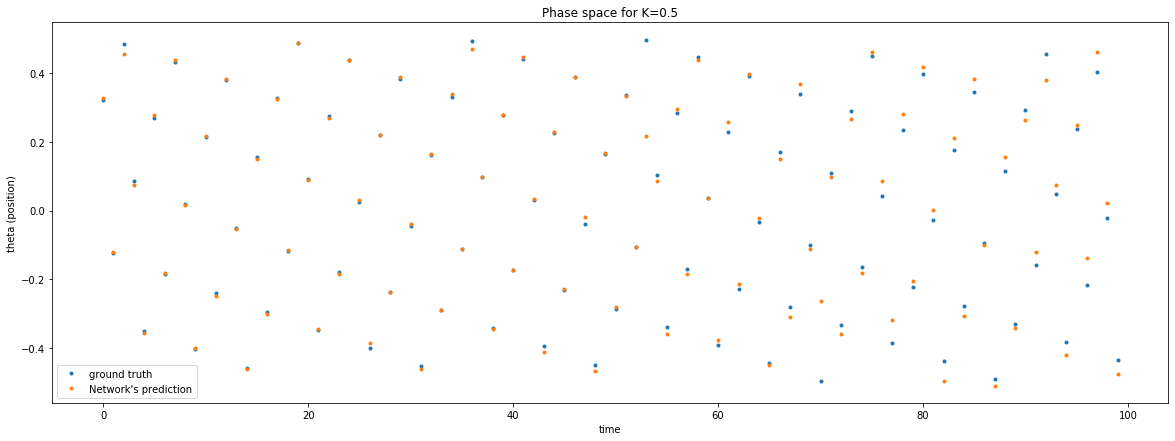

The test MSE is 0.001877645876712793
The 84 NRMSE is 5.099327573810639

Initial condition ic=[1, 1.2]

The training MSE is 0.0006586667660287849


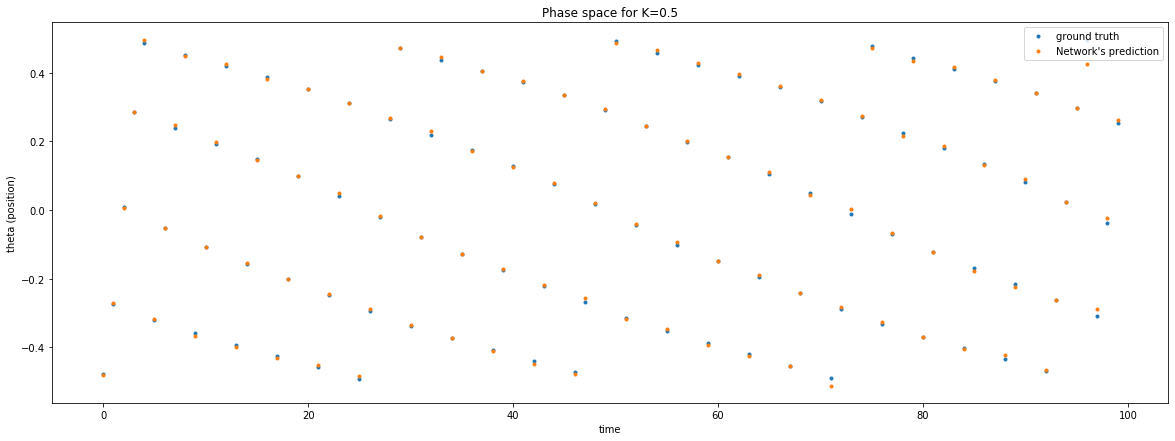

The test MSE is 8.45112357884738e-05
The 84 NRMSE is 2.1319120538476493


In [77]:
#K=0.5
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.5, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


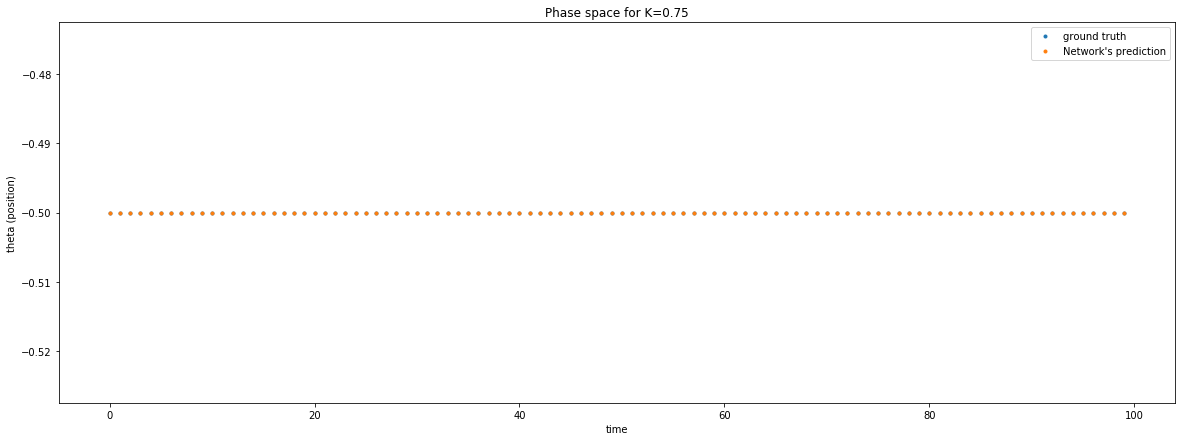

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:369: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 0.002342563101555915


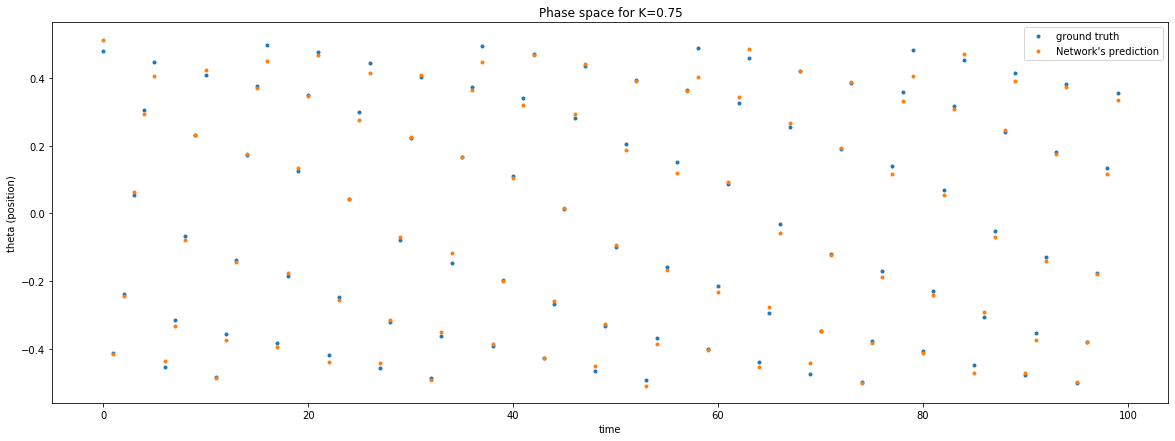

The test MSE is 0.0003806515899866634
The 84 NRMSE is 5.488755988860638

Initial condition ic=[0, 0.9]

The training MSE is 0.0020441218231031554


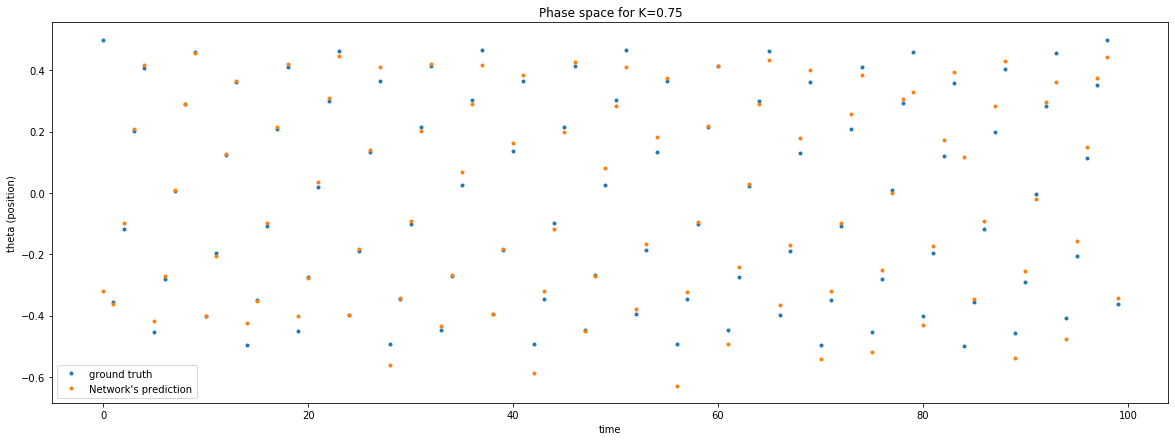

The test MSE is 0.01193598058443903
The 84 NRMSE is 4.9497159479493655

Initial condition ic=[0.9, 0]

The training MSE is 2.3893707848978805e-07


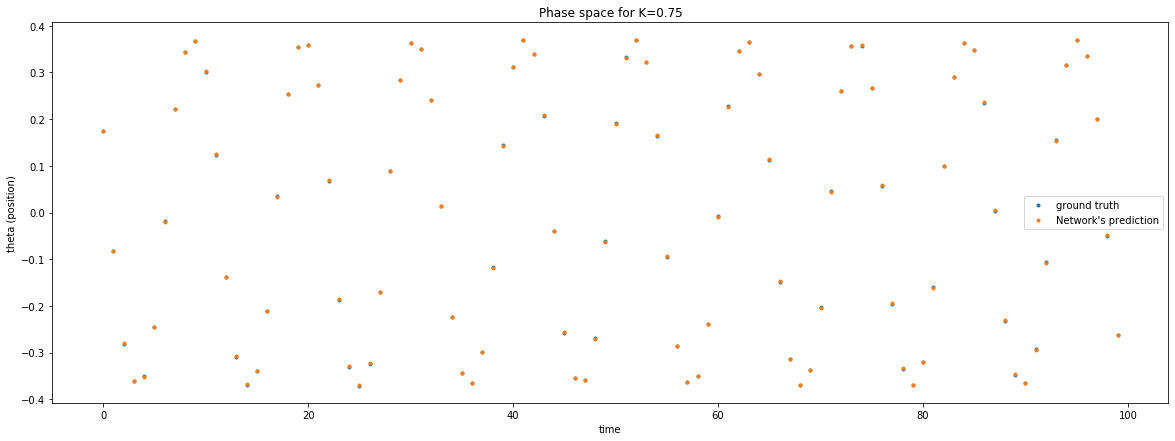

The test MSE is 1.1855148193518693e-06
The 84 NRMSE is 0.06715172228778003

Initial condition ic=[0.5, 3]

The training MSE is 0.0017570316065704972


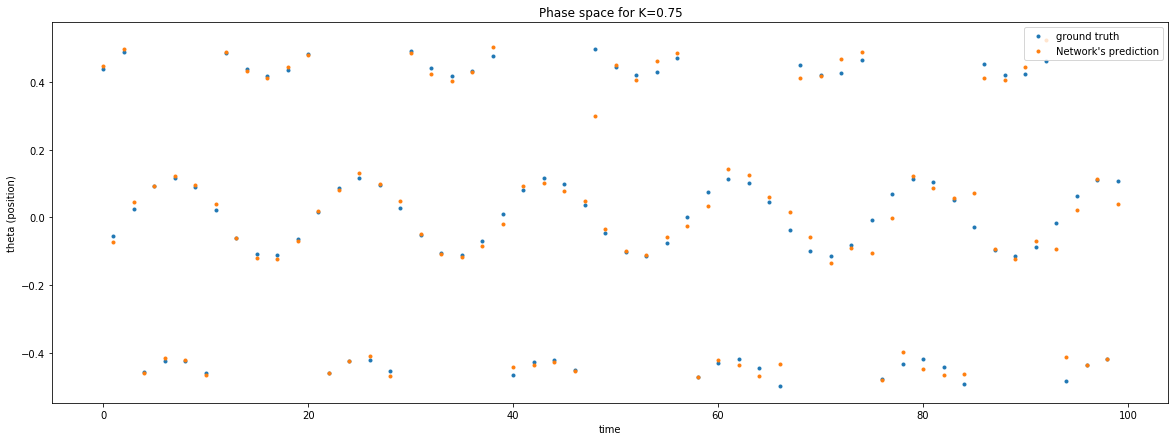

The test MSE is 0.0011755578511819284
The 84 NRMSE is 5.110080046001579

Initial condition ic=[1, 3.5]

The training MSE is 0.0021343390184913056


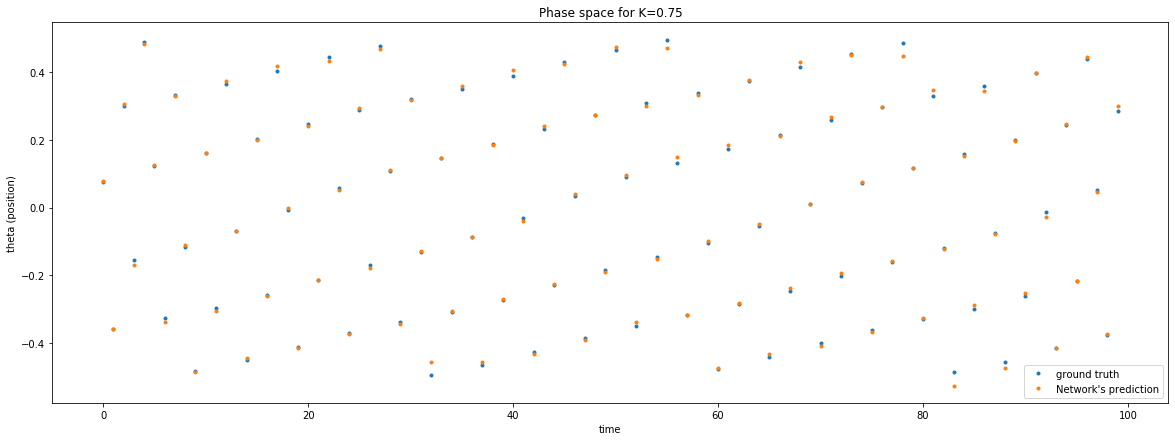

The test MSE is 0.00010330802175211252
The 84 NRMSE is 14.656794412080771

Initial condition ic=[1, 1.2]

The training MSE is 0.003102094614648422


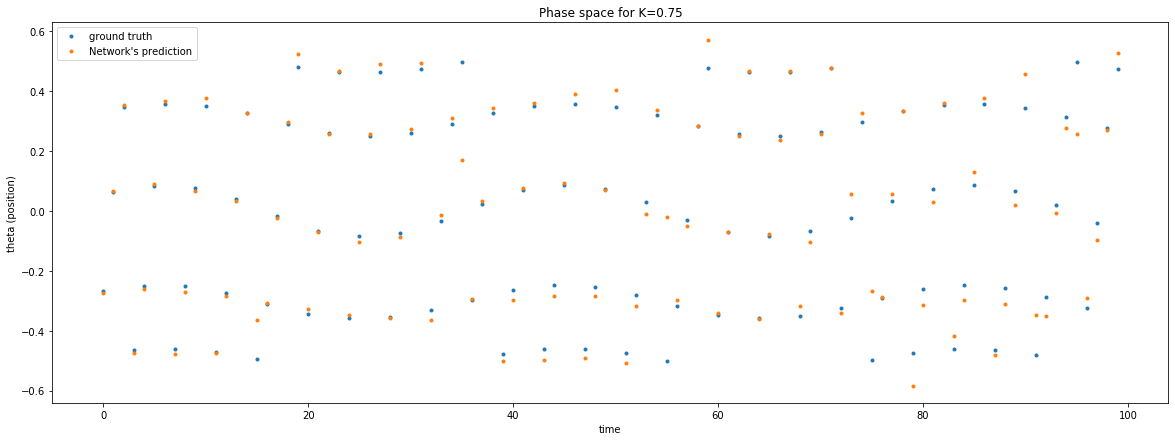

The test MSE is 0.0058025761404620945
The 84 NRMSE is 15.581582153111023


In [78]:
#K=0.75
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.75, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


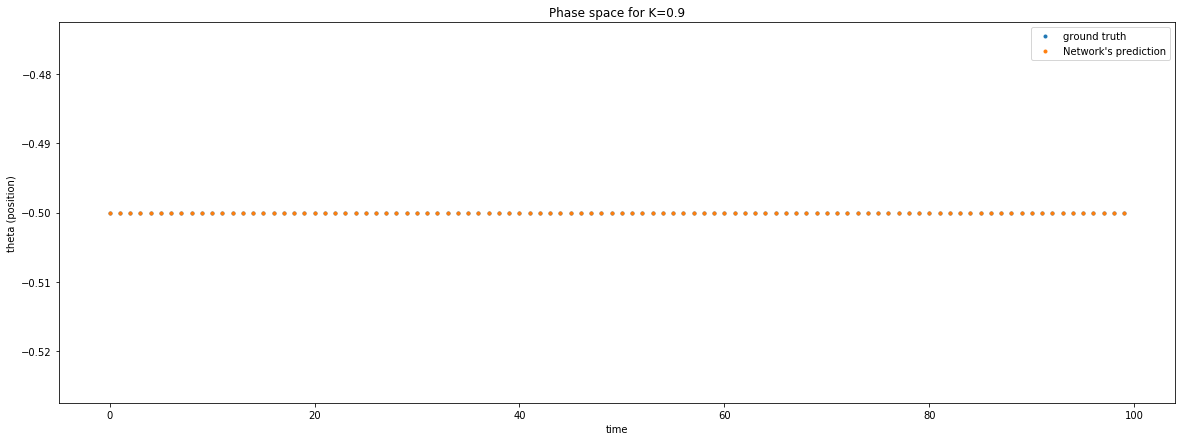

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:369: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 0.013208632172816448


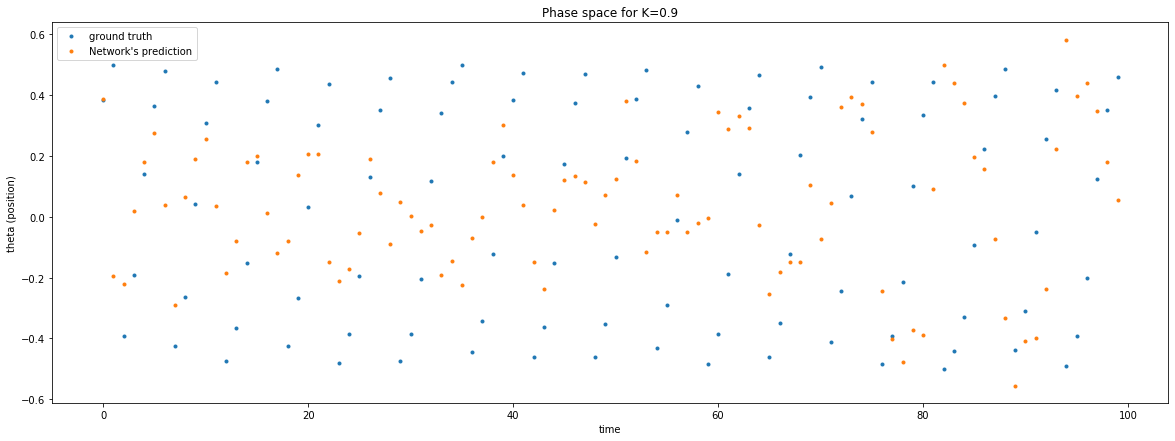

The test MSE is 0.16660311343597534
The 84 NRMSE is 56.31377980827184

Initial condition ic=[0, 0.9]

The training MSE is 0.018972303473309582


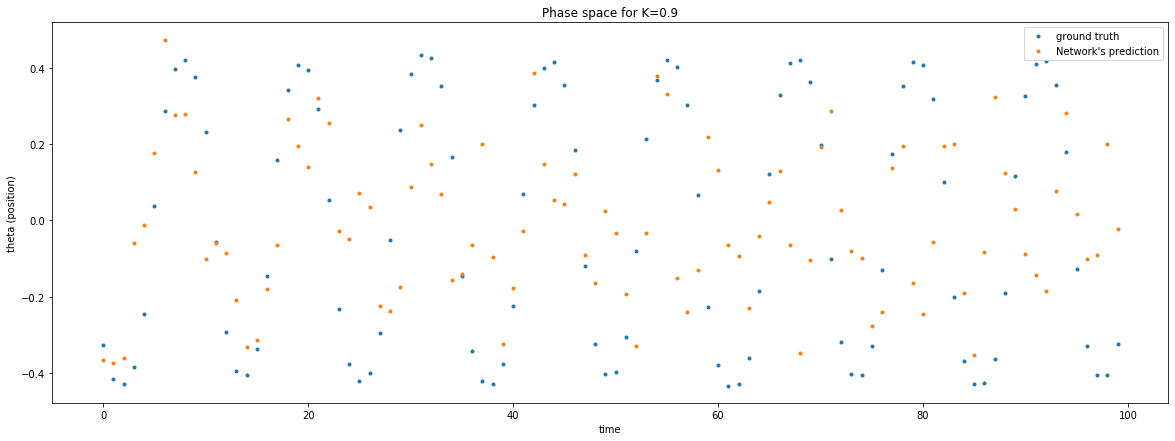

The test MSE is 0.09634168964134411
The 84 NRMSE is 50.092766897418535

Initial condition ic=[0.9, 0]

The training MSE is 9.245819966139733e-07


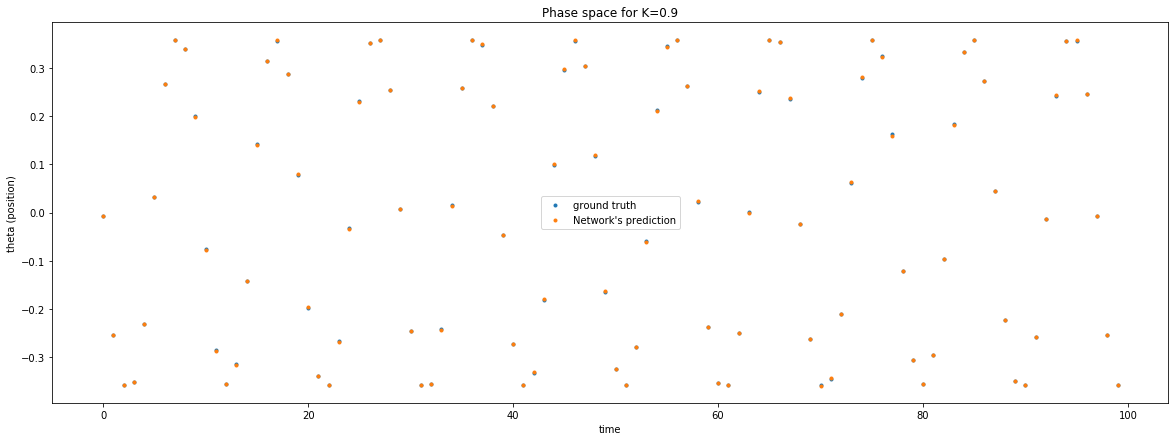

The test MSE is 1.2260354166962741e-06
The 84 NRMSE is 0.16796012762877768

Initial condition ic=[0.5, 3]

The training MSE is 0.0014086831797166673


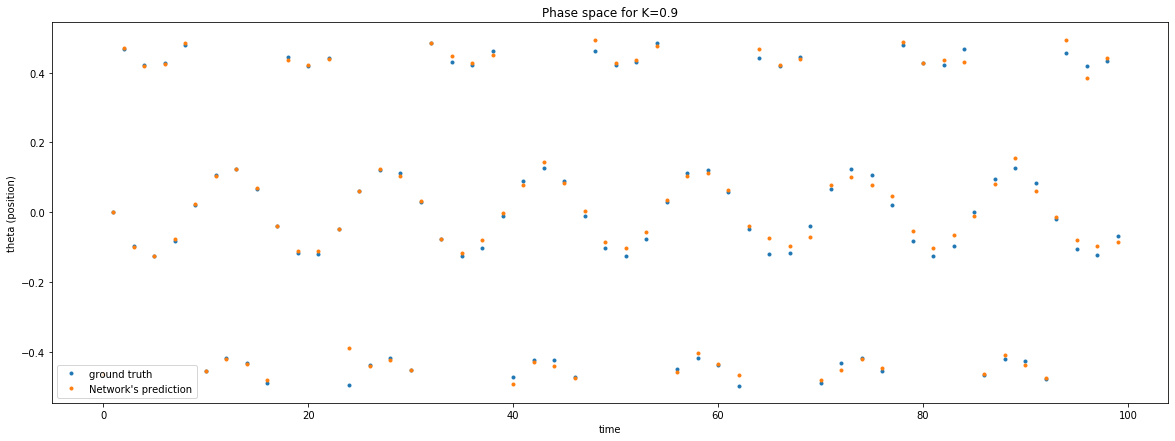

The test MSE is 0.00035266304183797457
The 84 NRMSE is 2.637770615099081

Initial condition ic=[1, 3.5]

The training MSE is 4.669804558304623e-06


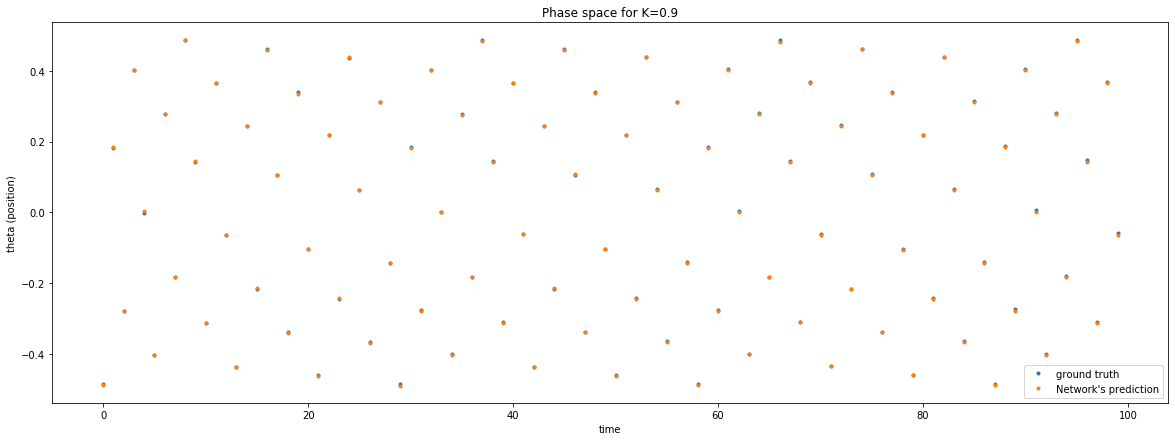

The test MSE is 5.194270298715028e-06
The 84 NRMSE is 0.32267509825738666

Initial condition ic=[1, 1.2]

The training MSE is 0.013244912324186021


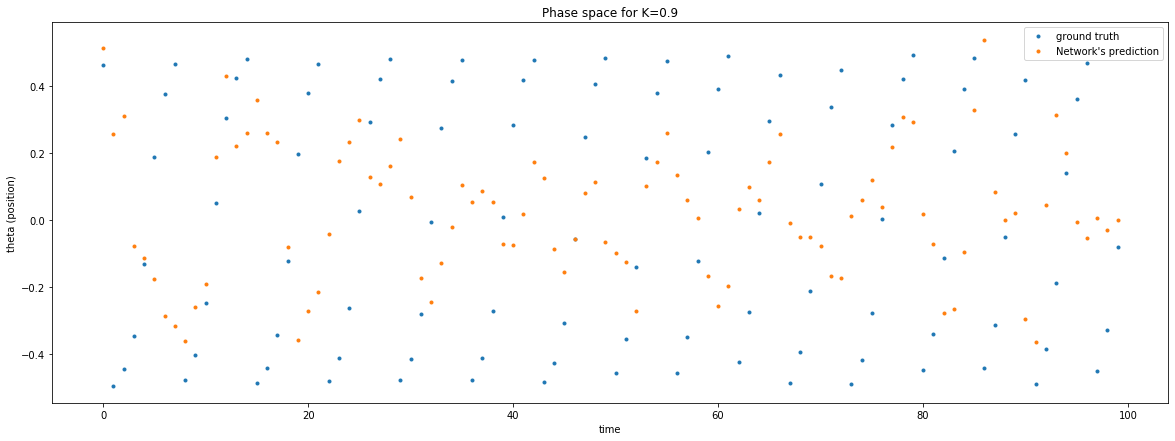

The test MSE is 0.17261723190305608
The 84 NRMSE is 47.62021826278032


In [79]:
#K=0.9
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.9, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

# 1.5 Chaotic behavior <a name="tKchaos" ></a>

## K=1.2

In [88]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 1
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


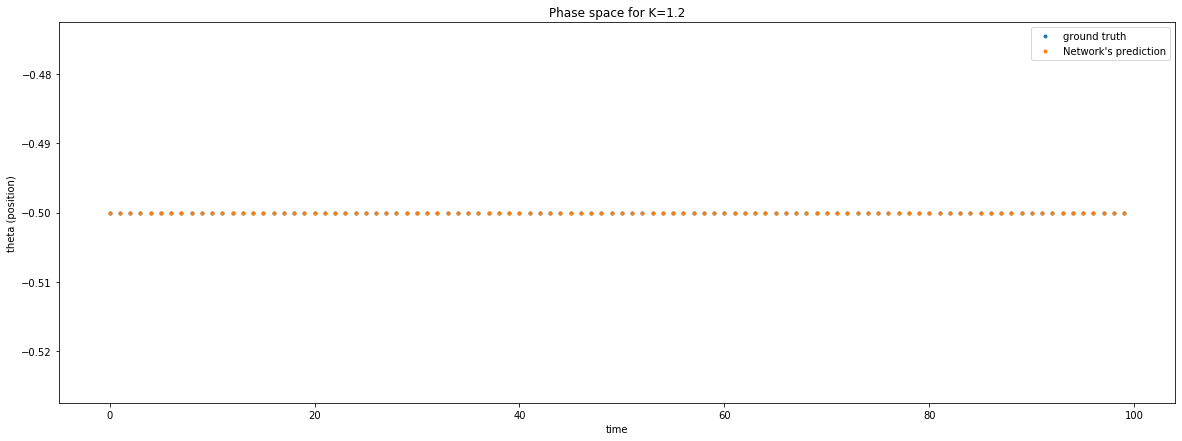

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:369: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 0.02703273473540357


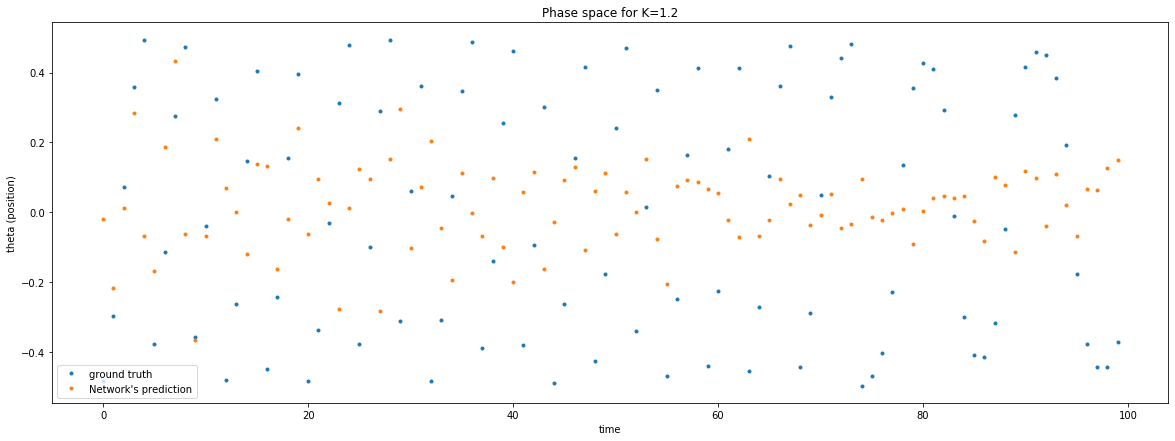

The test MSE is 0.13881725980254842
The 84 NRMSE is 48.8440765002746

Initial condition ic=[0, 0.9]

The training MSE is 0.0275838957860382


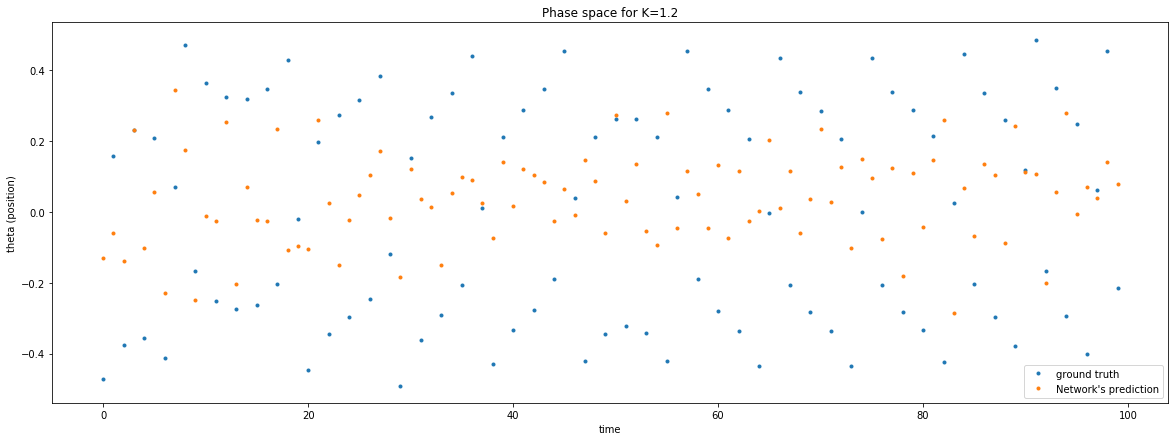

The test MSE is 0.09431186318654361
The 84 NRMSE is 53.486964453152105

Initial condition ic=[0.9, 0]

The training MSE is 4.555447669603278e-06


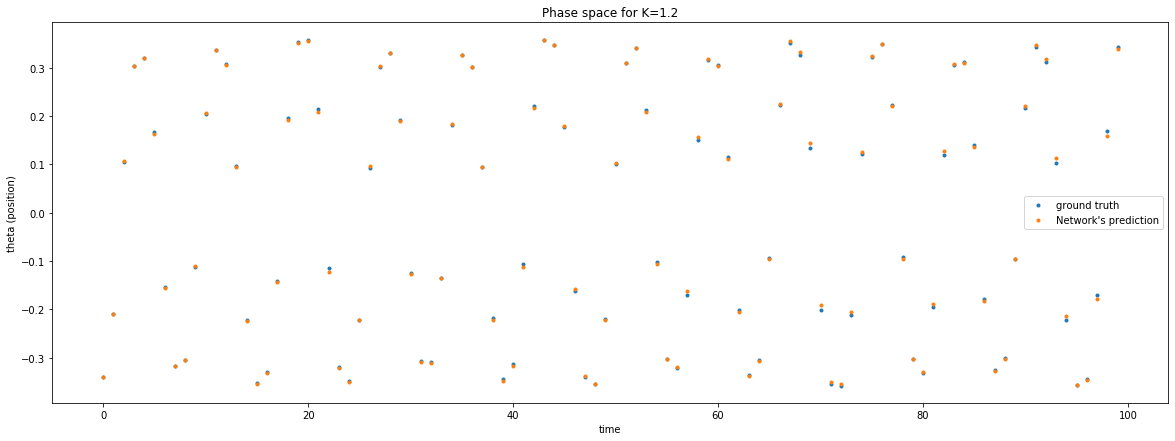

The test MSE is 1.543144005435077e-05
The 84 NRMSE is 0.5177069972471398

Initial condition ic=[0.5, 3]

The training MSE is 0.004744396679030797


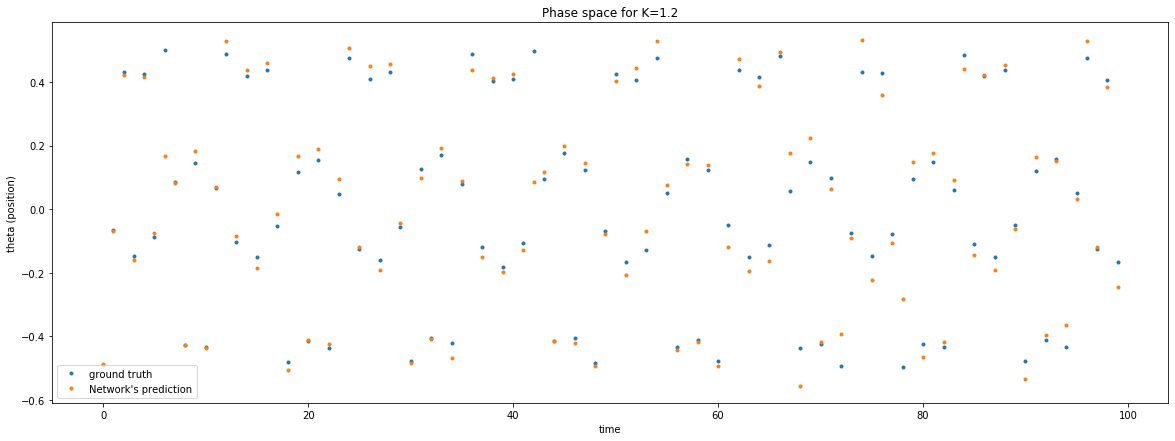

The test MSE is 0.004763054790019071
The 84 NRMSE is 6.41989958258801

Initial condition ic=[1, 3.5]

The training MSE is 6.914225601253595e-06


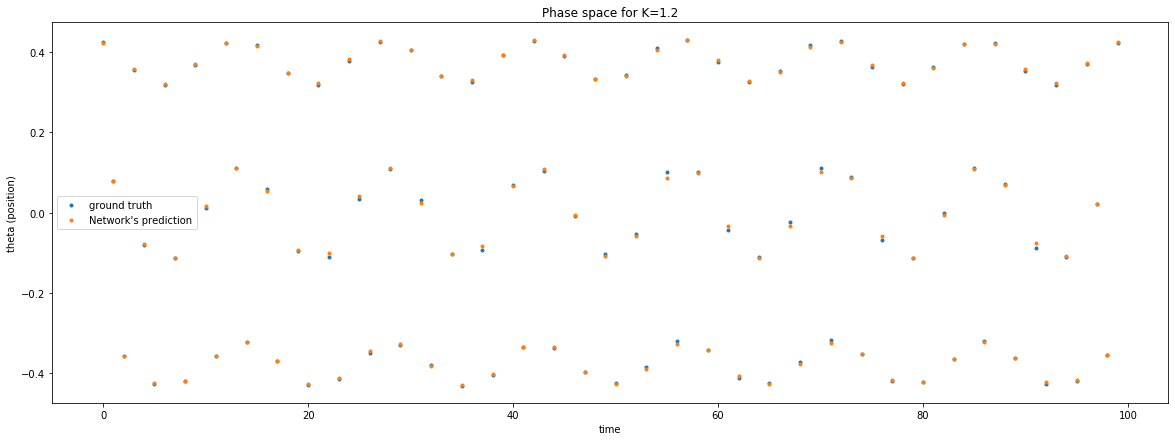

The test MSE is 1.9408272992458593e-05
The 84 NRMSE is 1.2823925680454038

Initial condition ic=[1, 1.2]

The training MSE is 0.02828142067869179


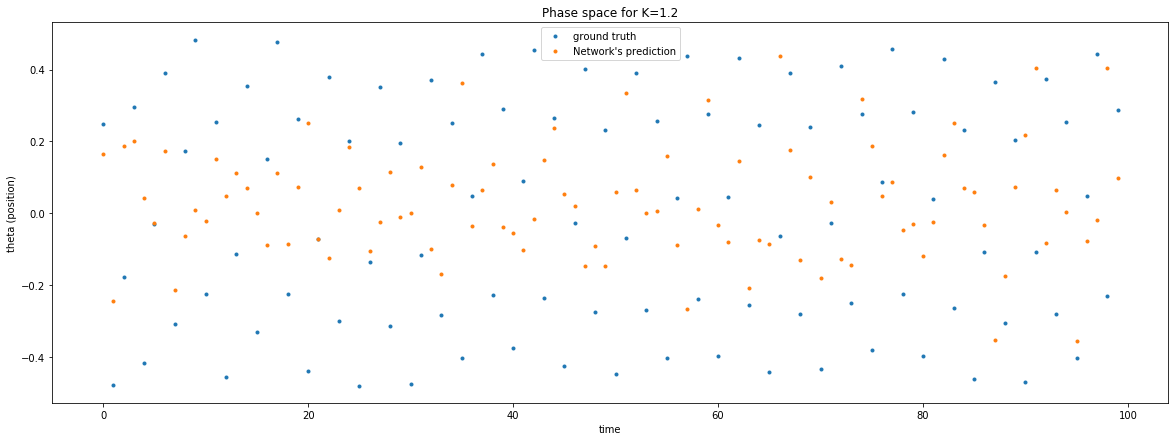

The test MSE is 0.12177063080560677
The 84 NRMSE is 51.602429859352455


In [89]:
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=1.2, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

## Fix the initial condition and increase the value of K

Let us now modify the value of $K$ while the initial condition remains fixed at (0.9,0).

In [90]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 1
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

In [91]:
Network.non_null_matrices = ["W_back", "W_in"]


Kick value K=1.2

The training MSE is 3.908770806130419e-06


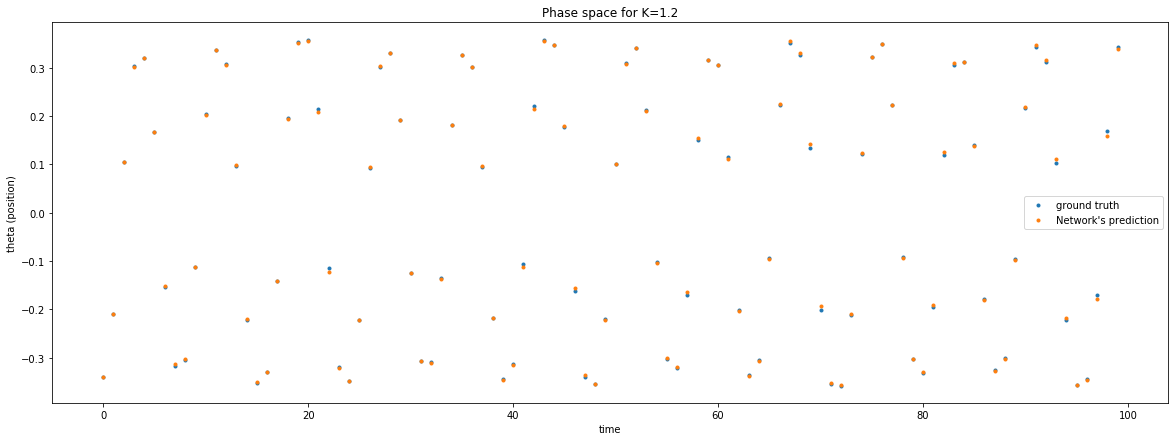

The test MSE is 9.89030058529844e-06
The 84 NRMSE is 0.43187921923913286

Kick value K=1.5

The training MSE is 0.03235597601369635


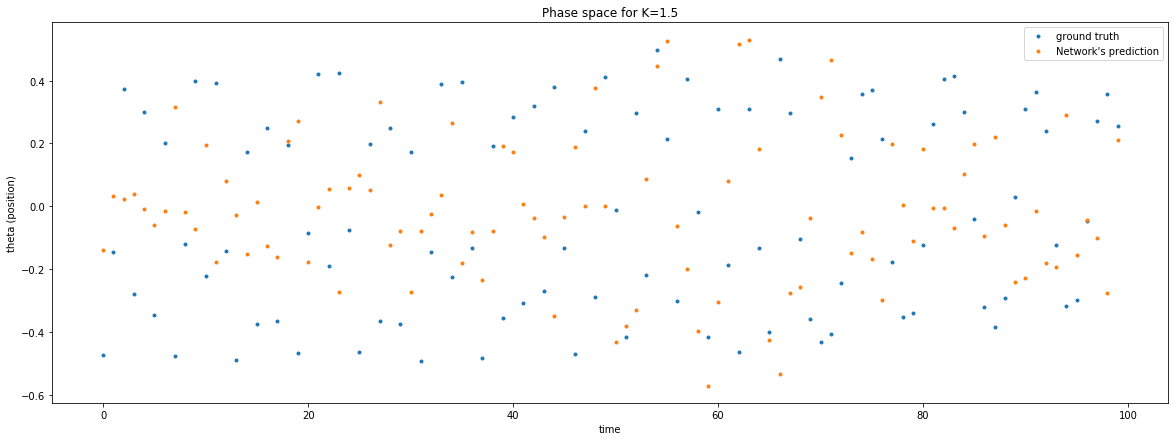

The test MSE is 0.18321876760214273
The 84 NRMSE is 49.06904763765506

Kick value K=2

The training MSE is 0.04941890374558242


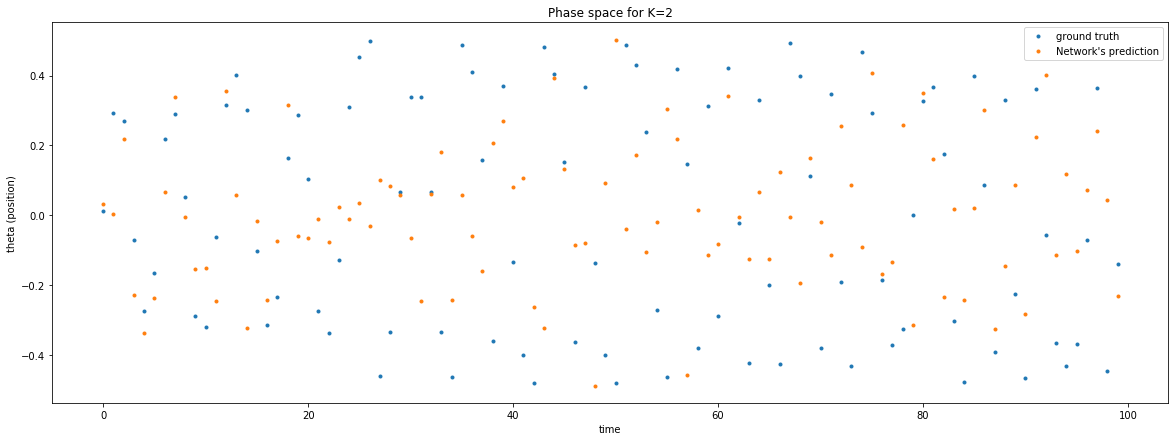

The test MSE is 0.12864108478723263
The 84 NRMSE is 51.77512185700335

Kick value K=3

The training MSE is 0.0467874088103362


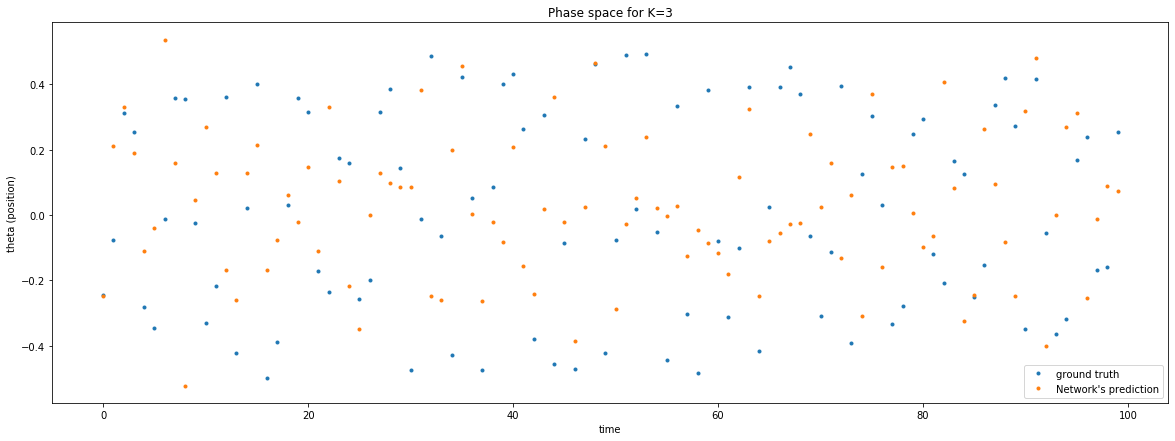

The test MSE is 0.12530281775699775
The 84 NRMSE is 56.52879184813813

Kick value K=5

The training MSE is 0.054528856981442095


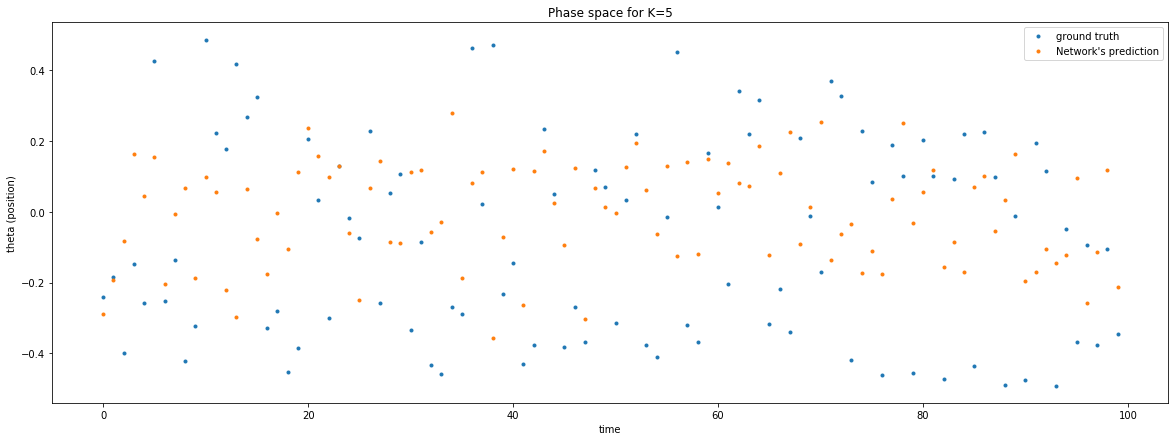

The test MSE is 0.09656313744660441
The 84 NRMSE is 45.3855106763003

Kick value K=7

The training MSE is 0.0538375833378555


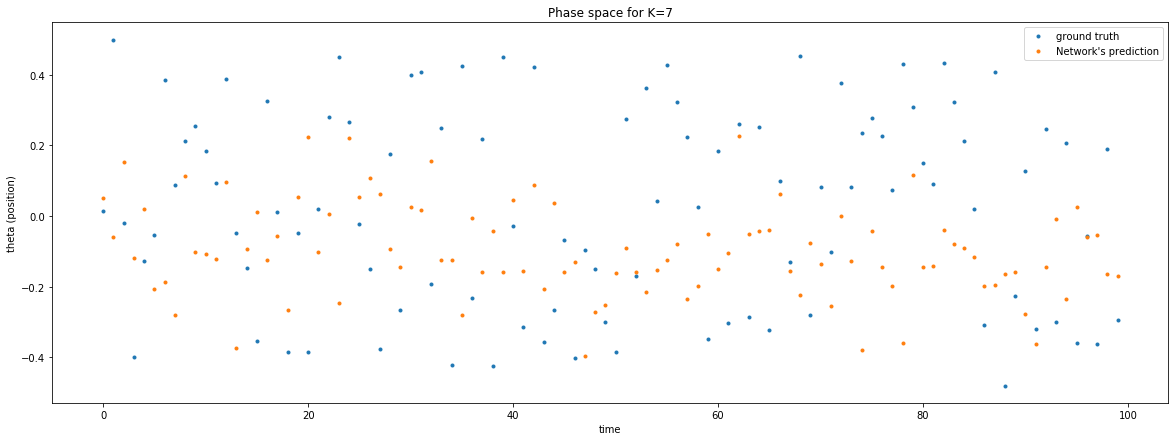

The test MSE is 0.11303115918474416
The 84 NRMSE is 52.75350560315796


In [92]:
Network.train_test_k(ic=[0.9,0], k_list=[1.2, 1.5, 2, 3, 5, 7], t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

#  2. Dynamics defined by the angular momentum ($p$) <a name="p" ></a>

In [ ]:
#restart the kernel
import os
os._exit(00)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import pdb

In [2]:
def esc(code):
    return f'\033[{code}m'

In [3]:
class Network():
    def __init__(self, T = None, n_min = None, K = None, N = None, L = None, W_in = None, W = None, W_back = None,
                 non_null_matrices = None, u = None, u_test = None, kick = None, InitialCondition_ODE = None,
                delta = 1, C = 1, a = 1):
        
        #NEED TO BE DEFINED BY THE USER:
        self.T = T #number of training time steps (integer)
        self.n_min = n_min #time steps dismissed (integer)
        
        self.K = K #dimension of the input (integer) (may be None)
        self.N = N #dimension of the reservoir, i.e, number of nodes (integer)
        self.L = L #dimension of the output (integer)
        
        self.W_in = W_in #input connections (matrix of size self.N x self.K)
        self.W = W #adjacency matrix (matrix of size self.N x self.N)
        self.W_back = W_back #feedback connections (matrix of size self.N x self.L) (may be None)
        
        self.non_null_matrices = non_null_matrices #list giving the matrices used when training: "W_in" and/or "W_back"
        
        self.u = u ##input (matrix of size self.K x 1) (may be None)              
        
        self.kick = kick #strength of the kick (float)
        self.InitialCondition_ODE = InitialCondition_ODE #initial condition of the ODE given as the list [theta,p]

        self.delta = delta #training parameter (float)
        self.C = C #training parameter (float)
        self.a = a #training parameter (float)
        
               
        #DO NOT NEED TO BE DEFINED BY THE USER:
        self.initial_state = None #initial state of the reservoir (state forgetting property)        
        self.trajectories = None #dynamics of the reservoir (matrix of size self.T x self.N) 
        self.regressor = None #regressor
        self.y_teach = None #desired output of the network (matrix of size self.L x self.T)
        self.y_teach_test = None #y_teach for doing the test (matrix of size self.L x (t_dismiss+t_autonom))
        
        
        
        
    def orbit(self, ic, k, t, squash=False):
        """
        Args:
            -ic, list giving the initial conditions [theta,p]
            -k, value of the kick
            -t, number of time steps
            -squash, whether we want to squash the orbits into [-0.5,0.5]
        
        Returns:
            -Matrix of size 1xt given the orbit followed by the given initial point during t time steps. 
            The single row corresponds to theta. The first column gives the initial 
            condition. Such orbit is squashed into [-0.5,0.5] if squash=True
        """
        
        trajectory_theta = [ic[0]]
        trajectory_p = [ic[1]]
            
        for time_step in np.arange(t-1):
            p_next = np.mod(trajectory_p[-1] + k*np.sin(trajectory_theta[-1]), 2*np.pi)
            theta_next = np.mod(trajectory_theta[-1] + p_next, 2*np.pi)
            trajectory_theta.append(theta_next)
            trajectory_p.append(p_next)
        trajectory_theta = np.asarray(trajectory_theta)
        trajectory_p = np.asarray(trajectory_p)
               
        if squash == True:
            trajectory_theta = trajectory_theta/(2*np.pi)-0.5
            trajectory_p = trajectory_p/(2*np.pi)-0.5
                                    
        return trajectory_p.reshape(1,-1)
    
    
    def dismiss_transient(self, M):
        """
        Given a matrix M, it removes the first n_min rows. Therefore:
        -If M = self.trajectories, it removes the transient of n_min.
        -If M = self.y_teach.T, it removes the transient of n_min.
        So, it removes the initial condition plus the following n_min-1 time steps
        NOTICE: y_teach has to be transposed when inputted
        """
        
        return M[self.n_min:,:]   
    
    
    def augmented_x(self, M):
        """
        Given a matrix M, it powers to the square the last half of its columns Therefore:
        -If M = self.trajectories, it squares the trajectories of the last half of the nodes.
        -If M = x, where x is the state of the nodes at a certain time step, it squares the current stat of the last 
        half of the nodes.
        NOTICE: x has to be inputted as a matrix of size 1 x self.N
        """   
    
        aux1 = M[:,:int(self.N/2)]
        aux2 = M[:,int(self.N/2):]
    
        return np.hstack((aux1, aux2**2))
    
    
    
    def compute_nodes_trajectories(self, test=False, noise=None, stDev=None, t_dismiss=None, t_autonom=None, NRMSE=False, horizon=None, num_runs=None): 
        """
        If test=False:
            -It computes self.trajectories, which is a matrix of size TxN, where each column is the trajectory of 
            a node. Notice that the first row corresponds to the initial state
            -It admits noise, in which case the "stDev" has to be specified
        
        If test=True and NRMSE=False:
            -Computes the predictions for the desired t_autonom regarding a teacher enforcing of t_dismiss time steps
        
        If test=True and NRMSE=True:
            -It computes the predictions at the desired time steps. That is, the network runs from the initial
            conditions for 1000 time steps by means of teacher enforcing. Then, it autonomoulsy runs the number of
            steps specified in the variable horizon. This is repeated num_runs time.
            Therefore, it return the predictions at time steps [i*(1000+horizon)-1 for i in np.arange(1,num_runs+1)]
        """
        
        #initial state of the reservoir
        if test == False:
            self.trajectories = self.initial_state
            x_prev = self.initial_state  
        if test == True:
            if NRMSE == False:
                x_prev = self.trajectories[t_dismiss-1,:]
            elif NRMSE == True:
                x_prev = self.initial_state
           
                
        if test == False:             
            if noise == True:
                #nu = np.random.uniform(low=-stDev, high=stDev, size=(self.N, self.T)) #uniform
                nu = np.random.normal(loc = 0, scale = stDev, size=(self.N, self.T)) #Gaussian noise                
                
            elif noise == False:
                nu = np.zeros([self.N, self.T]) 
                
                
        if "W_in" not in self.non_null_matrices:
            self.W_in = np.zeros([self.N, 1])
            if test == False:
                self.u = np.zeros([1, 1]) 
        
        
            
        if "W_back" not in self.non_null_matrices:
            self.W_back = np.zeros([self.N, 1])
            if test == False:
                y = np.zeros([1, self.T]) 
            elif test == True:
                if NRMSE == False:
                    y = np.zeros([1, self.T+t_autonom])
                elif NRMSE == True:
                    y = np.zeros([1, self.T+t_autonom])
            
        if "W_back" in self.non_null_matrices:
            if test == False:
                y = np.copy(self.y_teach)
            elif test == True:
                if NRMSE == False:
                    y = np.copy(self.y_teach_test[:,t_dismiss-1].reshape(-1,1))
                    
                

        delta = self.delta
        C = self.C
        a = self.a                

        
        if test == False:
            for n in np.arange(self.T-1):
                x = (1-delta*C*a)*x_prev + delta*C*np.tanh(np.dot(self.W_in,self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,y[:,n])+nu[:,n]) #noise added to the whole update 
                self.trajectories = np.vstack((self.trajectories,x))
                x_prev = x           
            return self
        
        elif test == True:
            if NRMSE == False:
                for n in np.arange(t_autonom):
                    x = (1-delta*C*a)*x_prev + delta*C*np.tanh(np.dot(self.W_in, self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,y[:,n]))
                    x_prev = x   
                    y_next = np.tanh(self.regressor.predict(self.augmented_x(x.reshape(1,-1)).reshape(1,-1))) 
                    y_next = y_next.reshape(-1,1)
                    y = np.hstack([y,y_next]) 
                    
                    
                return y  
            
            elif NRMSE == True:
                y = np.zeros([self.L,1]) #this is just for initializing the hstack. It will be removed at the end
                for run in np.arange(num_runs):
                    
                    #teacher enforcing
                    for n in np.arange(1000):
                        x = (1-delta*C*a)*x_prev + delta*C*np.tanh(np.dot(self.W_in, self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,self.y_teach_test[:,(run*(1000+horizon))+n]))
                        x_prev = x
                        
                    #autonomously run
                    for n in np.arange(horizon):                        
                        y_next = np.tanh(self.regressor.predict(self.augmented_x(x.reshape(1,-1)).reshape(1,-1)))                                                                      
                        y_next = np.asarray(y_next).reshape(-1)
                        x = (1-delta*C*a)*x_prev + delta*C*np.tanh(np.dot(self.W_in, self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,y_next))
                        x_prev = x
                    
                    y = np.hstack([y,y_next.reshape(-1,1)])
                    
                return y[:,1:]
            
    
    
    def plot_nodes_trajectories(self, sel_nodes=False, num_nodes=10):
        """
        Args:
            -sel_nodes, list specifying the nodes of the reservoir to be plotted. If sel_nodes=False, it randomly
            selects num_nodes nodes of the reservoir.
        
        Returns:
            -Plots the trajectories of the given nodes.
        """
        
        if sel_nodes == False:
            nodes_to_plot = random.sample(range(self.N),num_nodes) #select num_nodes random nodes
        else:
            nodes_to_plot = sel_nodes
        
        t = np.arange(self.T) #time steps
        for node in nodes_to_plot:
            plt.plot(t, self.trajectories[:,node])  
            plt.title("Trajectories of the node {}".format(node))
            plt.show()
            
            
    def train_network(self, plot=False, noise=False, stDev=0.01, regression_type = 'LinearRegression', regression_param=None):
        """
        Args:
            -plot, whether we want to plot the trajectories of 10 randomly selected nodes of the reservoir
            -noise, whether we want to add noise when training
            -stDev, if noise=True and stDev=a is the standard deviation of the noise
            -regression_type: it admits LinearRegression, Ridge or Lasso (string).
            -regression_param: parameter when performing Ridge or Lasso
        
        Returns:
            -Performs the training and returns the object self. It computes self.trajectories, self.regressor and
            prints the training MSE component-wise.
        """
        
        #Define the initial state (which is not relevant due to state forgetting property)
        #Define the ground truth
        self.initial_state = np.zeros(self.N)
        self.y_teach = self.orbit(self.InitialCondition_ODE, self.kick, self.T, squash=True)        
        
        #Compute trajectories
        self.compute_nodes_trajectories(noise=noise, stDev=stDev)

        #plot some trajectories
        if plot == True:
            self.plot_nodes_trajectories()
            
        if regression_type == 'LinearRegression':
            regressor = LinearRegression()
        elif regression_type == 'Ridge':
            regressor = Ridge(alpha = regression_param)
        elif regression_type == 'Lasso':
            regressor = Lasso(alpha = regression_param)
        
        x = self.dismiss_transient(self.trajectories)        
        regressor.fit(self.augmented_x(x), np.arctanh(self.dismiss_transient(self.y_teach.T))) 
        
        #Compute MSE    
        MSE_vector = 1/(self.T-self.n_min)*sum((np.arctanh(self.dismiss_transient(self.y_teach.T)) - regressor.predict(self.augmented_x(x)))**2) #augmented
                
        if self.L == 1: #in case the output is one dimensional
            print("The training MSE is {}".format(MSE_vector[0]))        
        else: #in case the output has dimension 2 or more
            for i in np.arange(self.L):
                print("The training MSE for the {}-th dimension is {}".format(i+1, MSE_vector[i]))        
                                              
        self.regressor = regressor   
        
        return self    
    
    
    
    def test_network(self, t_dismiss, t_autonom, NRMSE=True):
        """
        Args:
            -t_dismiss, which is the time we let the reservoir evolve by teacher enforcing.
            -t_autonom, which is the time we let the network freely run  
            -NRMSE, which says whether we want to compute the 84 NRMSE error
        
        Returns:
            -The MSE and NRMSE (whenever NRMSE=True) during the t_autonom component-wise
            -Plots the predicted trajectory during the t_autonom against the ground truth.
        """  
        
        #Define y_teach_test
        self.y_teach_test = self.orbit(self.InitialCondition_ODE, self.kick, t_dismiss+t_autonom, squash=True)
            
                      
        #predict
        y = self.compute_nodes_trajectories(test=True, t_dismiss=t_dismiss, t_autonom=t_autonom)
        y = y[:,1:] #remove the first one
            
        
        #plot prediction vs ground truth        
        plt.figure(figsize=(20,7))
        plt.plot(self.y_teach_test[0,t_dismiss:t_dismiss+t_autonom], '.', label="ground truth")
        plt.plot(y[0,:], '.', label="Network's prediction")                
        plt.title('Phase space for K={}'.format(self.kick))
        plt.xlabel('time')
        plt.ylabel('theta (position)') 
        plt.legend()        
        plt.show() 
        

        #MSE 
        MSE = 1/t_autonom*sum((self.y_teach_test[:,t_dismiss:t_dismiss+t_autonom]-y).T**2) 
        
        if self.L == 1: #in case the output is one dimensional
            print("The test MSE is {}".format(MSE[0]))        
        else: #in case the output has dimension 2 or more
            for i in np.arange(self.L):
                print("The test MSE for the {}-th dimension is {}".format(i+1, MSE[i]))        
           

        #NRMSE
        if NRMSE == True:
            NRMSE = self.compute_NRMSE()
            
            if self.L == 1: #in case the output is one dimensional
                print("The 84 NRMSE is {}".format(NRMSE[0]))        
            else: #in case the output has dimension 2 or more
                for i in np.arange(self.L):
                    print("The 84 NRMSE for the {}-th dimension is {}".format(i+1, NRMSE[i]))
                    
            
                
    def compute_NRMSE(self, horizon=84, num_runs=50):
        """
        Computes the 84 NRMSE component-wise for the given horizon (specified in the parameter horizon) and for
        the given number of runs (specified in the parameter num_runs).
        """
        
        #Redefine the self.y_teach_test. It will be of size 2x(1048x50) 
        self.y_teach_test = self.orbit(self.InitialCondition_ODE, self.kick, (1000+horizon)*num_runs, squash=True)
        var = []
        for i in np.arange(self.L):
            #variance of i-th component
            var.append(np.average(self.y_teach_test[i,:]**2)-np.average(self.y_teach_test[i,:])**2) 
            
        
        #desired predictions at the required time steps
        y = self.compute_nodes_trajectories(test=True, NRMSE=True, horizon=horizon, num_runs=num_runs)
        
        #Compute the NRMSE
        list_cols = [i*(1000+horizon)-1 for i in np.arange(1,num_runs+1)]
        y_ground_truth = self.y_teach_test[:, list_cols] 
        y_ground_truth = 2*np.pi*(y_ground_truth + 0.5) #recover original values
        y = 2*np.pi*(y + 0.5) #recover original values
        
        NRMSE = []
        for i in np.arange(self.L):
            NRMSE.append((sum((y_ground_truth[i,:]-y[i,:])**2)/var[i])**0.5)           
                  
        
        return NRMSE 

    
           

    def train_test(self, ic_list, k, t_dismiss, t_autonom, NRMSE=True, noise=False, stDev=0.01, regression_type='LinearRegression', regression_param=None):
        """
        Performs the training and testing for different initial conditions
        
        Arguments:
            -ic_list, list specifying the initial condition (in the form of [theta, p])
            -k, value of the kick
            -noise, whether we want to introduce noise during training
            -stDev, standard deviation of the noise in case noise=True
            -regression_type, admits LinearRegression, Ridge or Lasso
            -regression_param, parametr for the Ridge or Lasso
            -t_dismiss, t_dismiss for testing
            -t_autonom, t_autonom for testing
            -NRMSE, whether we want to print the NRMSE
        """
        self.kick = k
                
        for ic in ic_list:
        
            #set ic
            self.InitialCondition_ODE = ic
                
            print(esc(0))
            print(esc('31;1;4') + 'Initial condition ic={}'.format(ic))
            print(esc(0))
                
            #training
            self.train_network(plot=False, noise=noise, stDev=stDev, regression_type=regression_type, regression_param=regression_param)
                    
            #testing
            self.test_network(t_dismiss=t_dismiss, t_autonom=t_autonom, NRMSE=NRMSE) 
            

    def train_test_k(self, ic, k_list, t_dismiss, t_autonom, NRMSE=True, noise=False, stDev=0.01, regression_type='LinearRegression', regression_param=None):
        """
        Performs the training and testing for different a single initial condition but different values of k
        
        Arguments:
            -ic, initial condition (in the form of [theta, p])
            -k_list, value of the kick
            -noise, whether we want to introduce noise during training
            -stDev, standard deviation of the noise in case noise=True
            -regression_type, admits LinearRegression, Ridge or Lasso
            -regression_param, parametr for the Ridge or Lasso
            -t_dismiss, t_dismiss for testing
            -t_autonom, t_autonom for testing
            -NRMSE, whether we want to print the NRMSE
        """
        self.InitialCondition_ODE = ic        
                
        for k in k_list:
        
            #set ic
            self.kick = k
                
            print(esc(0))
            print(esc('31;1;4') + 'Kick value K={}'.format(k))
            print(esc(0))
                
            #training
            self.train_network(plot=False, noise=noise, stDev=stDev, regression_type=regression_type, regression_param=regression_param)
                    
            #testing
            self.test_network(t_dismiss=t_dismiss, t_autonom=t_autonom, NRMSE=NRMSE) 
        

In [4]:
Network = Network()

# 2.1 K=0 <a name="pK0" ></a>

### Illustrative case

In [5]:
Network.InitialCondition_ODE = [0, 0.75]
Network.kick = 0

In [6]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 1
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

In [7]:
Network.non_null_matrices = ["W_back", "W_in"]

In [8]:
#TRAIN
Network.train_network(noise=True, stDev=0.001, regression_type='Ridge', regression_param=10) 

The training MSE is 3.0814879110195774e-33


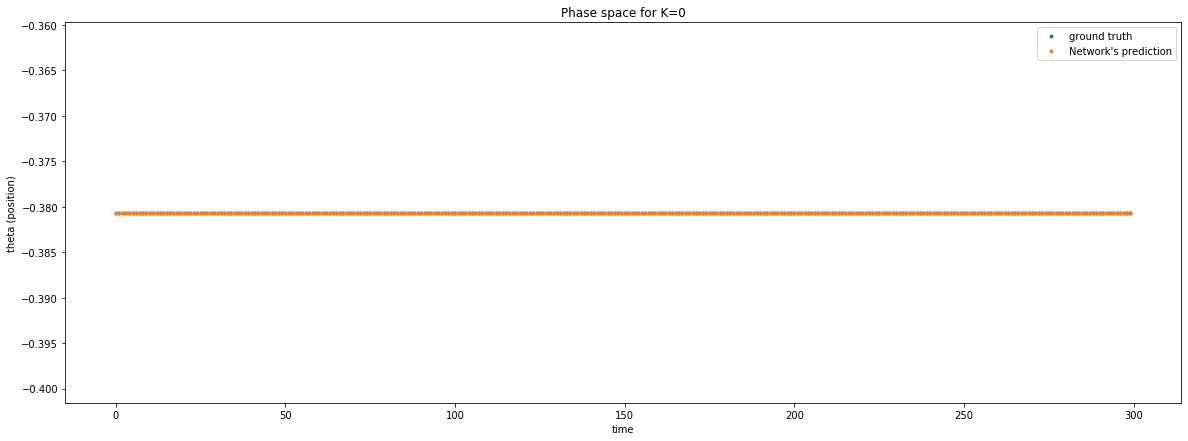

The test MSE is 3.0814879110195774e-33
The 84 NRMSE is 3.1610136383170525e-07


In [9]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 300, NRMSE=True)

# 2.2 K=0.1 <a name="pK01" ></a>

### Illustrative case

In [10]:
Network.InitialCondition_ODE = [0, 0.75]
Network.kick = 0.1

In [11]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 1
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

In [12]:
Network.non_null_matrices = ["W_back", "W_in"]

In [13]:
#TRAIN
Network.train_network(noise=True, stDev=0.001, regression_type='Ridge', regression_param=10) 

The training MSE is 4.5232107690803097e-07


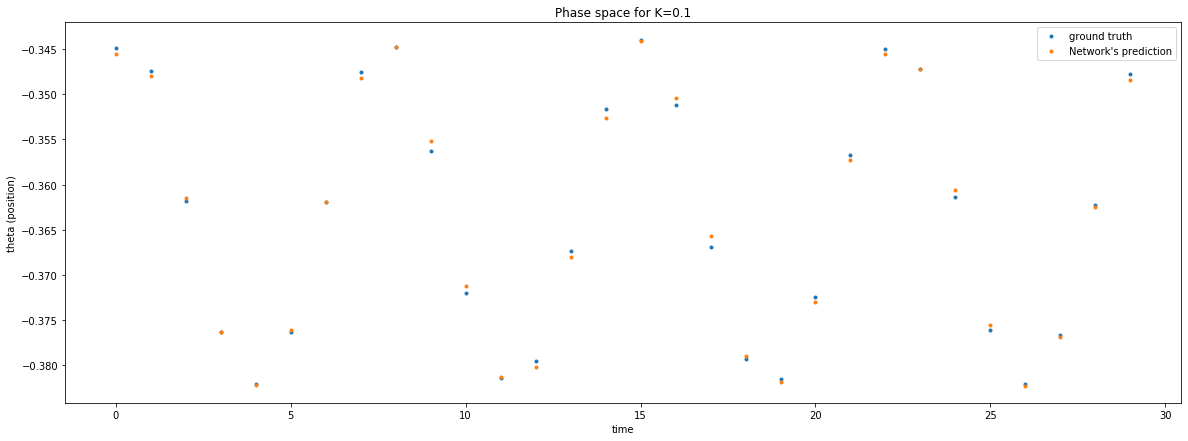

The test MSE is 3.353305908077742e-07
The 84 NRMSE is 1.7645438169311605


In [14]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 30, NRMSE=True)

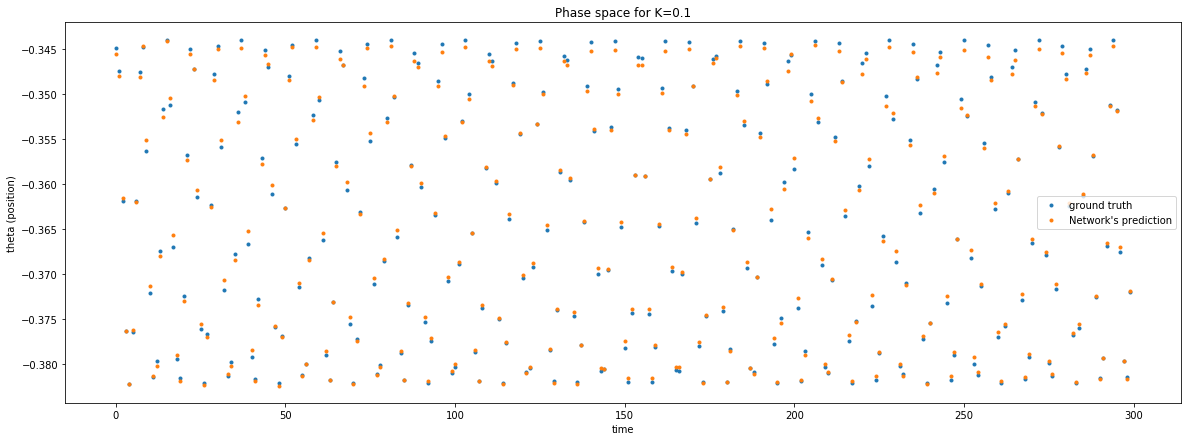

The test MSE is 2.922164114415765e-07


In [15]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 300, NRMSE=False)

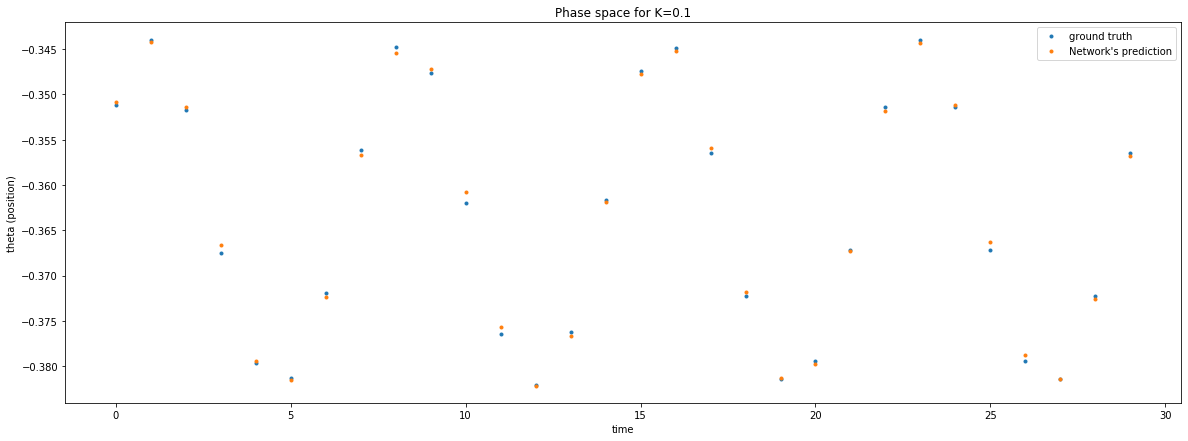

The test MSE is 2.5301477036239855e-07


In [16]:
#REPLICATE
Network.test_network(t_dismiss=2000, t_autonom = 30, NRMSE=False)

### Different initial conditions


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


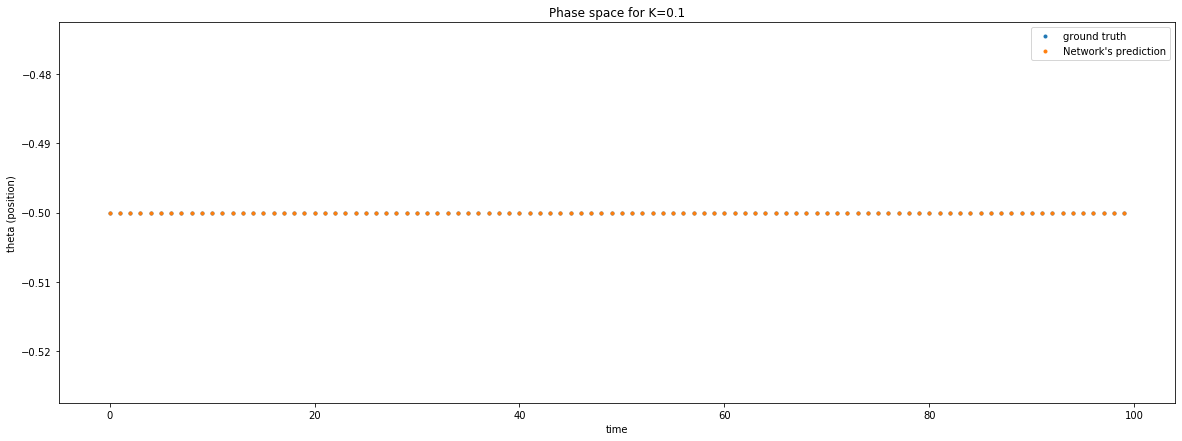

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:361: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 3.7319167934253464e-07


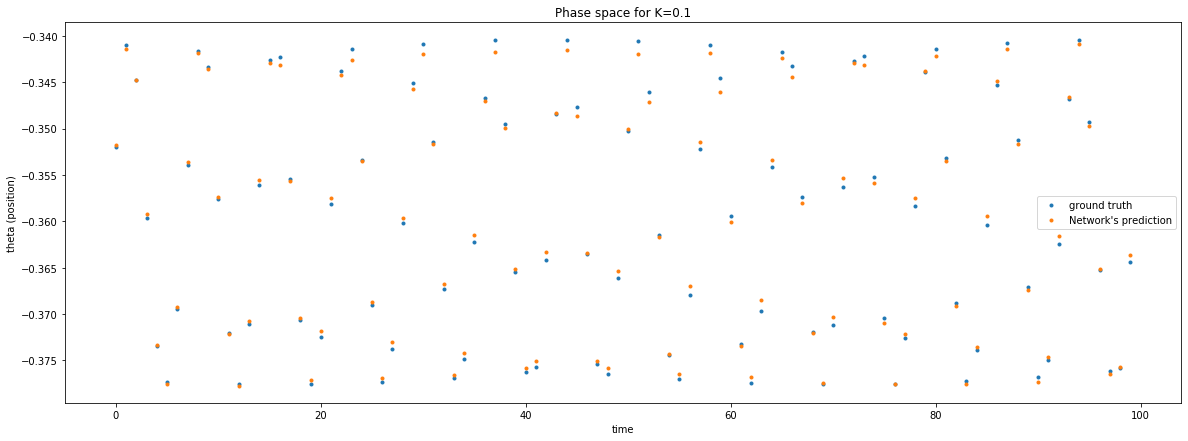

The test MSE is 3.7442689254736386e-07
The 84 NRMSE is 1.0992215786591035

Initial condition ic=[0, 0.9]

The training MSE is 4.0049705165757874e-07


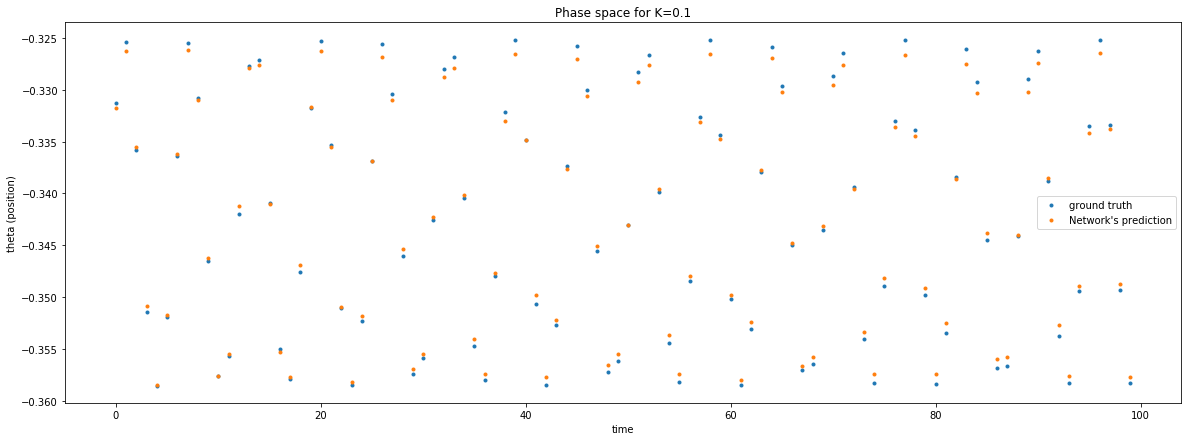

The test MSE is 4.810543442700698e-07
The 84 NRMSE is 2.0917651194082705

Initial condition ic=[0.9, 0]

The training MSE is 0.003482016851389816


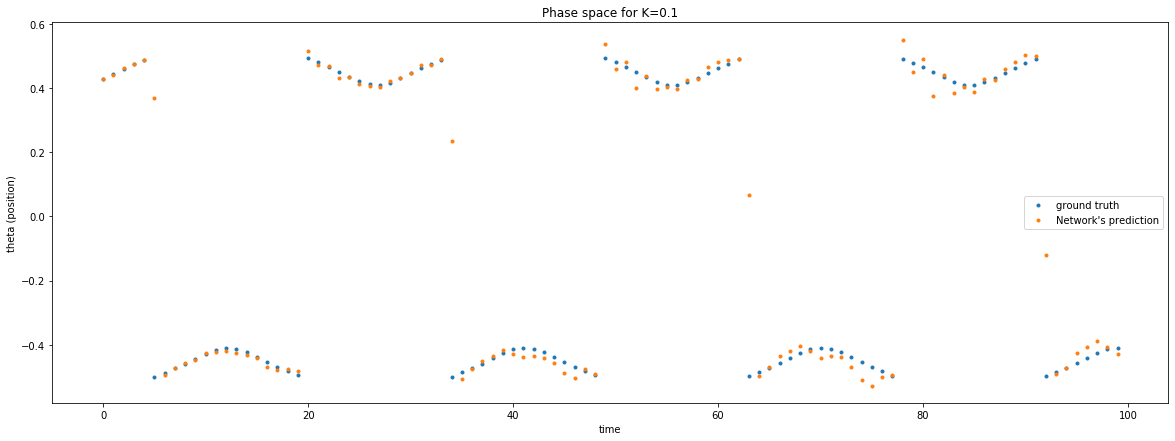

The test MSE is 0.01797394628216406
The 84 NRMSE is 8.23247452200923

Initial condition ic=[0.5, 3]

The training MSE is 7.708885131843224e-07


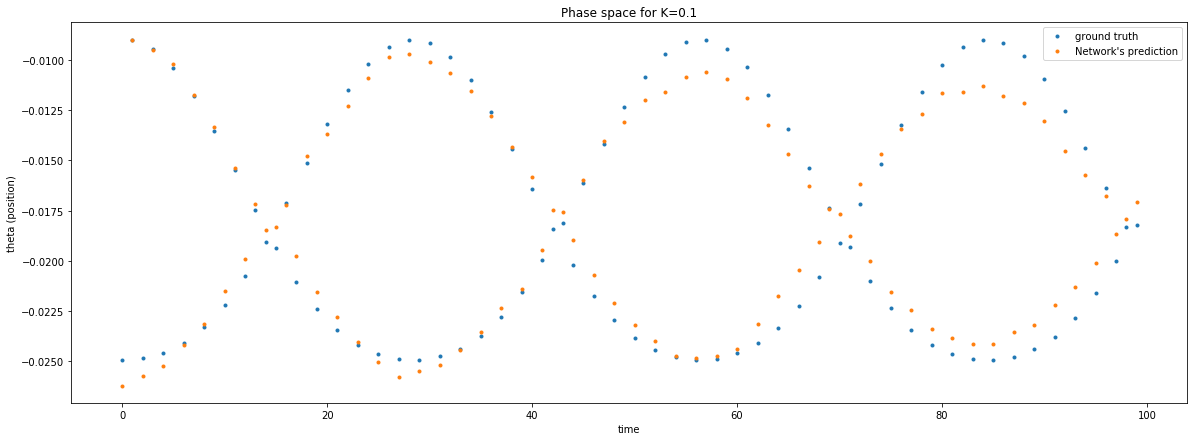

The test MSE is 1.0838898611242388e-06
The 84 NRMSE is 10.90614771167402

Initial condition ic=[1, 3.5]

The training MSE is 3.5491147774243294e-06


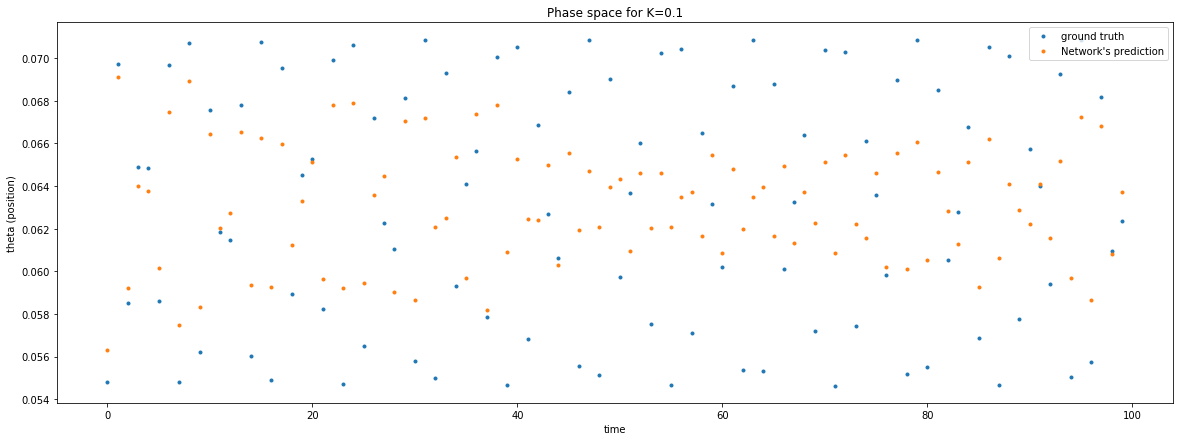

The test MSE is 1.6365396107691305e-05
The 84 NRMSE is 47.92254545976887

Initial condition ic=[1, 1.2]

The training MSE is 9.779385657504483e-07


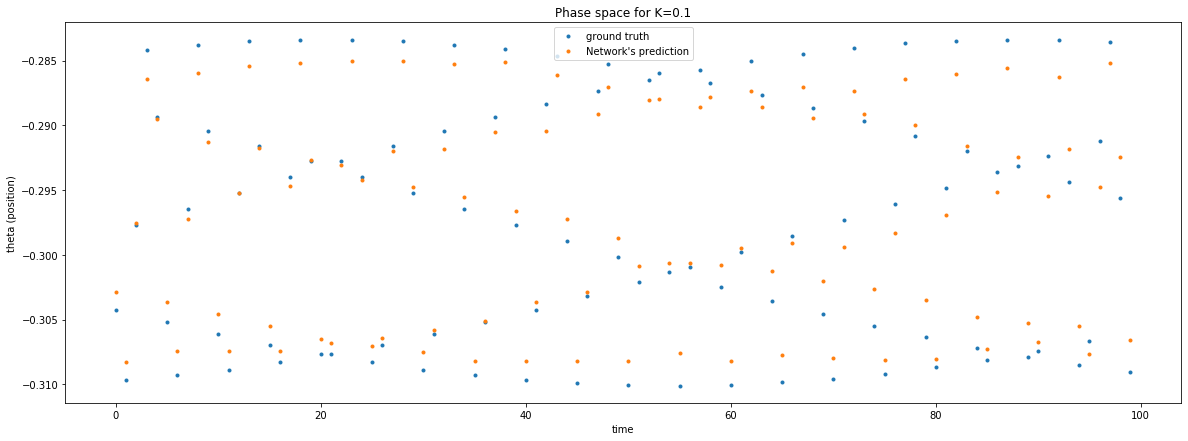

The test MSE is 2.9330781208590296e-06
The 84 NRMSE is 12.587342284046148


In [17]:
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.1, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

# 2.3 K=0.25 <a name="pK025" ></a>

### Illustrative example

In [18]:
Network.InitialCondition_ODE = [0, 0.75]
Network.kick = 0.25

In [19]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 1
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

In [20]:
Network.non_null_matrices = ["W_back", "W_in"]

In [21]:
#TRAIN
Network.train_network(noise=True, stDev=0.001, regression_type='Ridge', regression_param=10) 

The training MSE is 3.4178848105674204e-07


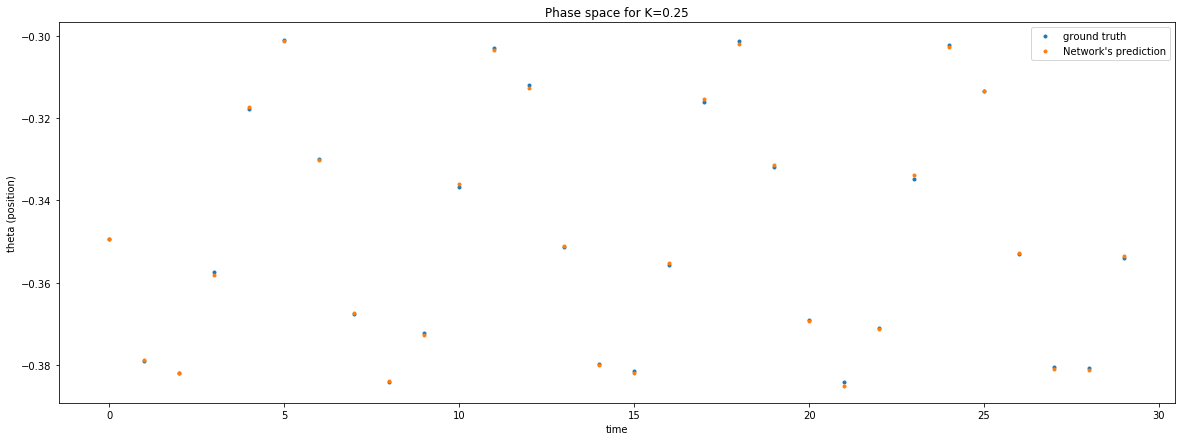

The test MSE is 2.3011121519844992e-07
The 84 NRMSE is 1.2940792300262602


In [22]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 30, NRMSE=True)

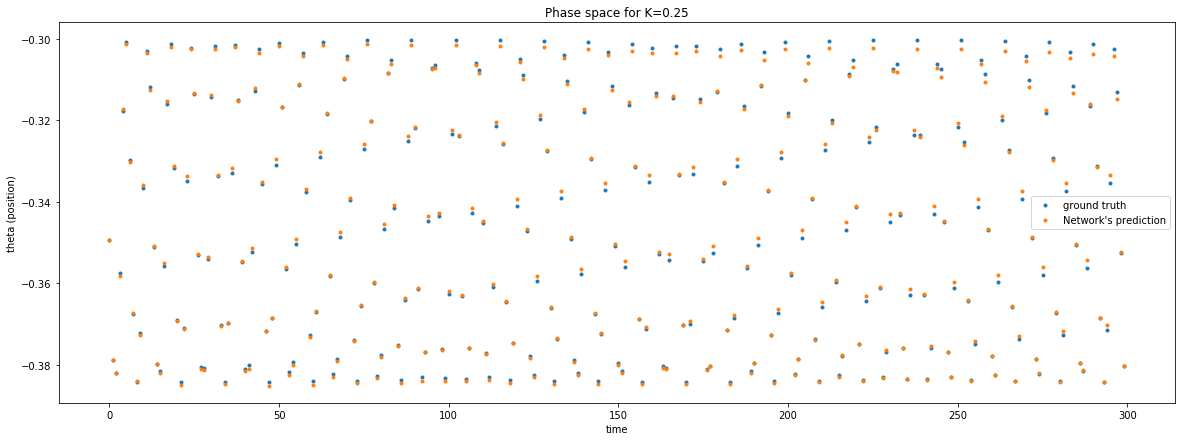

The test MSE is 8.758882962081101e-07


In [23]:
#TEST
Network.test_network(t_dismiss=Network.T, t_autonom = 300, NRMSE=False)

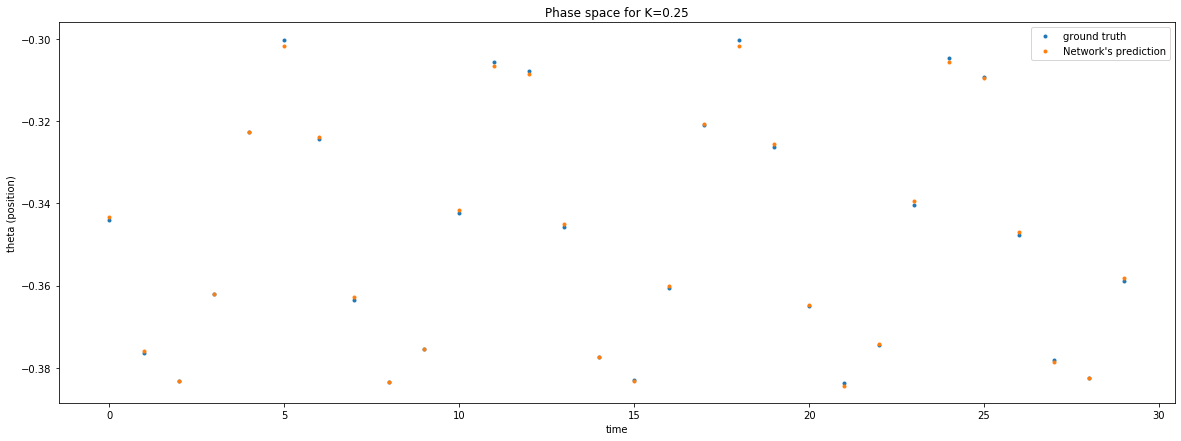

The test MSE is 3.9009805099528796e-07


In [24]:
#REPLICATE
Network.test_network(t_dismiss=2000, t_autonom = 30, NRMSE=False)

### Different initial conditions


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


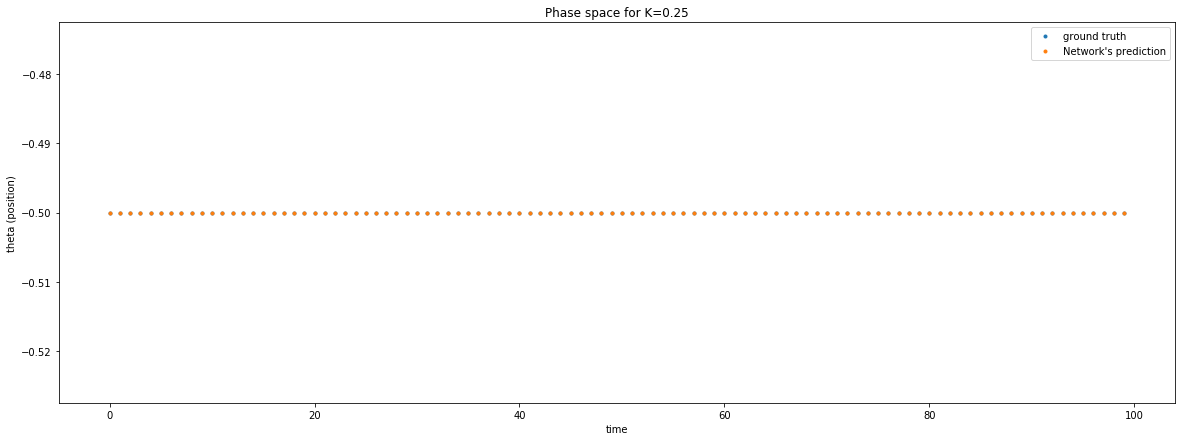

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:361: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 2.932442947016126e-07


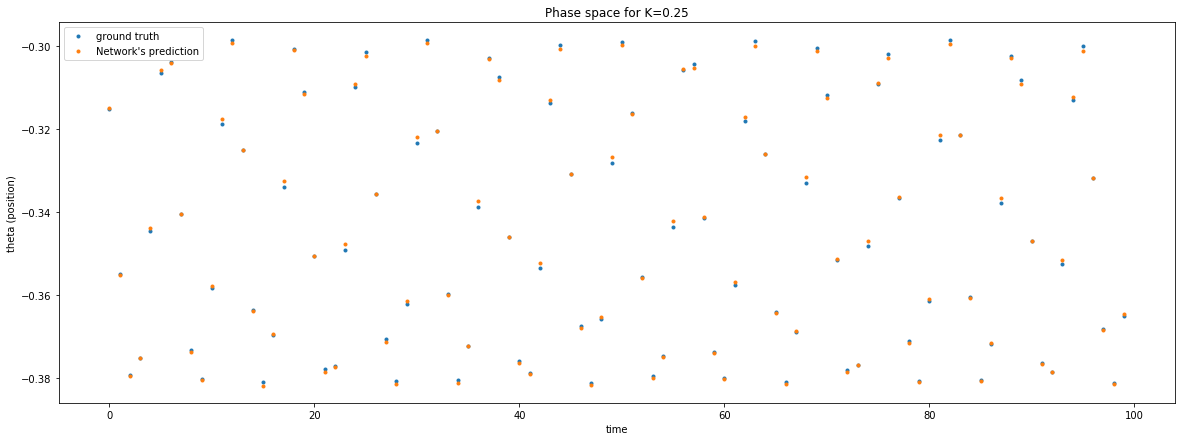

The test MSE is 4.869647963134963e-07
The 84 NRMSE is 0.9749083825425688

Initial condition ic=[0, 0.9]

The training MSE is 1.7870236462155072e-07


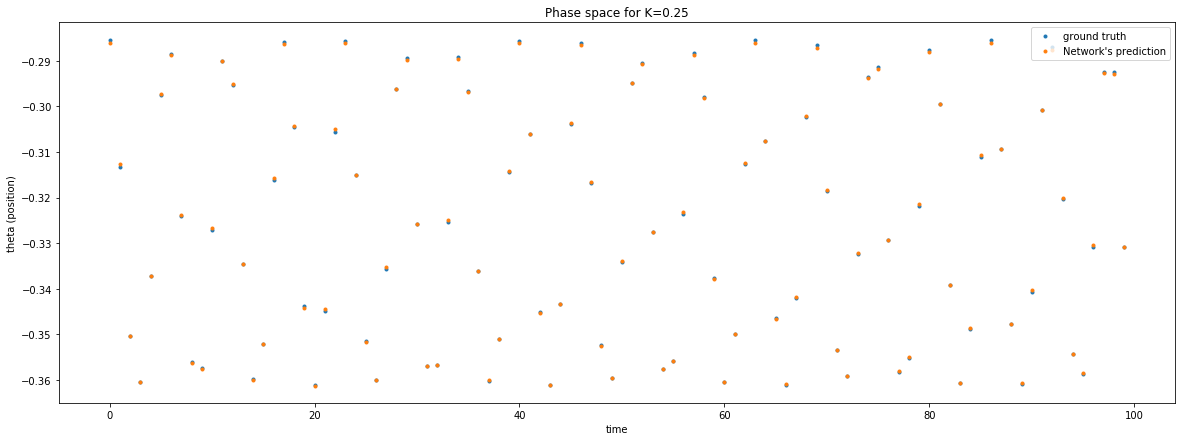

The test MSE is 6.971598174654371e-08
The 84 NRMSE is 0.5448855474544892

Initial condition ic=[0.9, 0]

The training MSE is 0.0042569595341188406


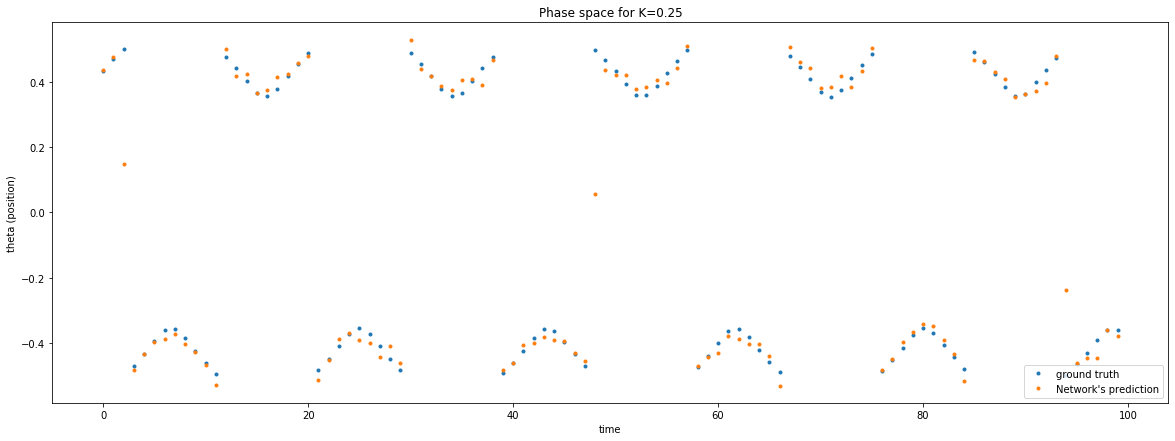

The test MSE is 0.00434030655184548
The 84 NRMSE is 7.230475050441217

Initial condition ic=[0.5, 3]

The training MSE is 9.713917798398677e-07


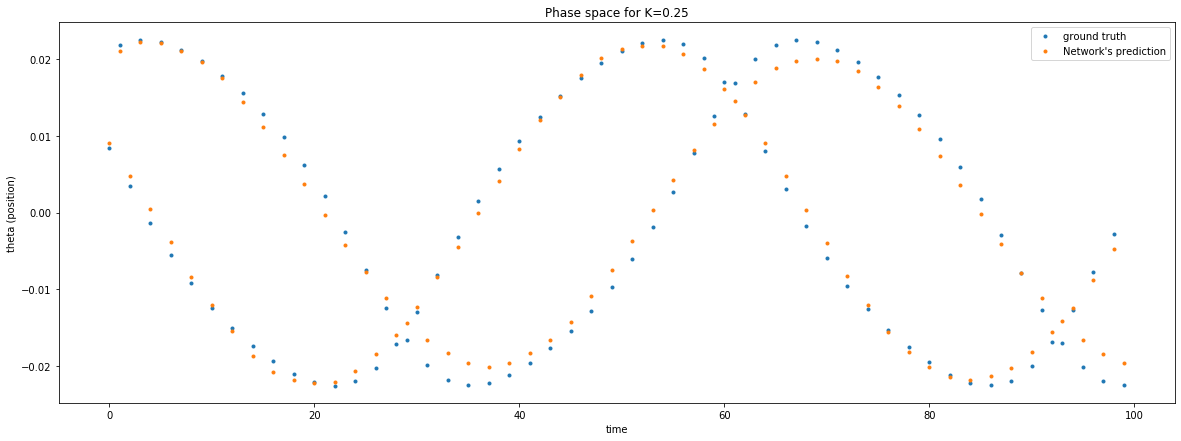

The test MSE is 2.6591623357056167e-06
The 84 NRMSE is 3.4847623514266863

Initial condition ic=[1, 3.5]

The training MSE is 7.249842552601258e-07


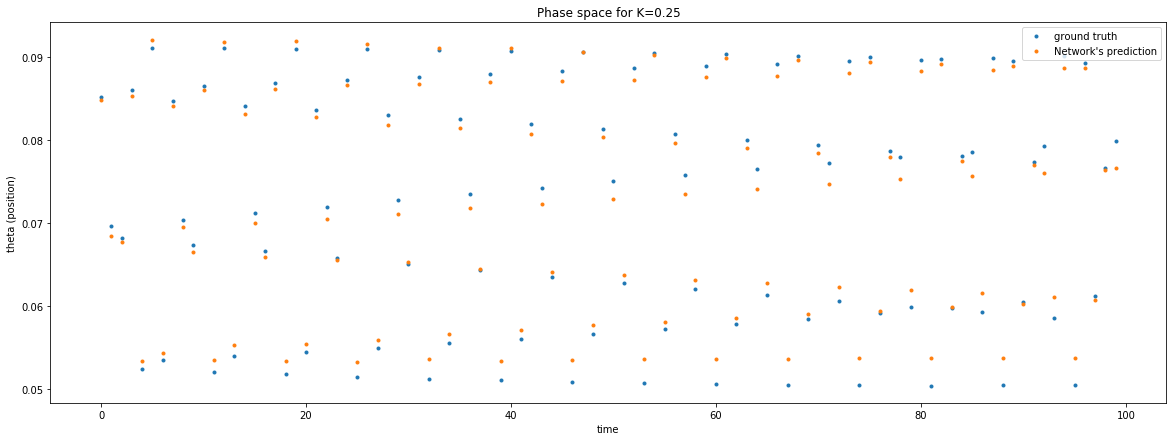

The test MSE is 2.4105955213529027e-06
The 84 NRMSE is 4.802185034704706

Initial condition ic=[1, 1.2]

The training MSE is 3.5723714577456135e-07


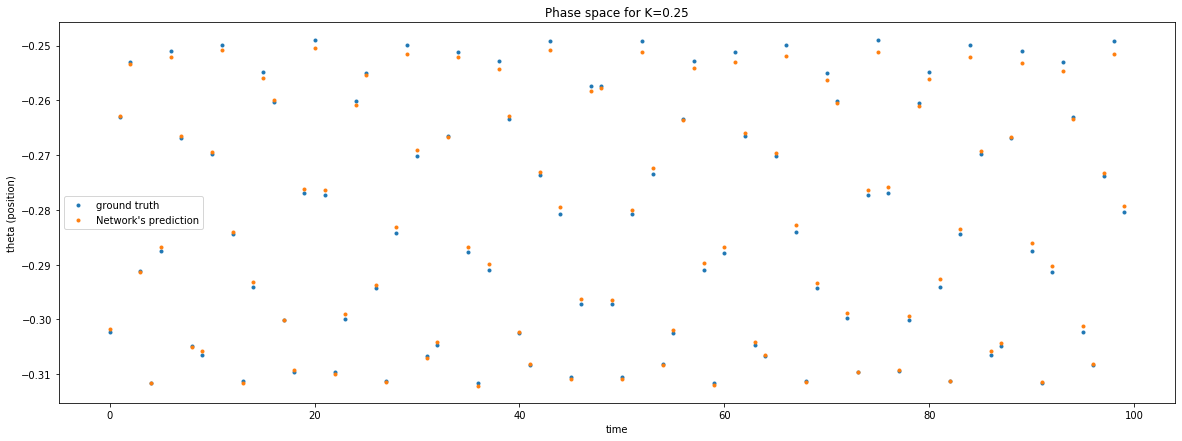

The test MSE is 9.286810640809716e-07
The 84 NRMSE is 2.0011921874226806


In [25]:
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.25, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

# 2.4 K=0.5, 0.75, 0.9 <a name="pKmult" ></a>

In [26]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 1
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


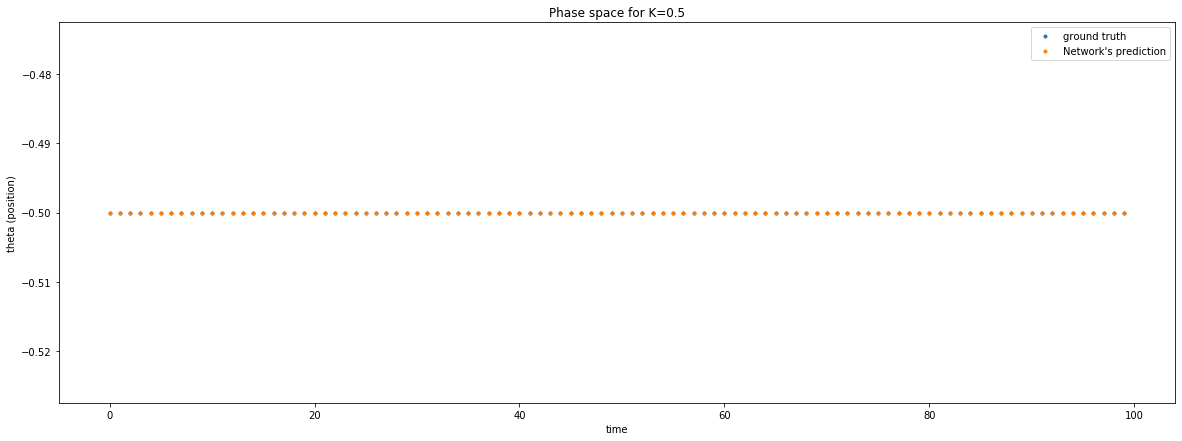

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:361: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 1.0717072176917427e-06


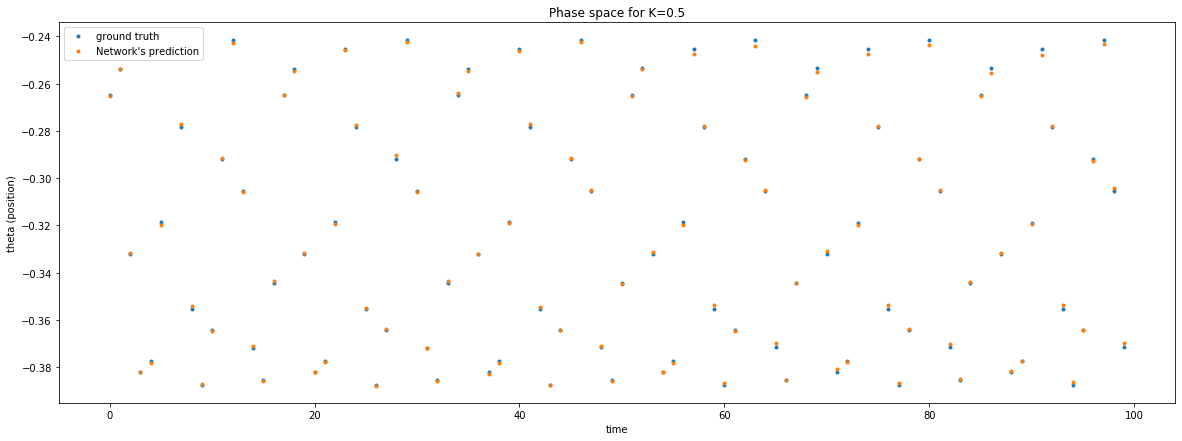

The test MSE is 9.631782105395715e-07
The 84 NRMSE is 1.905858743959225

Initial condition ic=[0, 0.9]

The training MSE is 2.3037638973218082e-06


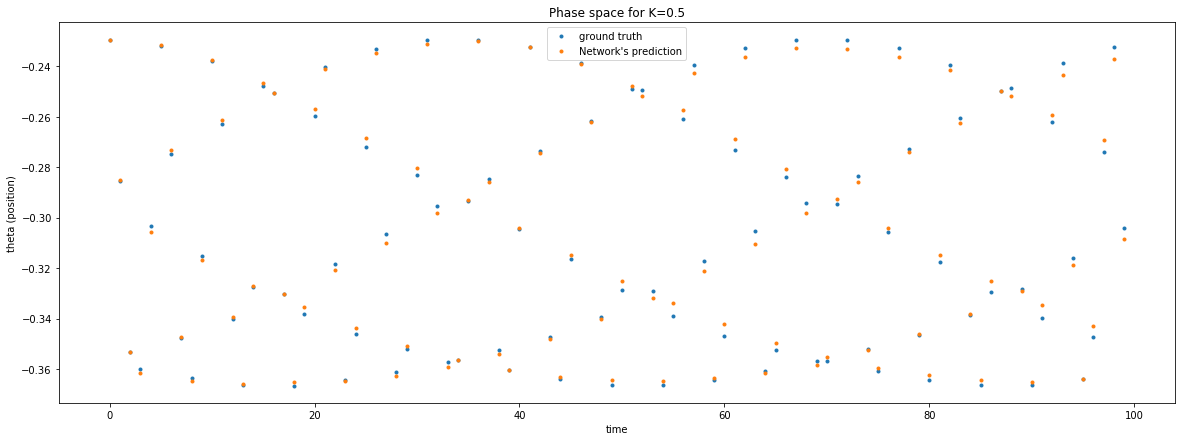

The test MSE is 5.803538883619048e-06
The 84 NRMSE is 2.4234075593408964

Initial condition ic=[0.9, 0]

The training MSE is 0.0031094398972957337


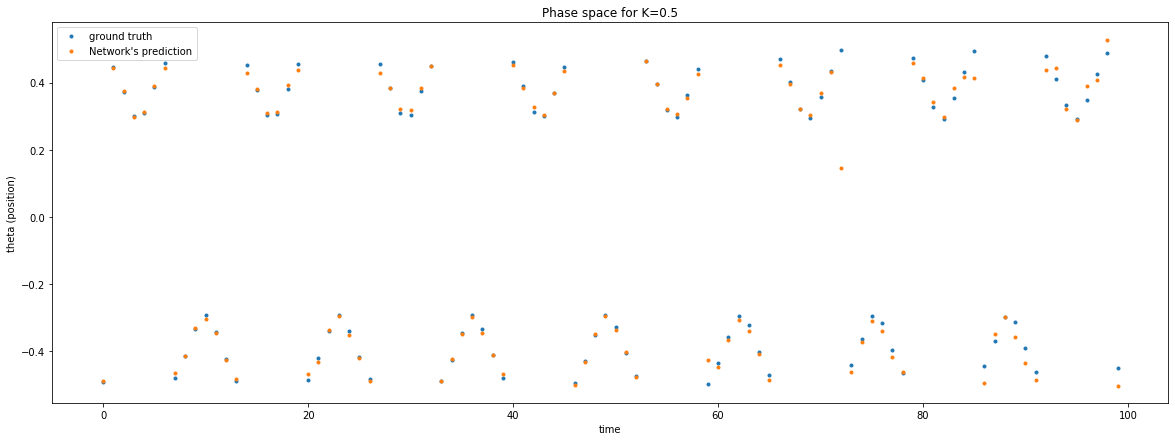

The test MSE is 0.001627279552652439
The 84 NRMSE is 5.6208840653798555

Initial condition ic=[0.5, 3]

The training MSE is 1.1775549056131428e-06


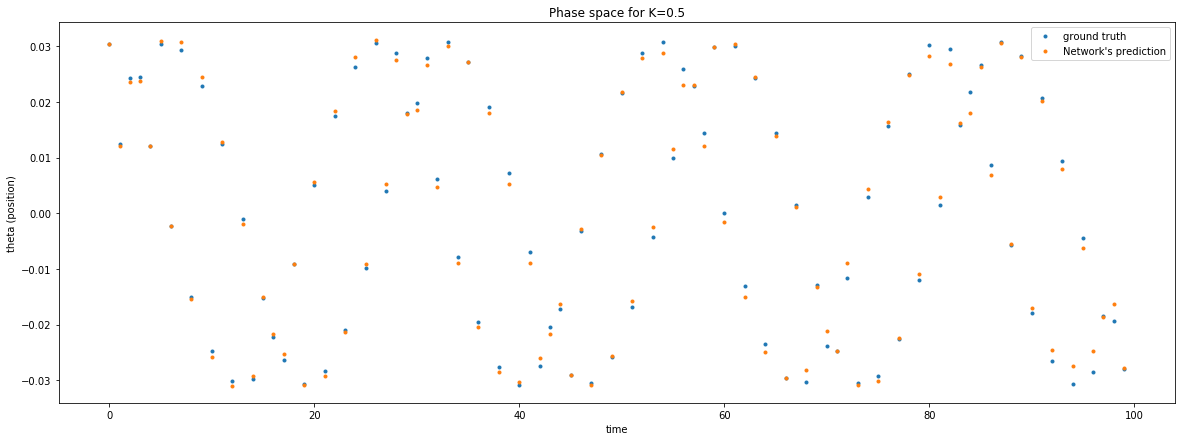

The test MSE is 1.7104015651891658e-06
The 84 NRMSE is 3.7916744040860775

Initial condition ic=[1, 3.5]

The training MSE is 1.9689075881994986e-06


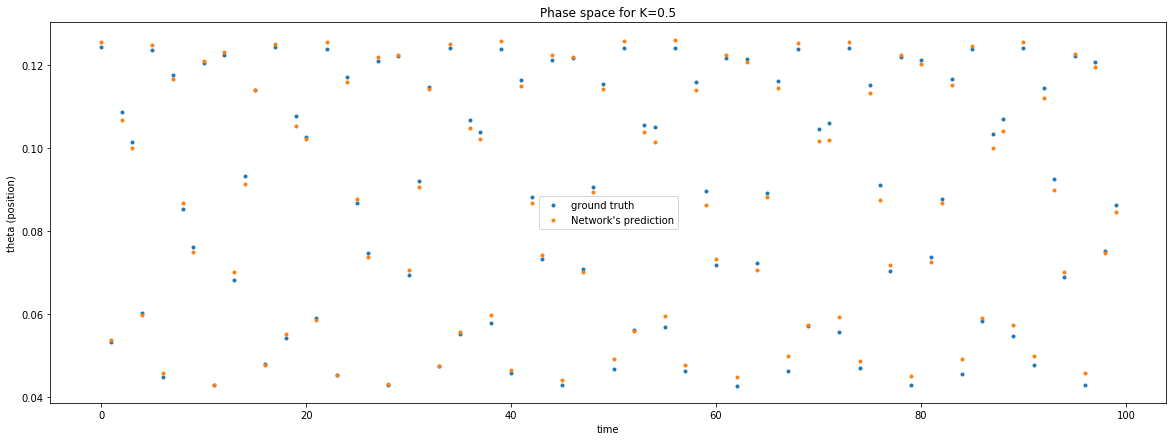

The test MSE is 3.03816281018633e-06
The 84 NRMSE is 3.58601865992244

Initial condition ic=[1, 1.2]

The training MSE is 1.049076045239786e-06


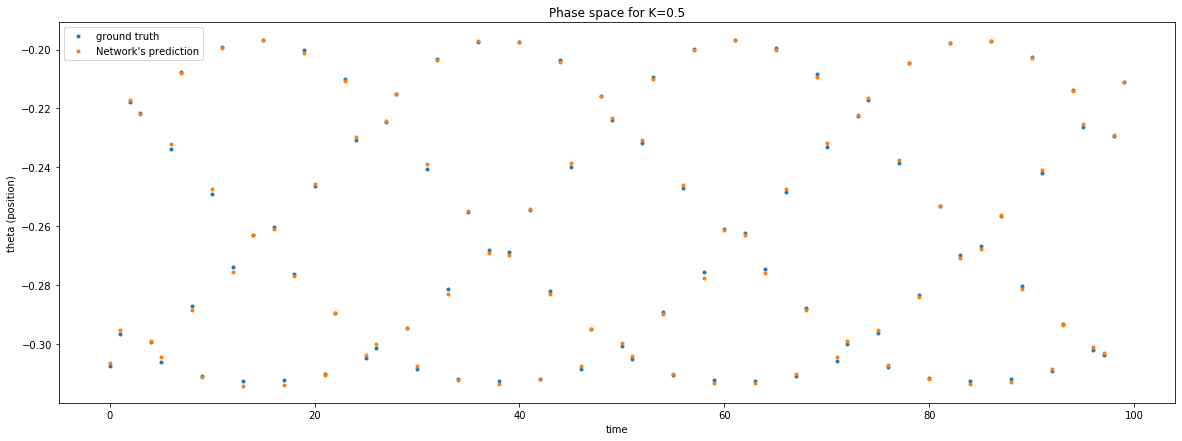

The test MSE is 7.822058649328892e-07
The 84 NRMSE is 0.9285922132261403


In [27]:
#K=0.5
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.5, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


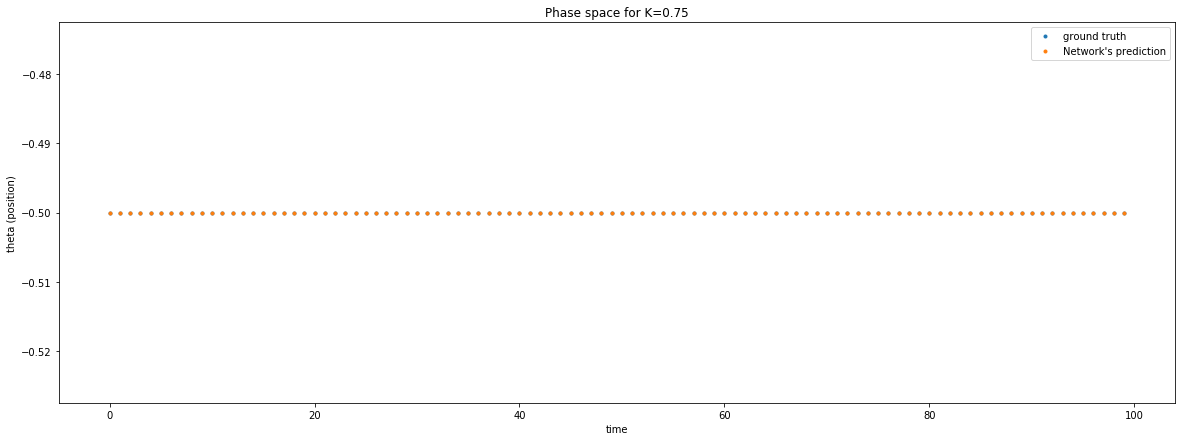

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:361: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 1.4741658401633775e-05


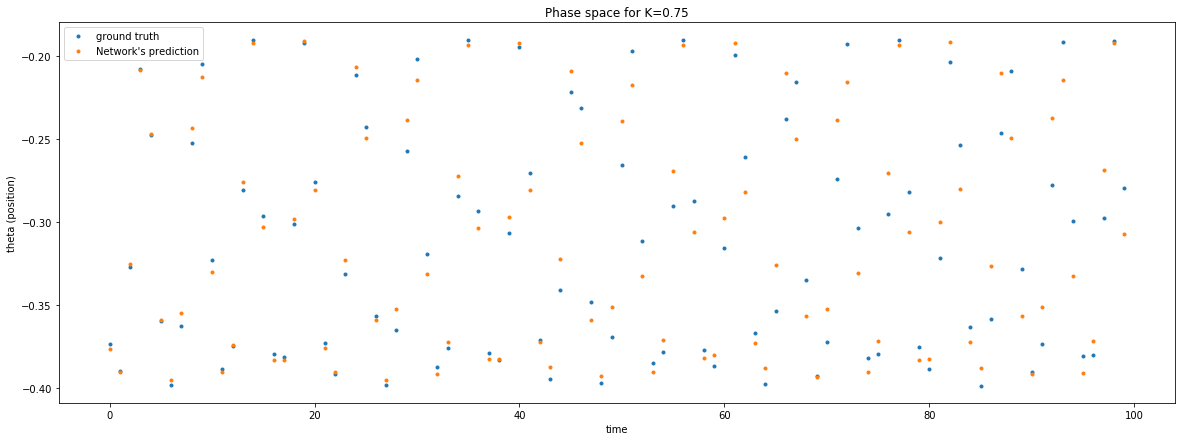

The test MSE is 0.00026264936047734974
The 84 NRMSE is 14.319131702437806

Initial condition ic=[0, 0.9]

The training MSE is 6.059104085677253e-06


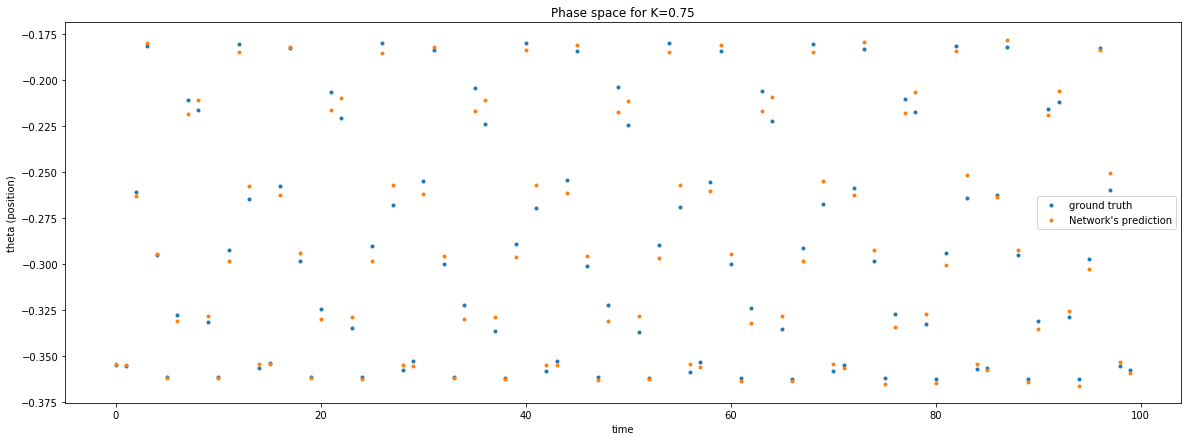

The test MSE is 3.874514634392675e-05
The 84 NRMSE is 5.76052824710725

Initial condition ic=[0.9, 0]

The training MSE is 0.0030691593727952427


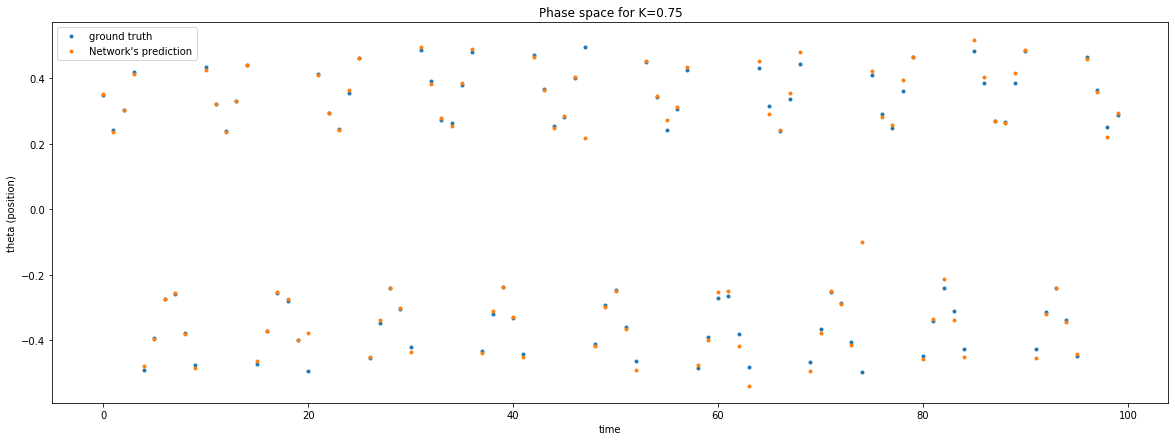

The test MSE is 0.002722532300544041
The 84 NRMSE is 5.003362470833493

Initial condition ic=[0.5, 3]

The training MSE is 1.697354374548738e-06


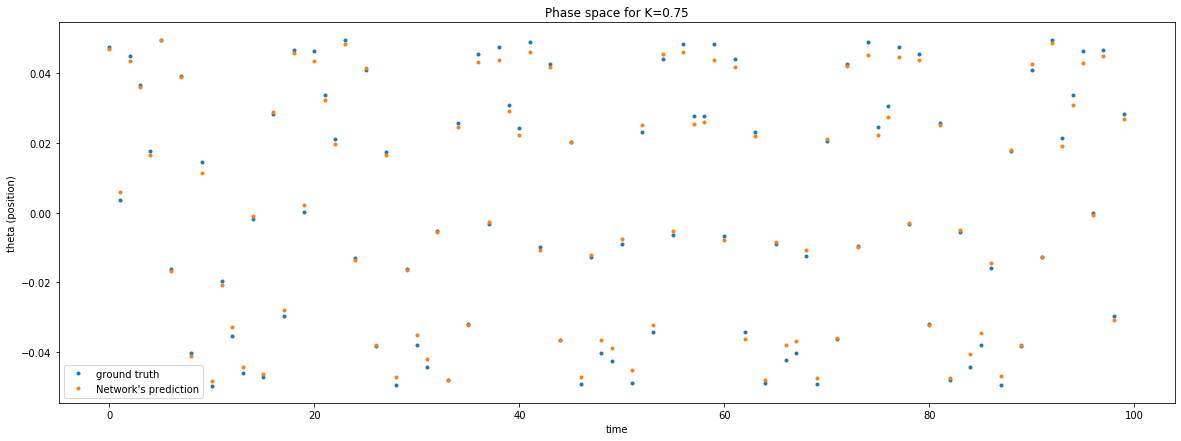

The test MSE is 3.705760685897425e-06
The 84 NRMSE is 2.049647825241958

Initial condition ic=[1, 3.5]

The training MSE is 4.824540702898121e-06


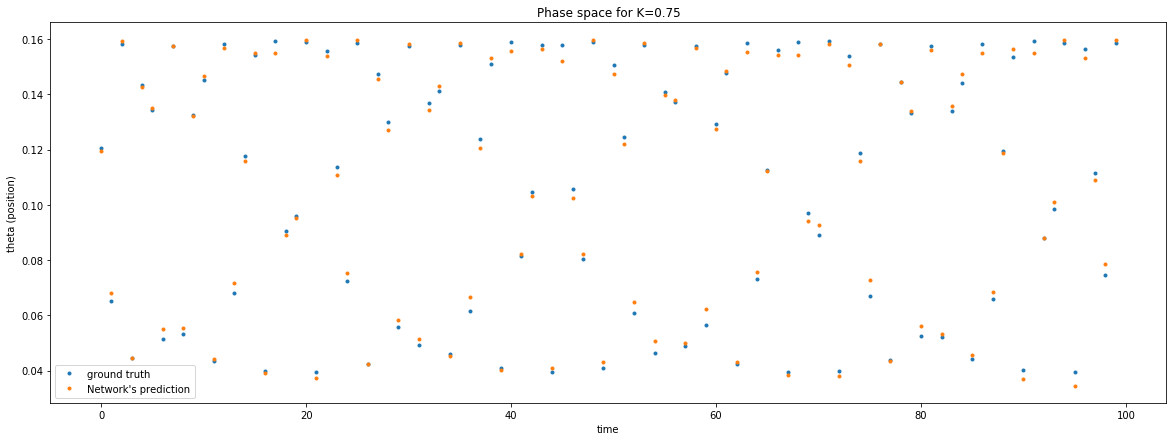

The test MSE is 6.112977408953295e-06
The 84 NRMSE is 4.651401718563661

Initial condition ic=[1, 1.2]

The training MSE is 4.0782606986133865e-06


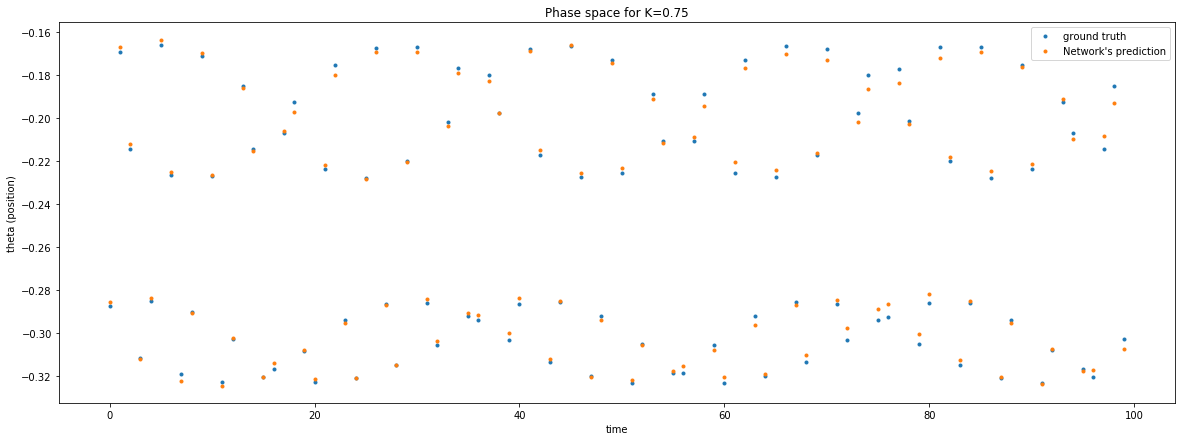

The test MSE is 8.043165771201688e-06
The 84 NRMSE is 2.1239263567118147


In [28]:
#K=0.75
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.75, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


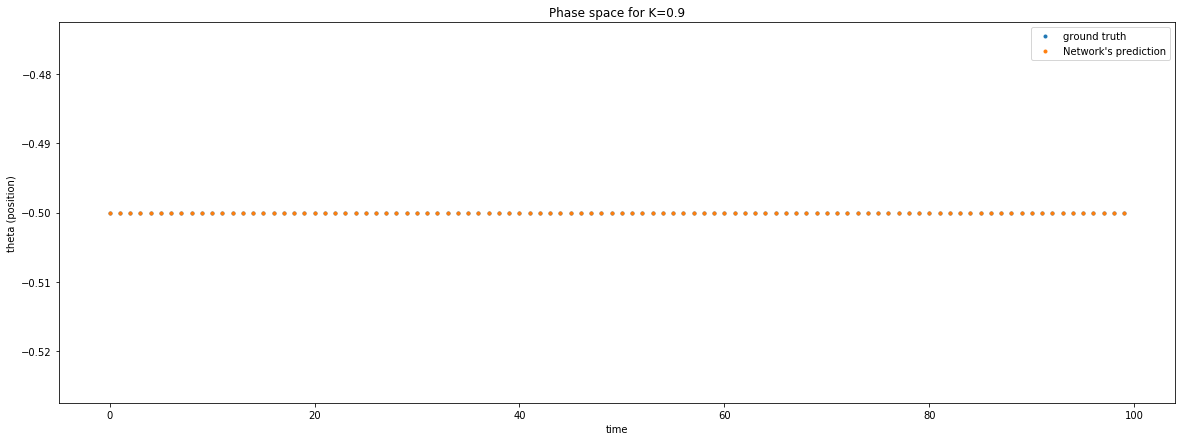

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:361: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 0.015085109507801656


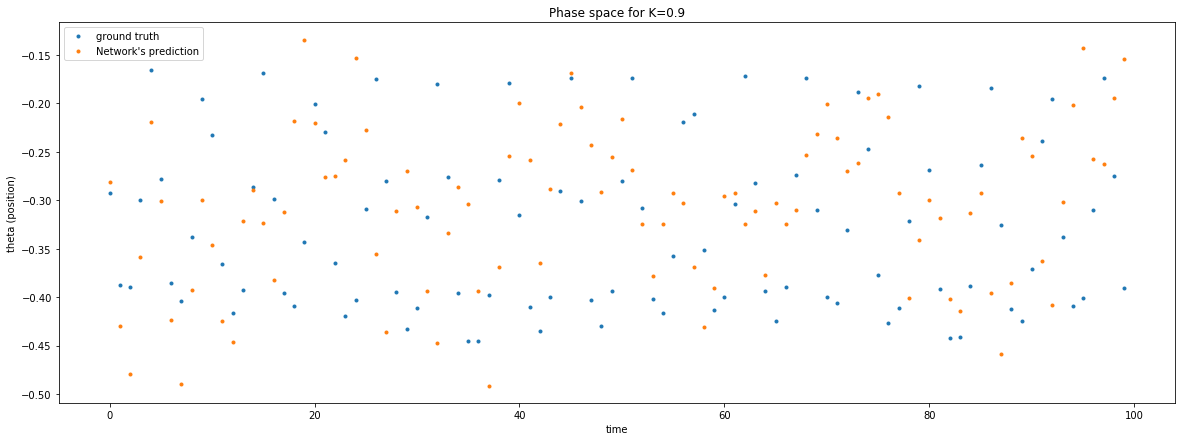

The test MSE is 0.013701015128770977
The 84 NRMSE is 64.20252522645947

Initial condition ic=[0, 0.9]

The training MSE is 0.009358753765808098


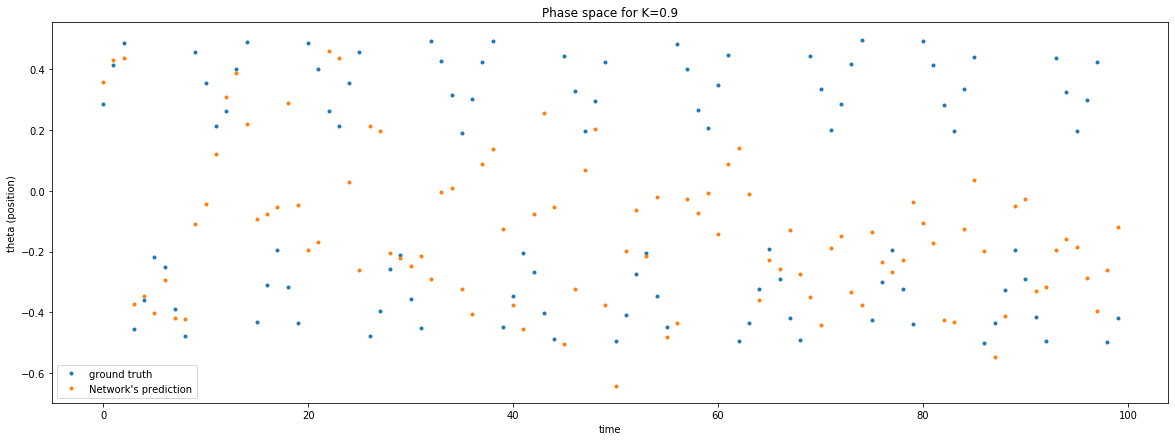

The test MSE is 0.18168845701186023
The 84 NRMSE is 48.02265104496928

Initial condition ic=[0.9, 0]

The training MSE is 0.0017398000917512593


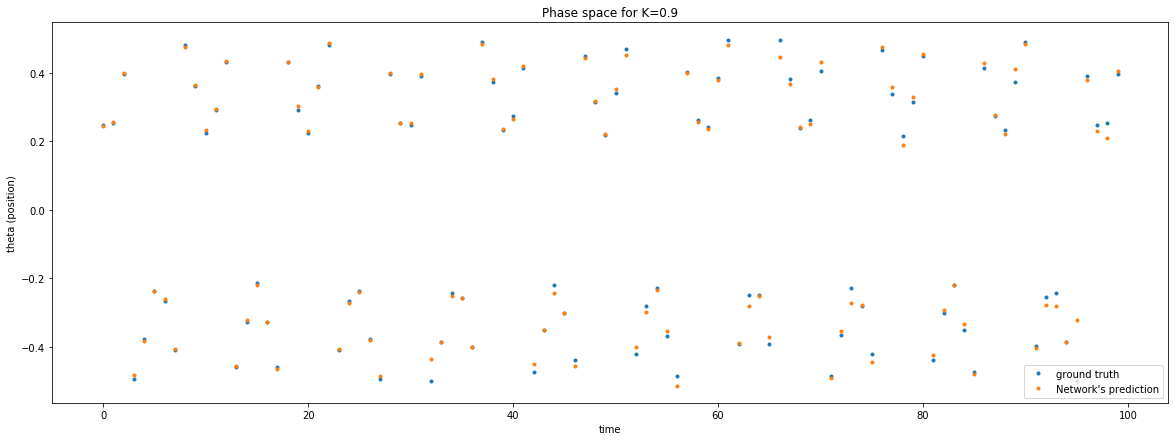

The test MSE is 0.0005624615969917365
The 84 NRMSE is 2.6175934632751003

Initial condition ic=[0.5, 3]

The training MSE is 1.0611390811016656e-06


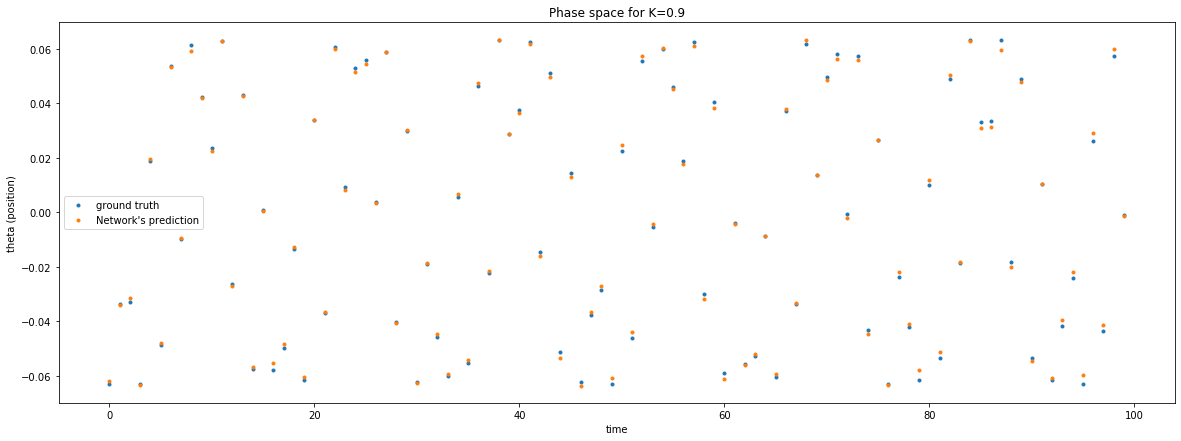

The test MSE is 2.078368086292295e-06
The 84 NRMSE is 1.5993919006181851

Initial condition ic=[1, 3.5]

The training MSE is 2.1396988064412133e-06


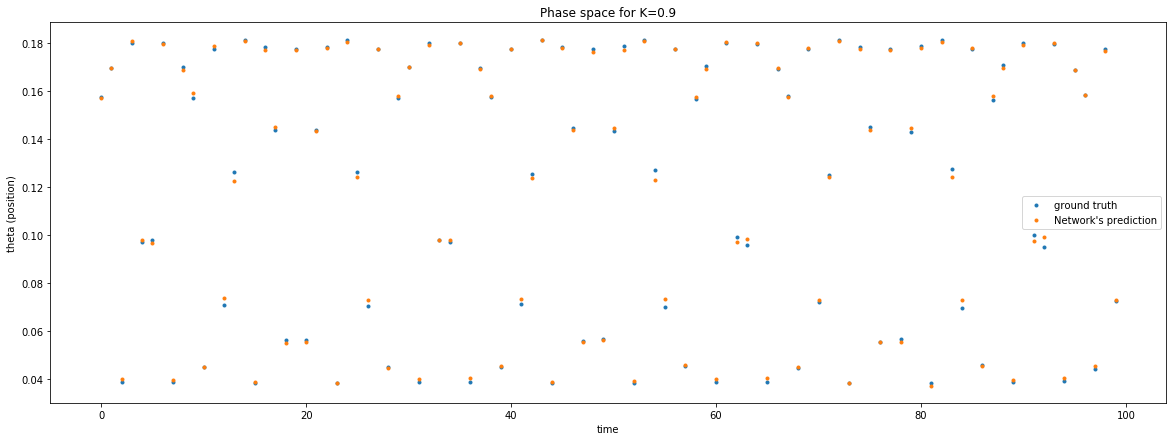

The test MSE is 1.8888070392329337e-06
The 84 NRMSE is 1.2061326052895824

Initial condition ic=[1, 1.2]

The training MSE is 0.008756696909313088


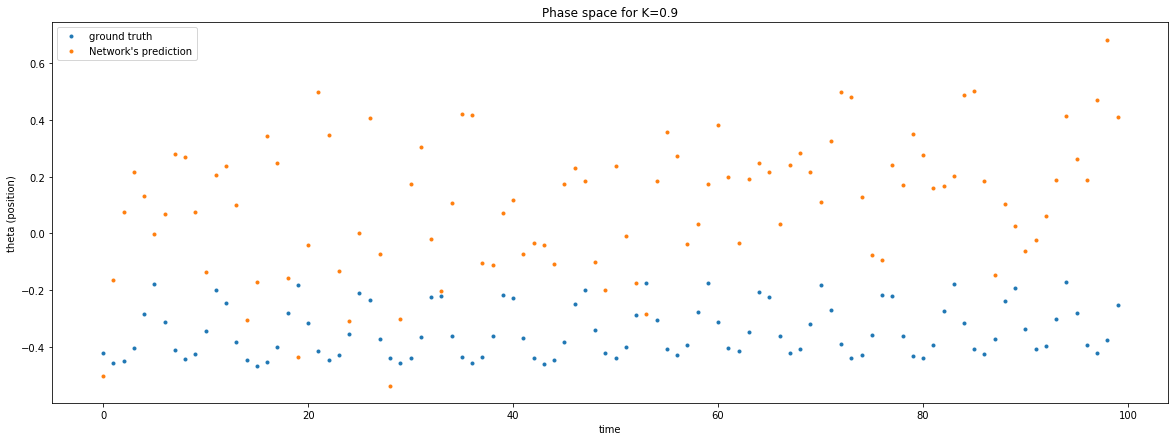

The test MSE is 0.2689890864334932
The 84 NRMSE is 50.27616389126924


In [29]:
#K=0.9
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=0.9, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

# 2.5 Chaotic behavior <a name="pKchaos" ></a>

## K=1.2

In [30]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 1
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W


Initial condition ic=[0, 0]

The training MSE is 1.232595164407831e-32


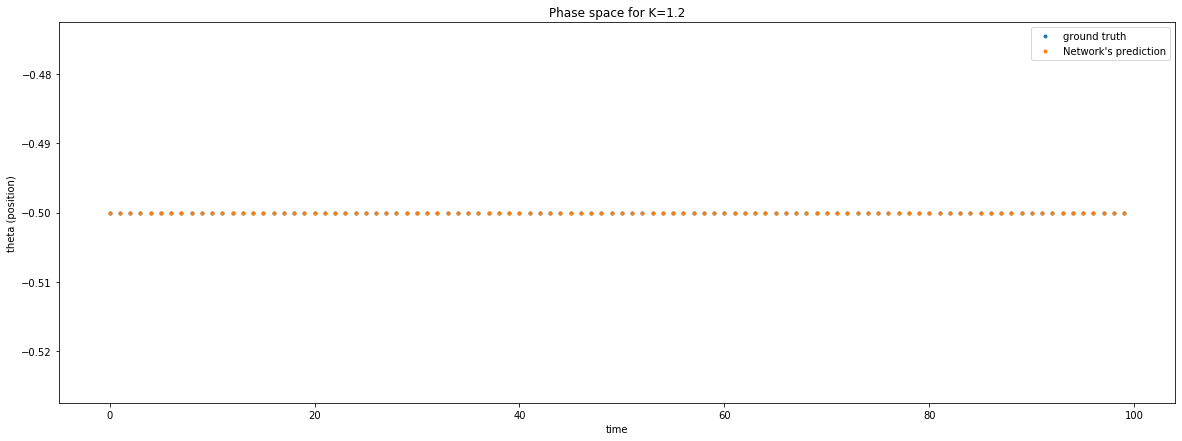

The test MSE is 2.7733391199176196e-32


/home/vant/anaconda3/envs/EchoState/lib/python3.7/site-packages/ipykernel_launcher.py:361: RuntimeWarning: divide by zero encountered in double_scalars


The 84 NRMSE is inf

Initial condition ic=[0.8975979010256552, 0.7853981633974483]

The training MSE is 0.011891052712903338


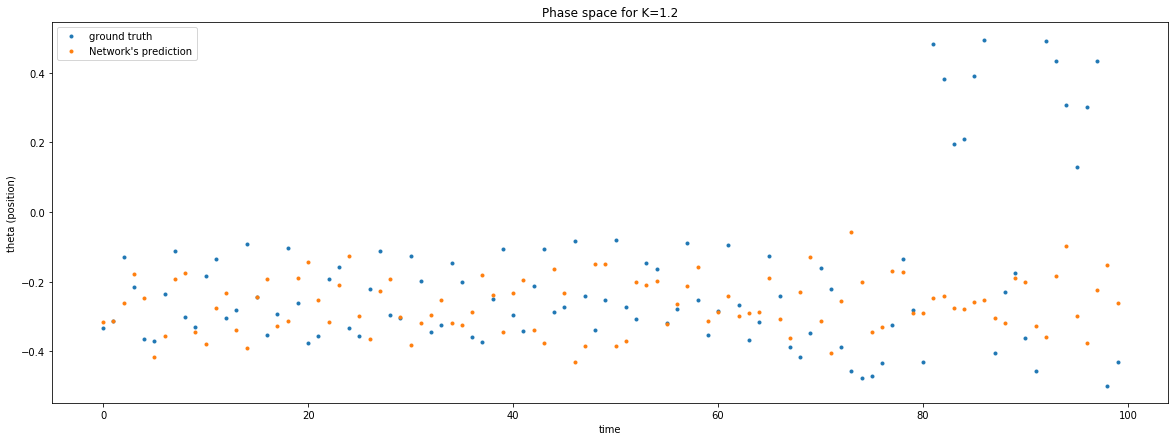

The test MSE is 0.06606889262395
The 84 NRMSE is 56.74084538649312

Initial condition ic=[0, 0.9]

The training MSE is 0.010902085989144748


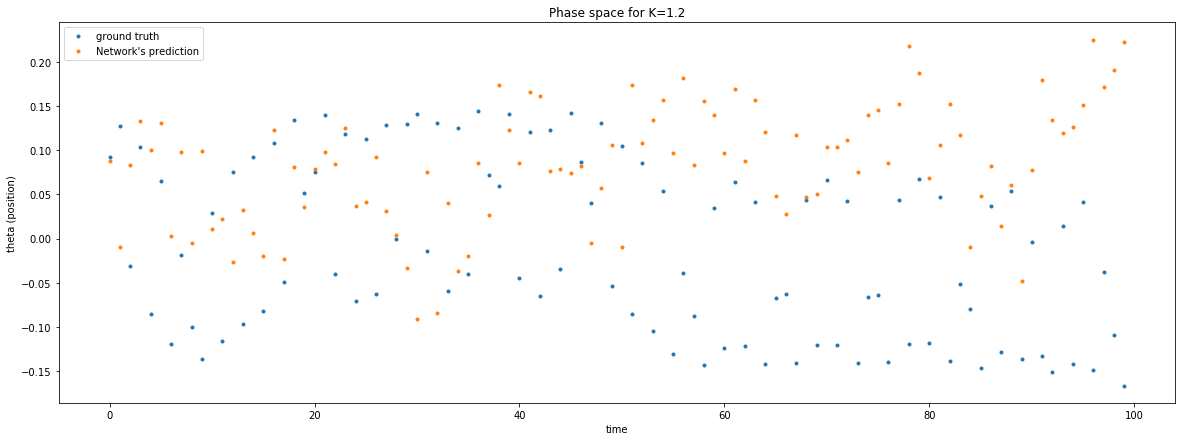

The test MSE is 0.025990790865866444
The 84 NRMSE is 55.61263511176226

Initial condition ic=[0.9, 0]

The training MSE is 0.002059686228697924


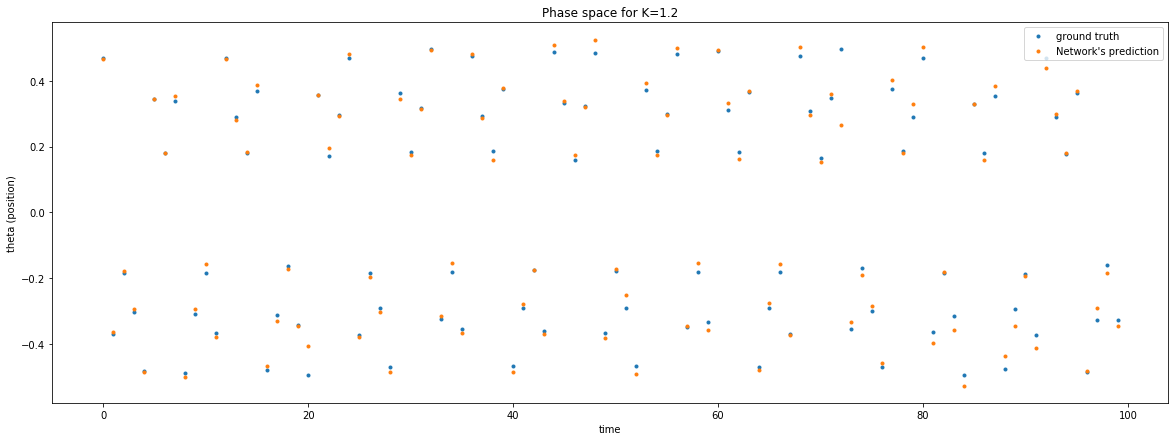

The test MSE is 0.0009679006468941323
The 84 NRMSE is 4.23407602452572

Initial condition ic=[0.5, 3]

The training MSE is 1.9219169988565552e-05


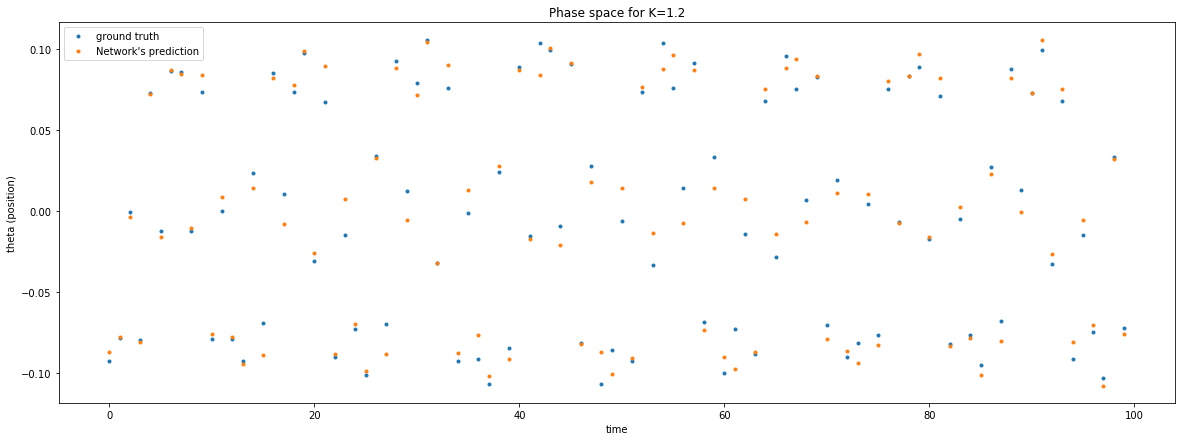

The test MSE is 0.00010621381741873254
The 84 NRMSE is 5.6113339184636155

Initial condition ic=[1, 3.5]

The training MSE is 5.189601988616083e-05


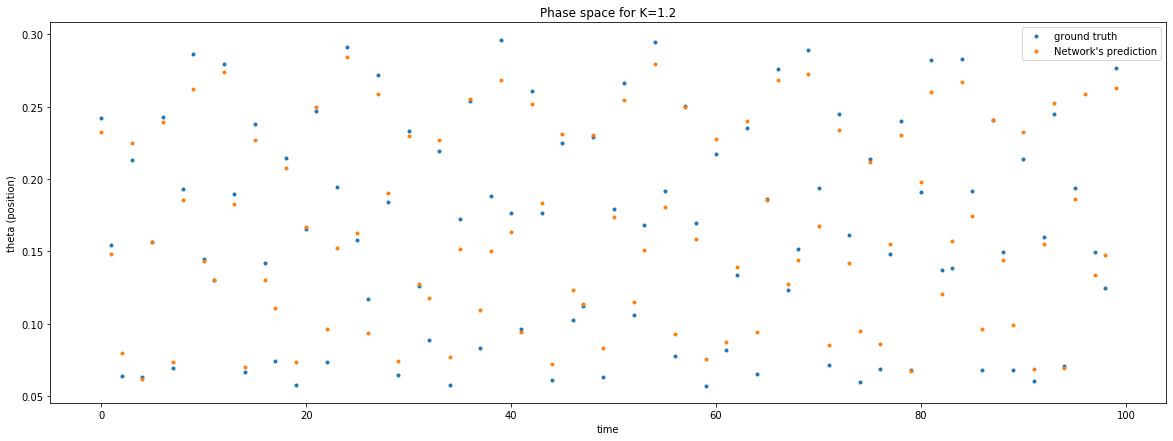

The test MSE is 0.00024352655248873216
The 84 NRMSE is 15.356866290744378

Initial condition ic=[1, 1.2]

The training MSE is 0.015021825221224755


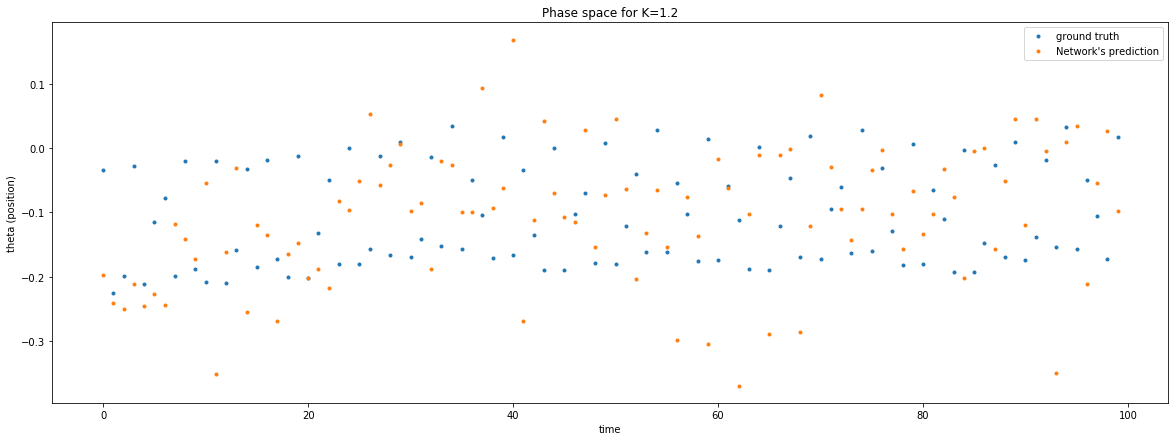

The test MSE is 0.017493039712902895
The 84 NRMSE is 53.05824890758364


In [31]:
Network.train_test(ic_list=[[0,0],[2*np.pi/7, 2*np.pi/8],[0,0.9],[0.9,0],[0.5,3],[1,3.5],[1,1.2]], k=1.2, t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)

## Fix the initial condition and increase the value of K

Let us now modify the value of $K$ while the initial condition remains fixed at (0.9,0).

In [32]:
#Parameters of the network

Network.T = 7000 
Network.n_min = 500 
Network.N = 3000 
Network.L = 1
Network.W_back = np.random.uniform(low=-0.56, high=0.56, size=Network.N*Network.L).reshape((Network.N,Network.L))

Network.K = 1
Network.W_in = np.random.choice([0,0.7,-0.7], Network.N*Network.K, p=[0.5, 0.25, 0.25]).reshape((Network.N,Network.K))
Network.u = np.array([[0.5]]) 
#############
#Reservoir
#############
Network.W = np.random.choice([0,0.4,-0.4], Network.N*Network.N, p=[0.9875, 0.00625, 0.00625]) #adjacency matrix
Network.W = Network.W.reshape((Network.N, Network.N))

#rescale Network.W
alpha = 1.35/max(abs(scipy.linalg.eigvals(Network.W))) #1.25 - 1.40
Network.W = alpha*Network.W

In [33]:
Network.non_null_matrices = ["W_back", "W_in"]


Kick value K=1.2

The training MSE is 0.0035505947716403963


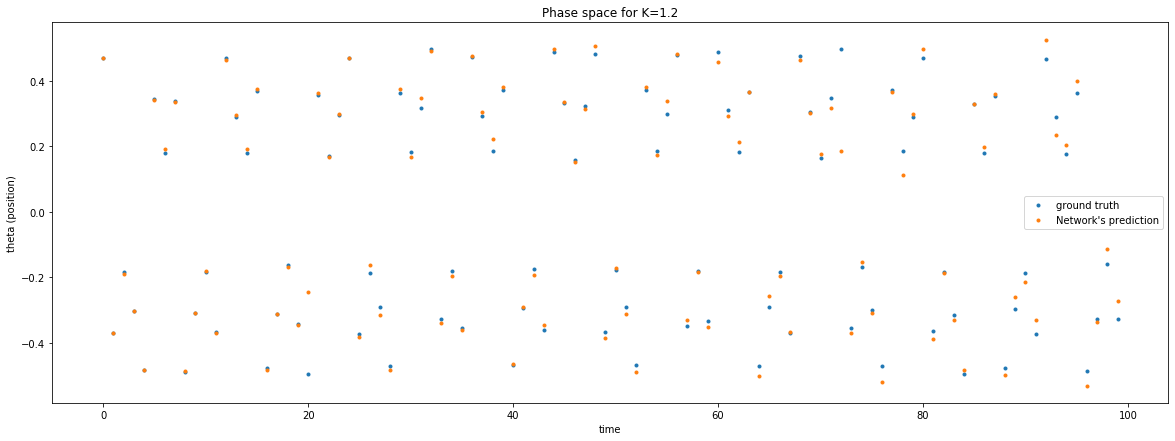

The test MSE is 0.0020693215359742466
The 84 NRMSE is 3.1479346422467307

Kick value K=1.5

The training MSE is 0.01846987302536048


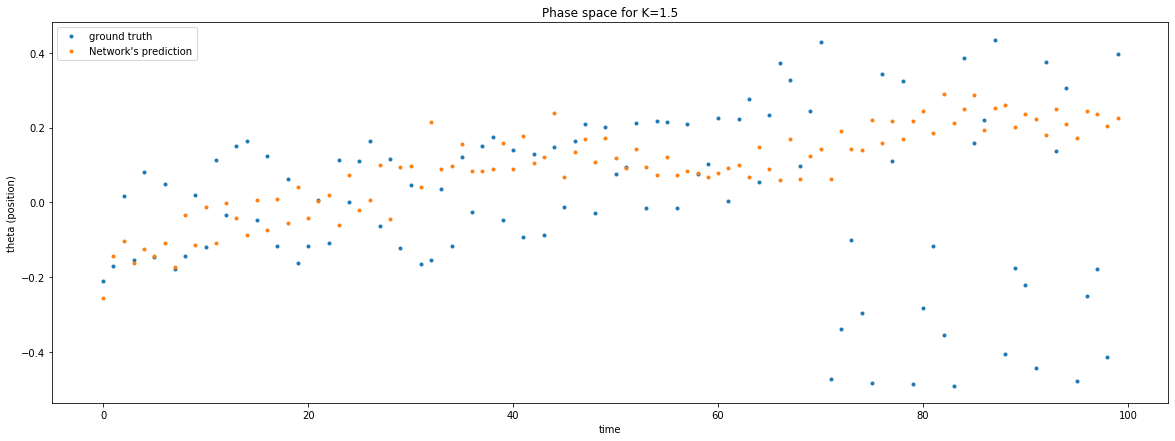

The test MSE is 0.07240140730168662
The 84 NRMSE is 53.452254464606035

Kick value K=2

The training MSE is 0.03484157292453291


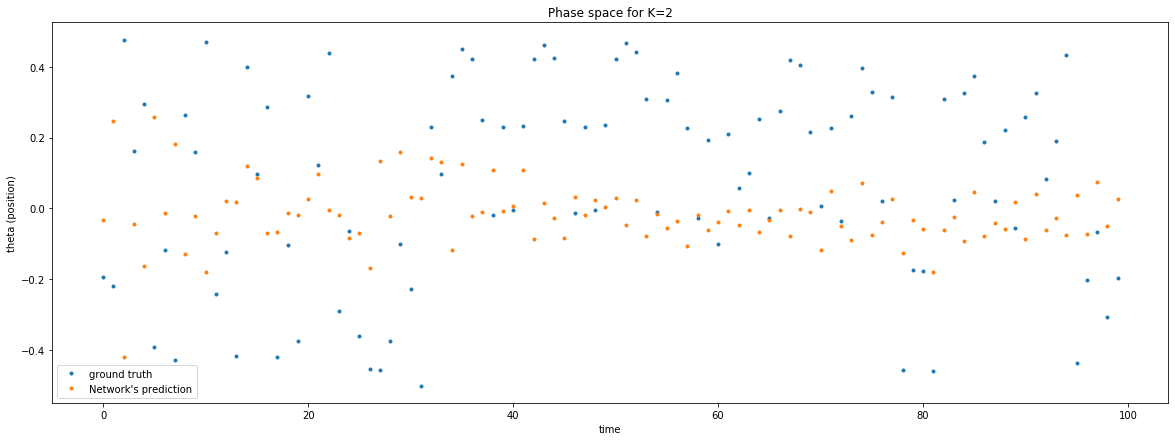

The test MSE is 0.10565441756940429
The 84 NRMSE is 46.431911906537096

Kick value K=3

The training MSE is 0.049338923892072326


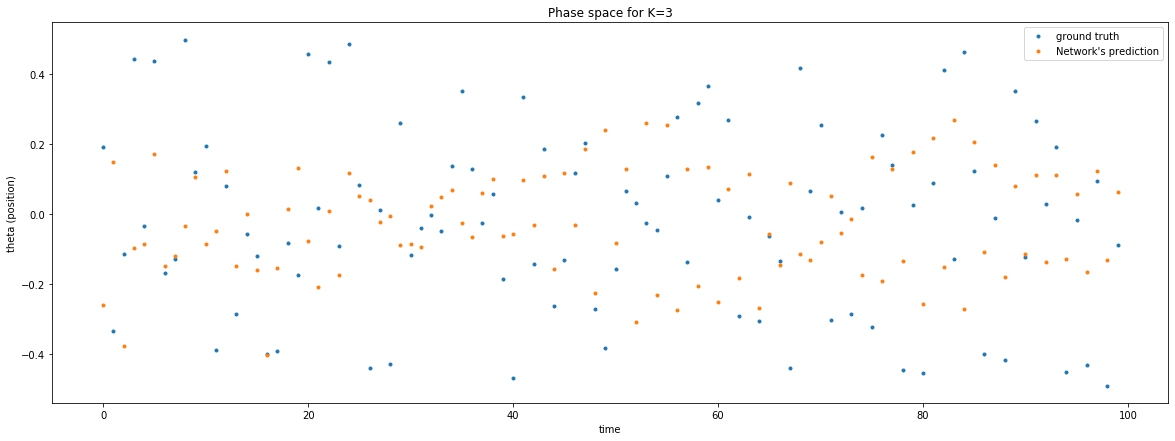

The test MSE is 0.07955803958505915
The 84 NRMSE is 53.19388682384269

Kick value K=5

The training MSE is 0.0578472273502216


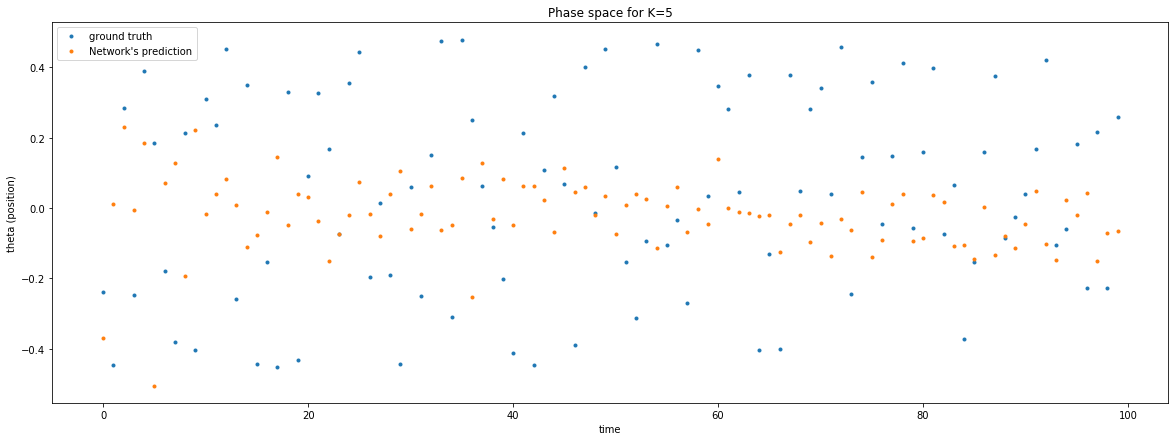

The test MSE is 0.0981746622690978
The 84 NRMSE is 47.41992716837571

Kick value K=7

The training MSE is 0.05591322046688681


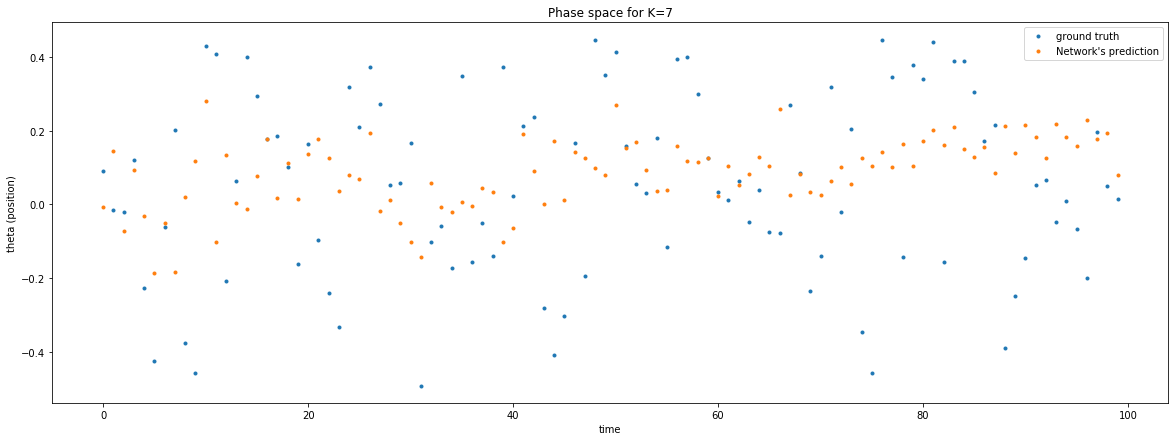

The test MSE is 0.0640333165002217
The 84 NRMSE is 48.58587809499667


In [34]:
Network.train_test_k(ic=[0.9,0], k_list=[1.2, 1.5, 2, 3, 5, 7], t_dismiss=Network.T, t_autonom=100, NRMSE=True, noise=True, stDev=0.001, regression_type='Ridge', regression_param=10)